# importing the neccessary libraries to collab
import pandas as pd
import numpy as np
import smtplib as sm
!pip install XlsxWriter
import xlsxwriter



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
!pip install XlsxWriter
import xlsxwriter
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 3.0 MB/s eta 0:00:00


In [ ]:
final_datasets=['American Modern Ins Grp Inc',
 'Amerisafe Grp',
 'Overseas Partners Us Reins Co',
 'Hyundai Marine & Fire Ins Co Ltd',
 'Martingale Natl Ins Co',
 'Proformance Ins Co (The)',
 'Catholic Relief Ins Co Of Amer',
 'First Amer Ins Co',
 'Generali Us Branch',
 'Underwriters At Lloyds London',
 'Cooperative Mut Ins Co',
 'Elevators Mut Ins Co',
 'Mennonite Mut Ins Co',
 'Co-Operative Ins Co',
 'New York Municipal Ins Reciprocal',
 'Housing & Redevelopment Ins Exch',
 'Middle States Ins Co Inc',
 'Contractors Bonding & Ins Co',
 'Pacific Specialty Ins Co',
 'Omega Ins Co',
 'Southern Group Ind Inc',
 'Nova Cas Co',
 'Atlantic Cas Ins Co',
 'Dowa Fire & Marine Ins Co Ltd Us Br',
 'Yel Co Ins']



In [ ]:
len(final_datasets)

25

In [ ]:
publish='/content/drive/MyDrive/Colab resources/CsOutstandingProject/Results_by_normal_method/'

In [ ]:
len(final_datasets)

25

In [ ]:
class CaseOutstanding_Reserving:
  def __init__(self,df,accident_year,reported_year,reported_loss,paid_reported_loss,case_outstanding):
    self.df=df
    self.accident_year=accident_year
    self.reported_year=reported_year
    self.reported_loss=reported_loss
    self.paid_reported_loss=paid_reported_loss
    self.case_outstanding=case_outstanding


# This method will help you to build triangle given the parameter
  def d_triangle(self,parameter):
      columns=[]
      max=0
      for i in self.df[self.accident_year].unique():
        a=self.df.groupby(self.accident_year)
        a=a.get_group(i)
        l=len(a)
        if max<l:
          max=l
      final=[]
      for i in range(1,max+1):
        columns.append(12*i)
      j=0
      for i in self.df[self.accident_year].unique():
        check=1
        lis=[]
        while check and j<len(self.df):
          if j+1 <= len(self.df):
            lis.append(self.df.loc[j,parameter])
          if j+1 >= len(self.df):
            check=0
          else:
            curr=self.df[self.accident_year][j]
            next=self.df[self.accident_year][j+1]
          if next != curr:
            check=0
          j=j+1
        if (len(lis)<max):
          for i in range(0,max-len(lis)):
            lis.append(np.NaN)
        final.append(lis)
      bf=pd.DataFrame(final,columns=columns)
      bf["AccidentYear"]=self.df[self.accident_year].unique()
      first_column = bf.pop('AccidentYear')
      bf.insert(0,"AccidentYear",first_column)
      return bf


#This method will help in building incremental triangles especially if you wanna convert cummulative paid claims in to incremental ones
  def incremental_triangles(self):
    final=[]
    for i in range(0,len(self.d_triangle(self.paid_reported_loss))):
      val=[]
      for j in range(0,len(self.d_triangle(self.paid_reported_loss).columns)):
        if j==0 or j==1:
          g=self.d_triangle(self.paid_reported_loss).loc[i,self.d_triangle(self.paid_reported_loss).columns[j]]
        else:
          if self.d_triangle(self.paid_reported_loss).loc[i,self.d_triangle(self.paid_reported_loss).columns[j]]!=np.NaN:
            g=self.d_triangle(self.paid_reported_loss).loc[i,self.d_triangle(self.paid_reported_loss).columns[j]]-self.d_triangle(self.paid_reported_loss).loc[i,self.d_triangle(self.paid_reported_loss).columns[j-1]]
          else:
            g=np.NaN
        val.append(g)
      final.append(val)
    inc=pd.DataFrame(final,columns=self.d_triangle(self.paid_reported_loss).columns)
    return inc


#This will help you to pai
  def paid_tr_on_case_ratio(self):
    final=[]
    li=list(self.d_triangle(self.paid_reported_loss).columns[1:])
    bi=list(self.d_triangle(self.paid_reported_loss).columns[2:])
    for i in range(0,len(self.d_triangle(self.paid_reported_loss))-1):
      val=[]
      for j in range(0,len(li)-1):
        if self.d_triangle(self.paid_reported_loss).loc[i].at[li[j+1]]!=np.NaN and self.d_triangle(self.paid_reported_loss).loc[i].at[li[j]]!=np.NaN:
          g=self.d_triangle(self.paid_reported_loss).loc[i].at[li[j+1]]-self.d_triangle(self.paid_reported_loss).loc[i].at[li[j]]
        else:
          g=np.NaN
        if self.d_triangle(self.case_outstanding).loc[i].at[li[j]]!=np.NaN:
          f=self.d_triangle(self.case_outstanding).loc[i].at[li[j]]
        else:
          f=np.NaN
        if f!=np.NaN and g!=np.NaN:
          val.append(g/f)
        else:
          val.append(np.NaN)
      final.append(val)
    nf=pd.DataFrame(final,columns=bi)
    nf[self.accident_year]=self.d_triangle(self.paid_reported_loss)[self.accident_year]
    first_column = nf.pop(self.accident_year)
    nf.insert(0,self.accident_year,first_column)
    return nf


  def rem_in_case_ratio(self):
    li=list(self.d_triangle(self.case_outstanding).columns[1:])
    bi=li[1:]
    final=[]
    for i in range(0,len(self.d_triangle(self.case_outstanding))-1):
      val=[]
      for j in range(0,len(li)-1):
        if self.d_triangle(self.case_outstanding).loc[i].at[li[j]]!=np.NaN and self.d_triangle(self.case_outstanding).loc[i].at[li[j+1]]!=np.NaN:
          c=self.d_triangle(self.case_outstanding).loc[i].at[li[j+1]]/self.d_triangle(self.case_outstanding).loc[i].at[li[j]]
          val.append(c)
        else:
          val.append(np.NaN)
      final.append(val)
    nf=pd.DataFrame(final,columns=bi)
    nf=pd.DataFrame(final,columns=bi)
    nf[self.accident_year]=self.d_triangle(self.case_outstanding)[self.accident_year]
    first_column = nf.pop(self.accident_year)
    nf.insert(0,self.accident_year,first_column)
    return nf



  def calc_measures(self,ratio_triangle):
    columns=list(ratio_triangle.columns)
    final=[]
    for i in columns[1:]:
      val=[]
      mean=ratio_triangle[i].mean()
      median=ratio_triangle[i].median()
      val.append(mean)
      val.append(median)
      final.append(val)
    bf=pd.DataFrame(final)
    bf.columns=["Mean","Median"]
    bf["Months"]=(bf.index+2)*12
    bf.transpose()
    return bf

  def fill_triangles_case_outstanding(self,measure,method):
    dup=self.d_triangle(self.case_outstanding)
    columns=list(dup.columns)
    for i in range(0,len(dup)):
      for j in range(1,len(columns)):
        if dup.isnull().iloc[i,j]:
          dup.loc[i,columns[j]]=round(measure[method][j-2]*dup.loc[i].at[columns[j-1]],3)
    return dup

  def fill_triangles_paid_triangle(self,case_out,paid_inc,measure,method):
    columns=list(case_out.columns)
    for i in range(0,len(case_out)):
      for j in range(1,len(columns)):
        if paid_inc.isnull().loc[i,columns[j]]:
          paid_inc.loc[i,columns[j]]=(measure[method][j-2]*case_out.loc[i].at[columns[j-1]])
    return paid_inc











The name of the dataset is: American Modern Ins Grp Inc
the final dataset looks like this:
   AccidentYear   12    24    36    48    60    72    84    96   108   120
0          1993    9    20    25    29    40    41    41    41    41    41
1          1994  222   341   809   963   966   966   966   966   966   966
2          1995  380   782  1315  1404  1503  1517  1522  1522  1522  1526
3          1996  607  1153   983  1545  1657  1656  1656  1656  1656  1656
4          1997  636  2202  2619  3311  3872  3874  3928  3932  3932  3932
----------------------------------------------------------------------------------------------------------------------------------------------------


This is the case_outstanding Triangle
   AccidentYear    12      24      36      48     60
0          1993    36   130.0   271.0   456.0  670.0
1          1994   268   895.0  2032.0  4007.0    NaN
2          1995   903  2899.0  5861.0     NaN    NaN
3          1996  2119  6185.0     NaN     NaN    NaN
4    

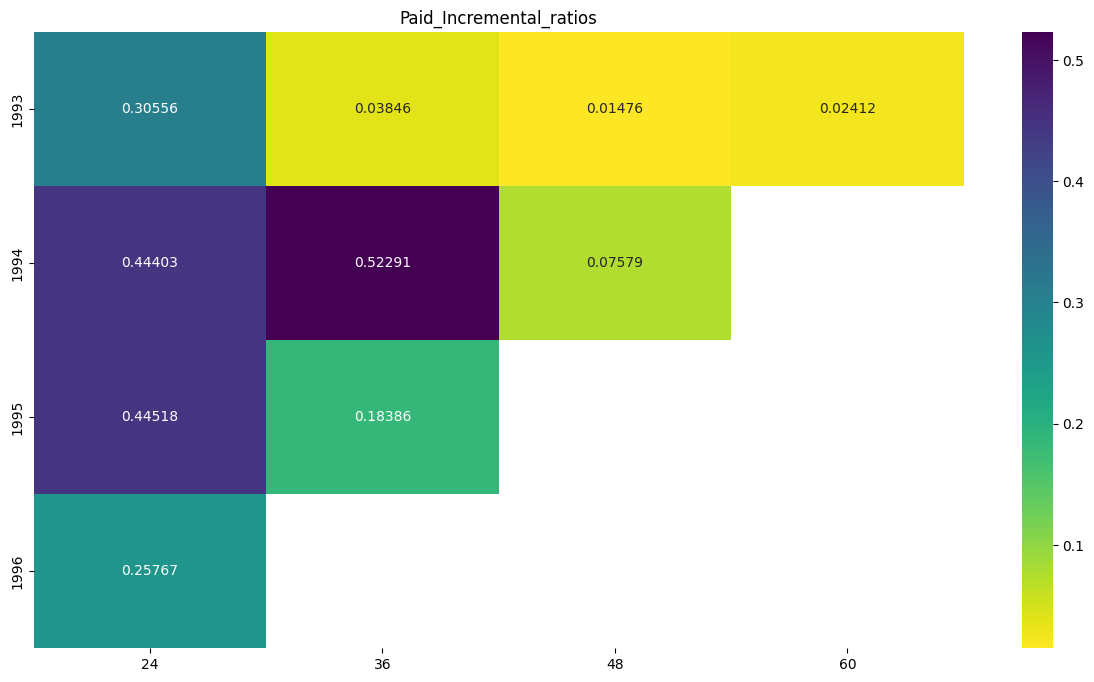



This is the case_ratio_Triangle
   AccidentYear        24        36        48        60
0          1993  3.611111  2.084615  1.682657  1.469298
1          1994  3.339552  2.270391  1.971949       NaN
2          1995  3.210410  2.021732       NaN       NaN
3          1996  2.918830       NaN       NaN       NaN
----------------------------------------------------------------------------------------------------------------------------------------------------


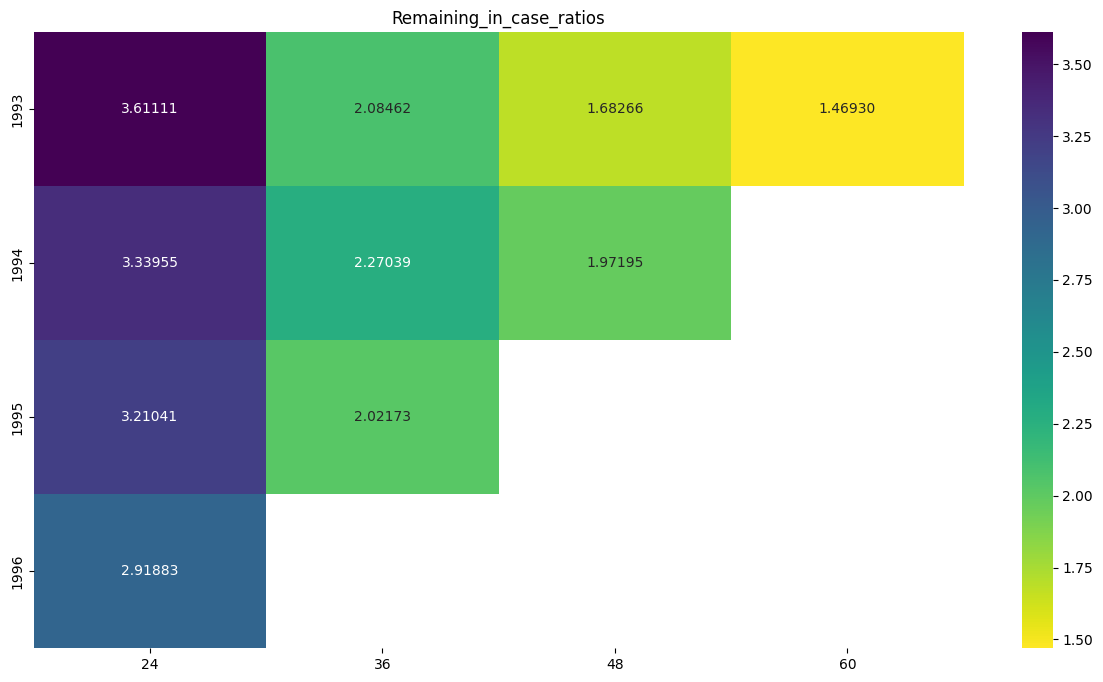



This is the case_out measures or averages Triangle
       Mean    Median  Months
0  3.269976  3.274981      24
1  2.125579  2.084615      36
2  1.827303  1.827303      48
3  1.469298  1.469298      60
----------------------------------------------------------------------------------------------------------------------------------------------------


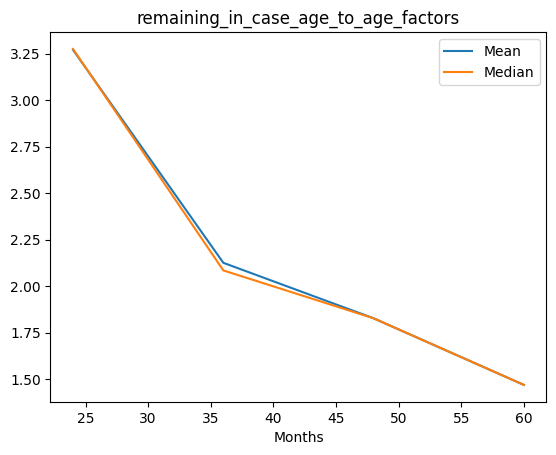



This is the paid incremental measures or averages Triangle
       Mean    Median  Months
0  0.363109  0.374793      24
1  0.248408  0.183857      36
2  0.045274  0.045274      48
3  0.024123  0.024123      60
----------------------------------------------------------------------------------------------------------------------------------------------------


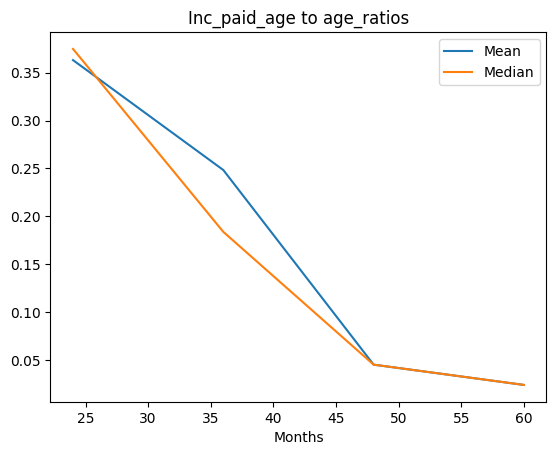



This is the filled case_outstanding Triangle
   AccidentYear    12        24         36         48         60
0          1993    36   130.000    271.000    456.000    670.000
1          1994   268   895.000   2032.000   4007.000   5887.478
2          1995   903  2899.000   5861.000  10709.822  15735.923
3          1996  2119  6185.000  13146.708  24023.017  35296.977
4          1997  1998  6533.411  13887.284  25376.273  37285.313
----------------------------------------------------------------------------------------------------------------------------------------------------


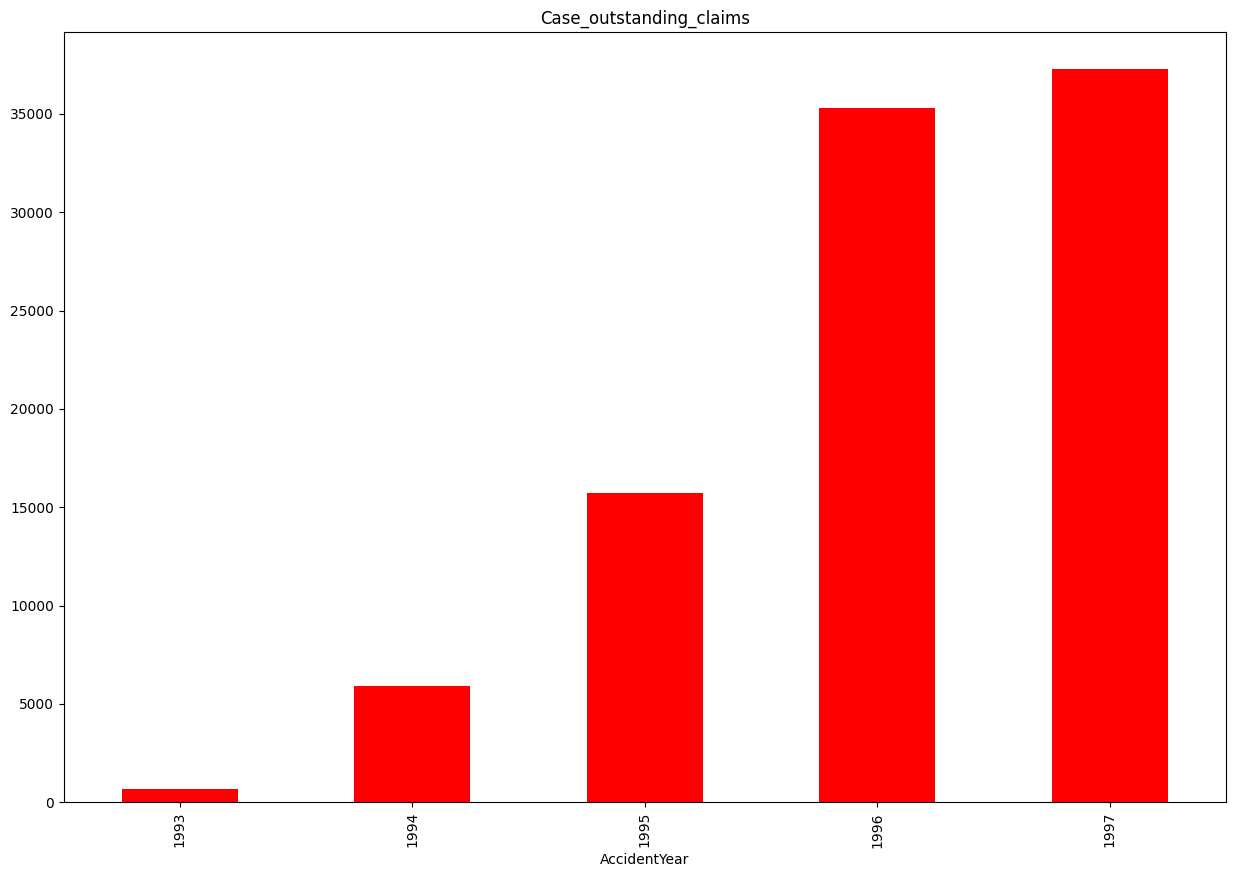



This is the cummulative filled incremental paid claims Triangle
   AccidentYear   12           24           36           48           60
0          1993    9    20.000000    25.000000    29.000000    40.000000
1          1994  222   341.000000   809.000000   963.000000  1059.660088
2          1995  380   782.000000  1315.000000  1580.349593  1838.700562
3          1996  607  1153.000000  2689.401560  3284.602654  3864.105257
4          1997  636  1361.492203  2984.441734  3613.171500  4225.318436


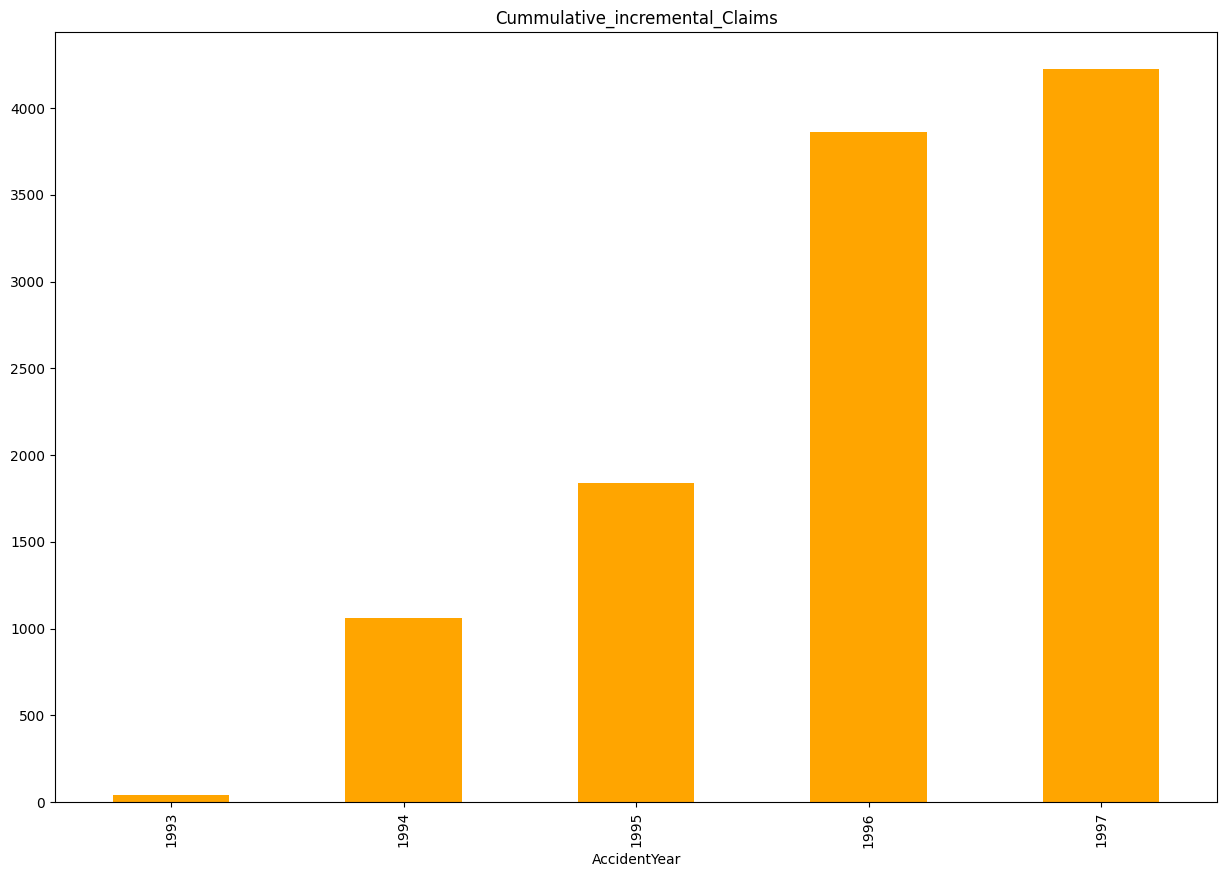

8038
11027.784343262872
----------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------
The name of the dataset is: Amerisafe Grp
the final dataset looks like this:
   AccidentYear  12  24  36  48  60  72  84   96  108  120
0          1988   8  24  50  50  50  50  50   50   50   50
1          1989  29  59  59  59  59  59  59   59   59   59
2          1990  32  70  70  70  84  88  90  100  100  100
3          1992   1   2   2   2   2   2   2    2    2    3
----------------------------------------------------------------------------------------------------------------------------------------------------


This is the case_outstanding Triangle
   AccidentYear  12   24   36   48   60    72      84      96     108     120
0          1988   2   29   80  181  332

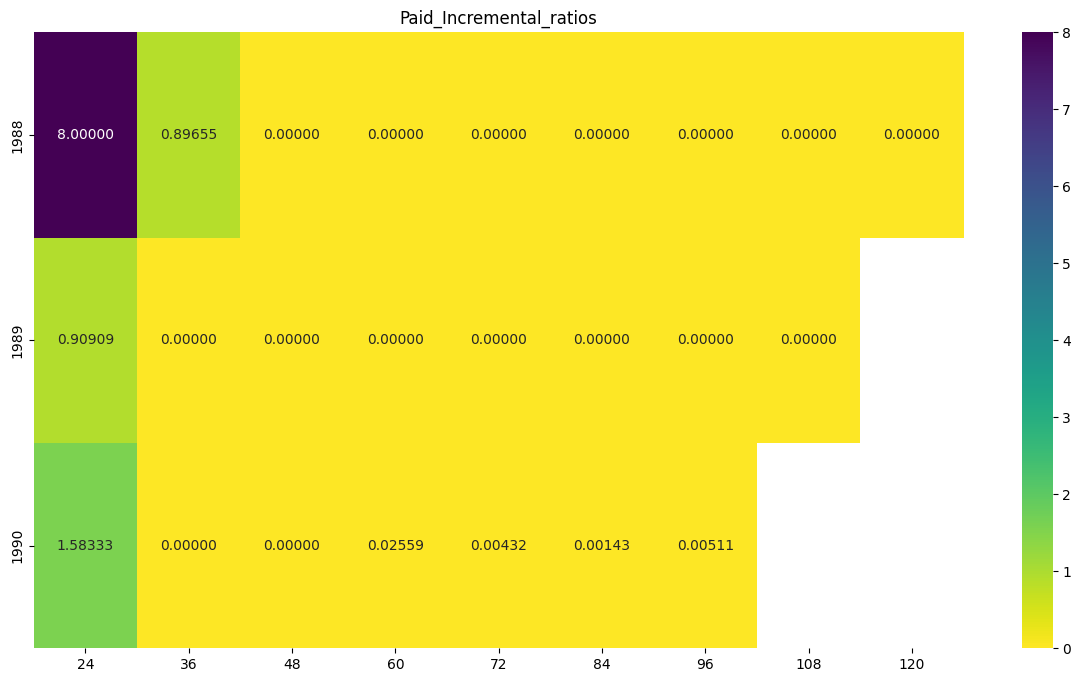



This is the case_ratio_Triangle
   AccidentYear         24        36        48        60        72        84  \
0          1988  14.500000  2.758621  2.262500  1.834254  1.608434  1.473783   
1          1989   3.030303  2.260000  1.818584  1.593674  1.462595  1.377871   
2          1990   4.458333  2.682243  1.905923  1.691042  1.507027  1.404591   

         96       108       120  
0  1.386277  1.324473  1.279585  
1  1.318939  1.275704       NaN  
2  1.334014       NaN       NaN  
----------------------------------------------------------------------------------------------------------------------------------------------------


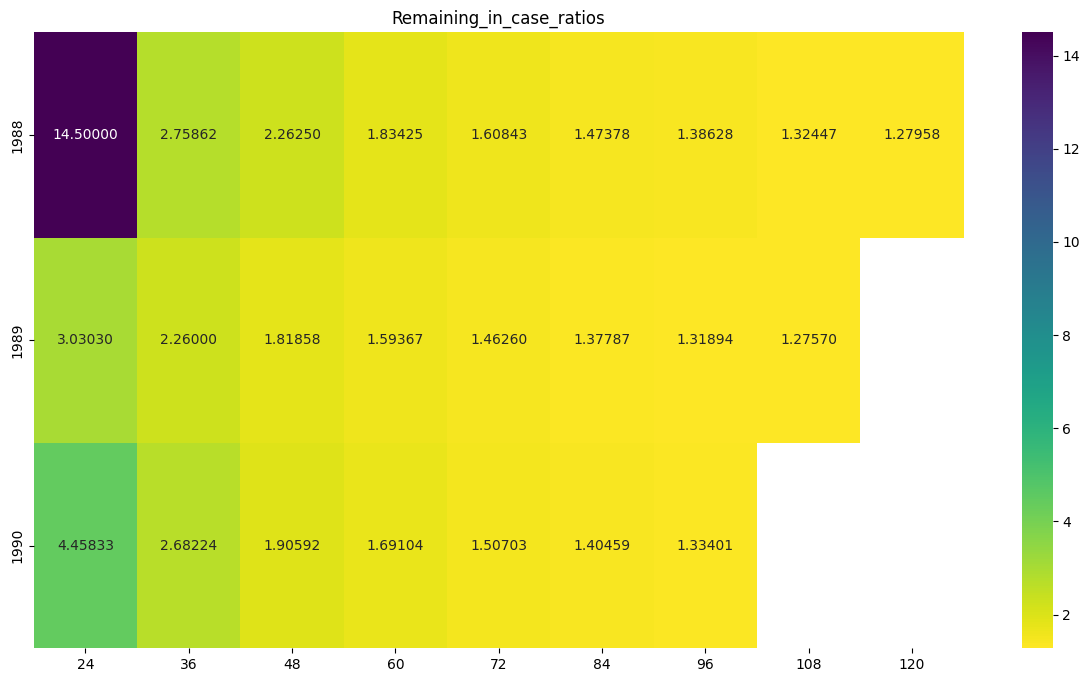



This is the case_out measures or averages Triangle
       Mean    Median  Months
0  7.329545  4.458333      24
1  2.566955  2.682243      36
2  1.995669  1.905923      48
3  1.706323  1.691042      60
4  1.526019  1.507027      72
5  1.418748  1.404591      84
6  1.346410  1.334014      96
7  1.300088  1.300088     108
8  1.279585  1.279585     120
----------------------------------------------------------------------------------------------------------------------------------------------------


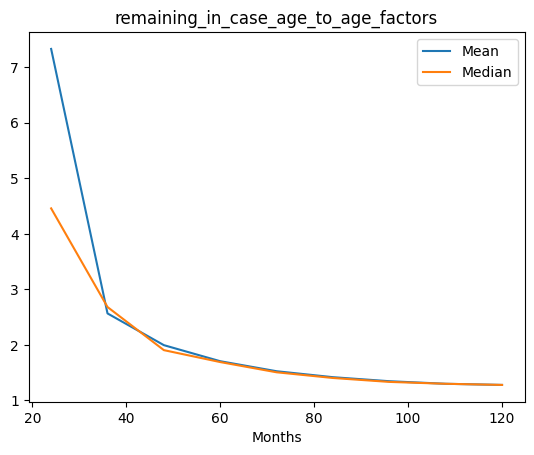



This is the paid incremental measures or averages Triangle
       Mean    Median  Months
0  3.497475  1.583333      24
1  0.298851  0.000000      36
2  0.000000  0.000000      48
3  0.008531  0.000000      60
4  0.001441  0.000000      72
5  0.000478  0.000000      84
6  0.001702  0.000000      96
7  0.000000  0.000000     108
8  0.000000  0.000000     120
----------------------------------------------------------------------------------------------------------------------------------------------------


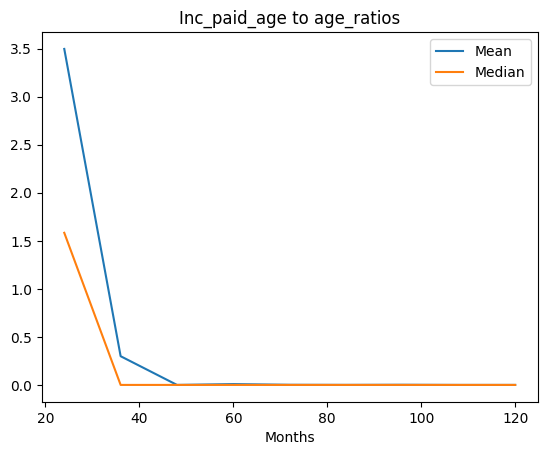



This is the filled case_outstanding Triangle
   AccidentYear  12   24   36   48   60    72        84        96       108  \
0          1988   2   29   80  181  332   534   787.000  1091.000  1445.000   
1          1989  33  100  226  411  655   958  1320.000  1741.000  2221.000   
2          1990  24  107  287  547  925  1394  1958.000  2612.000  3395.831   
3          1992   0    1    5   11   19    29    41.144    55.397    72.021   

        120  
0  1849.000  
1  2841.958  
2  4345.254  
3    92.157  
----------------------------------------------------------------------------------------------------------------------------------------------------


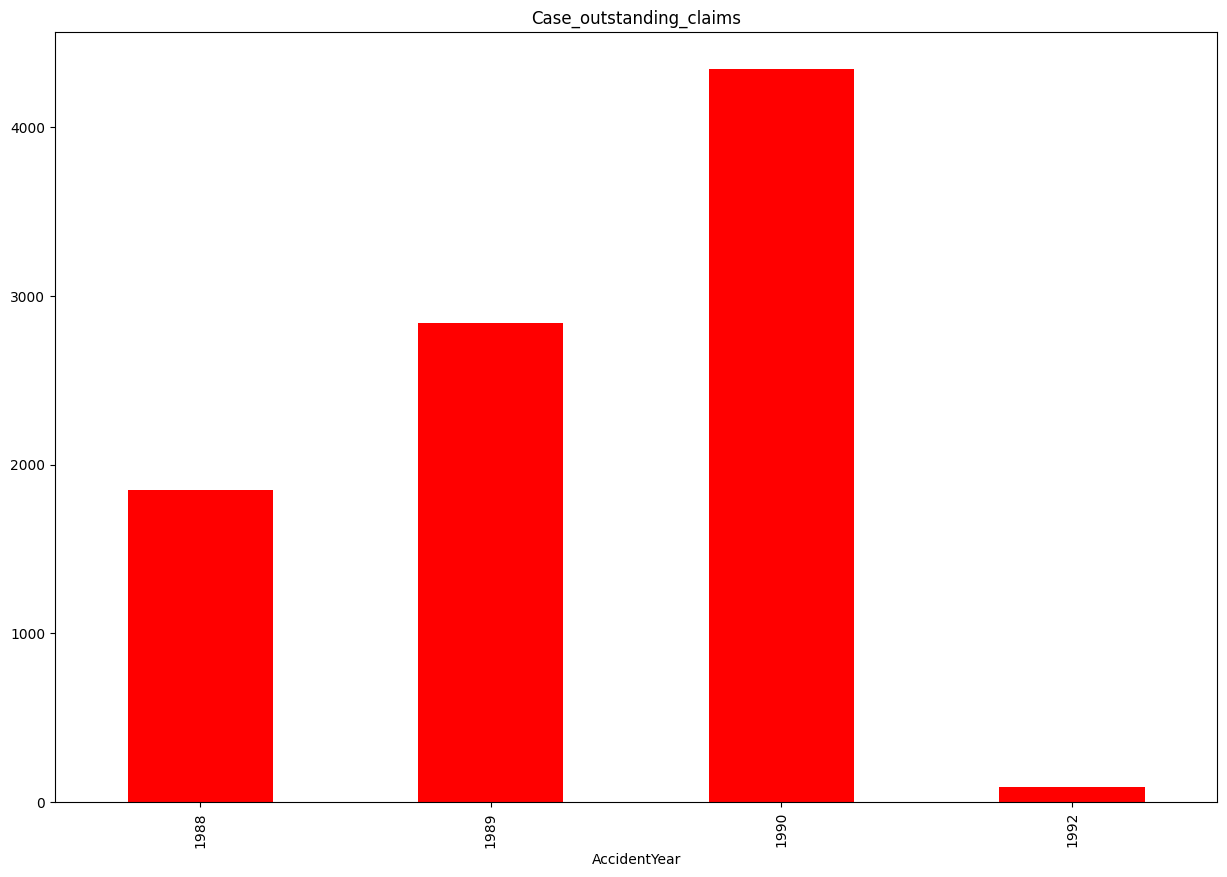



This is the cummulative filled incremental paid claims Triangle
   AccidentYear  12  24  36  48  60  72         84          96         108  \
0          1988   8  24  50  50  50  50  50.000000   50.000000   50.000000   
1          1989  29  59  59  59  59  59  59.000000   59.000000   59.000000   
2          1990  32  70  70  70  84  88  90.000000  100.000000  100.000000   
3          1992   1   2   2   2   2   2   2.013869    2.083913    2.083913   

          120  
0   50.000000  
1   59.000000  
2  100.000000  
3    2.083913  


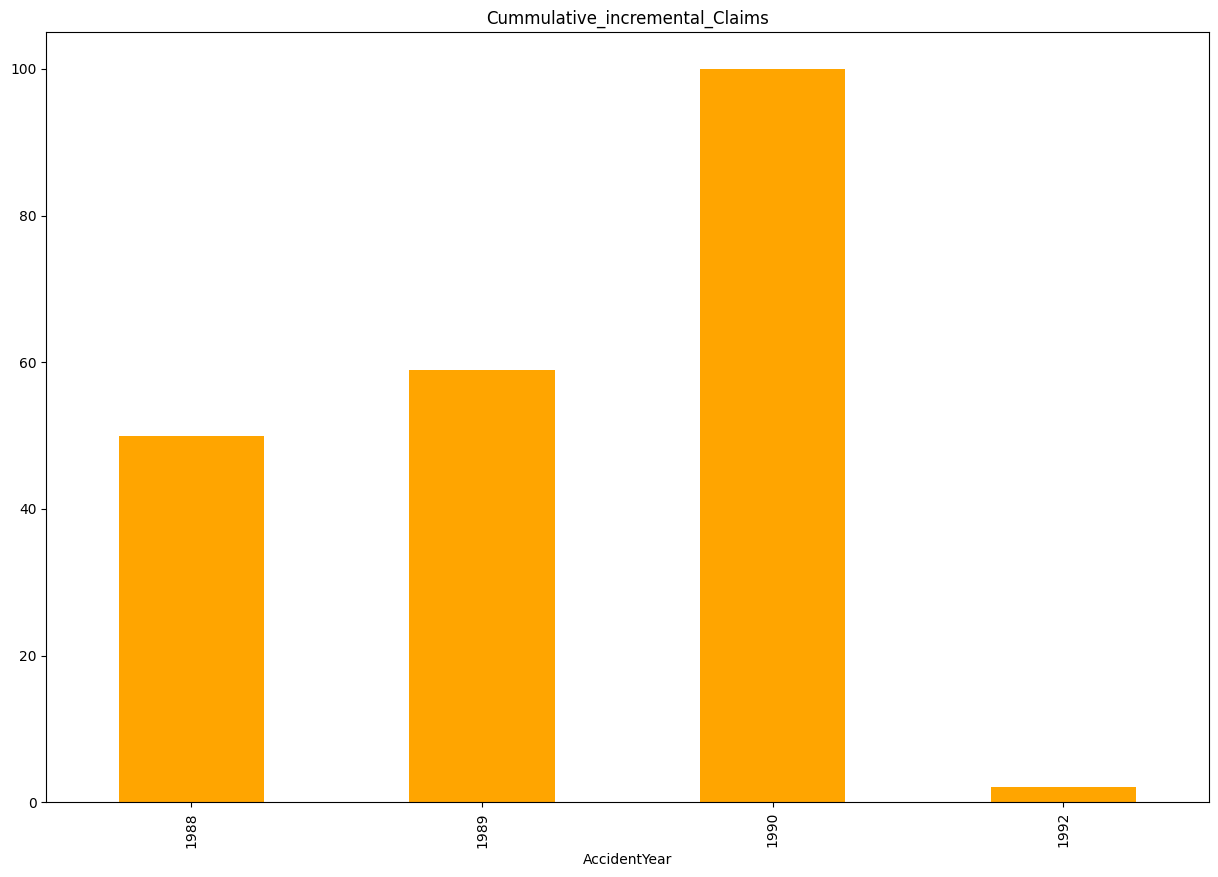

212
211.08391322507228
----------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------
The name of the dataset is: Overseas Partners Us Reins Co
the final dataset looks like this:
   AccidentYear  12   24    36    48    60    72    84    96   108   120
0          1995   6   91   200   292   365   444   444   444   444   444
1          1996  76  774  1368  2053  3350  3350  3350  3350  3350  3350
2          1997  45  152   433  1436  1436  1436  1437  1437  1437  1437
----------------------------------------------------------------------------------------------------------------------------------------------------


This is the case_outstanding Triangle
   AccidentYear    12      24      36
0          1995   348   995.0  2008.0
1          1996  1952  5846.0

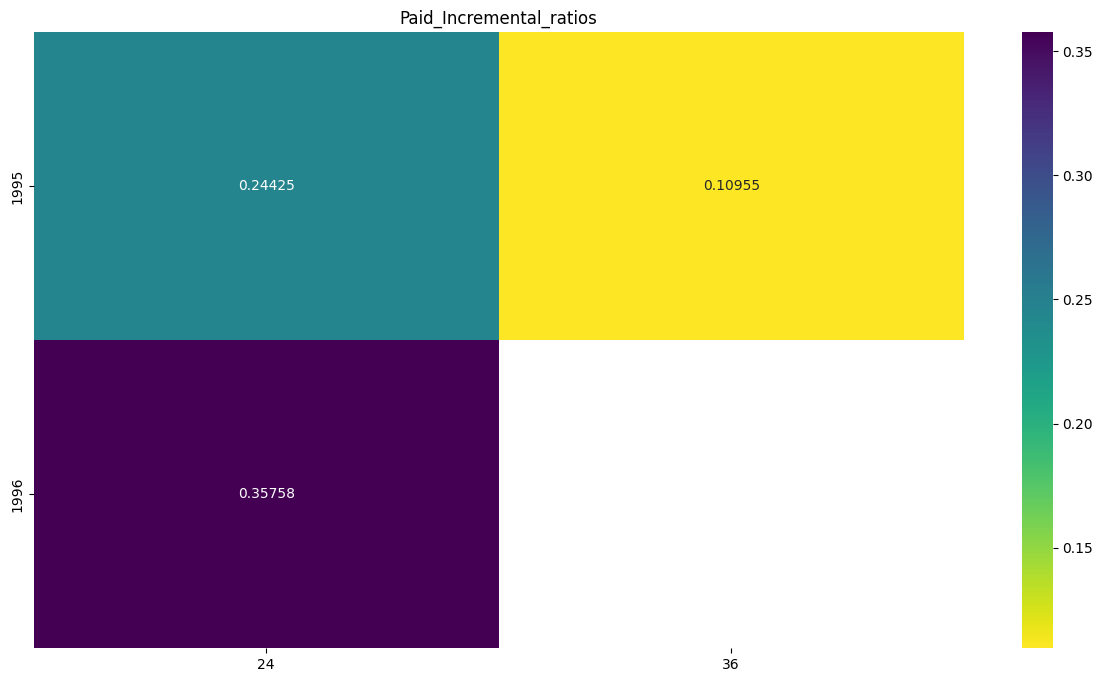



This is the case_ratio_Triangle
   AccidentYear        24       36
0          1995  2.859195  2.01809
1          1996  2.994877      NaN
----------------------------------------------------------------------------------------------------------------------------------------------------


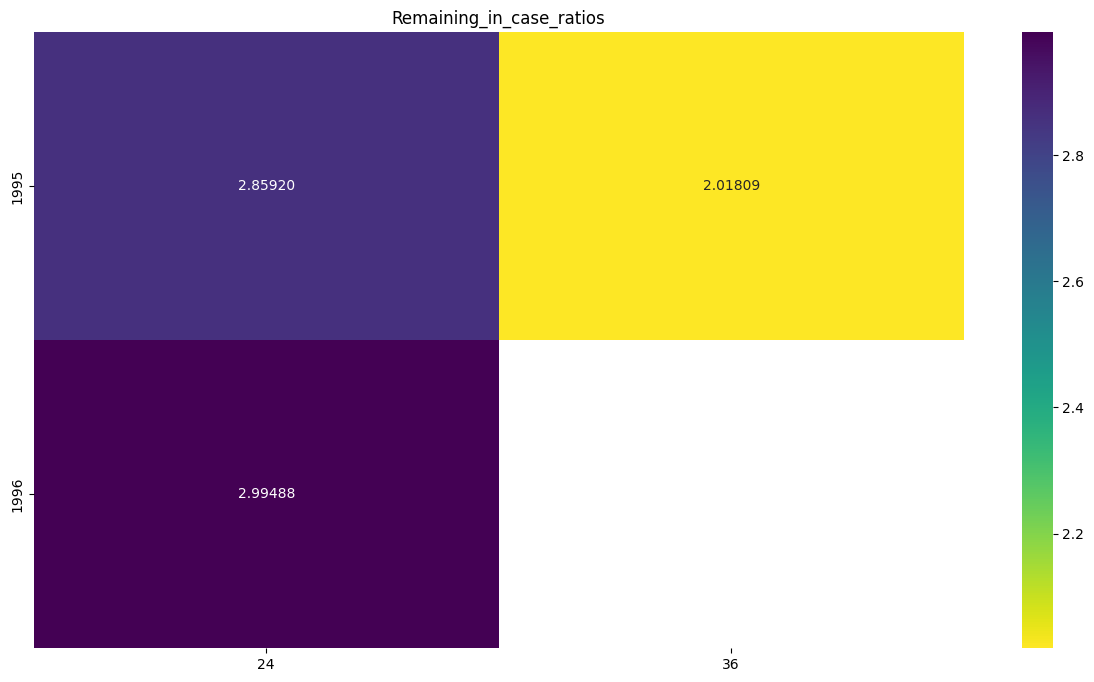



This is the case_out measures or averages Triangle
       Mean    Median  Months
0  2.927036  2.927036      24
1  2.018090  2.018090      36
----------------------------------------------------------------------------------------------------------------------------------------------------


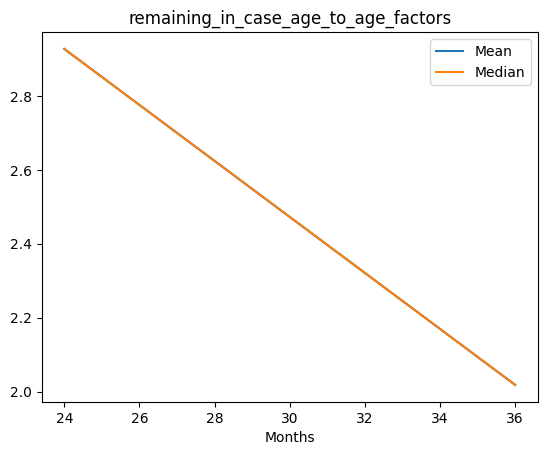



This is the paid incremental measures or averages Triangle
       Mean    Median  Months
0  0.300917  0.300917      24
1  0.109548  0.109548      36
----------------------------------------------------------------------------------------------------------------------------------------------------


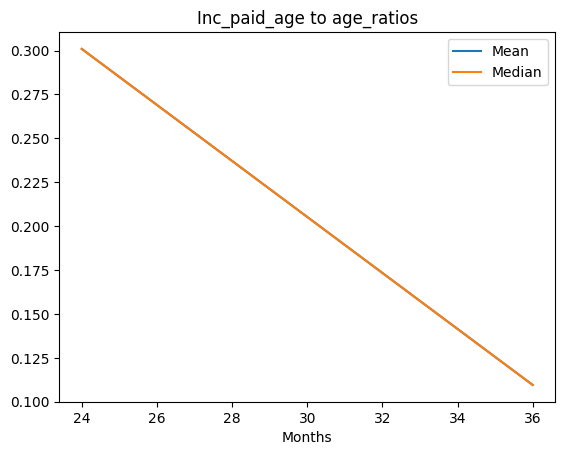



This is the filled case_outstanding Triangle
   AccidentYear    12        24         36
0          1995   348   995.000   2008.000
1          1996  1952  5846.000  11797.757
2          1997  1034  3026.555   6107.862
----------------------------------------------------------------------------------------------------------------------------------------------------


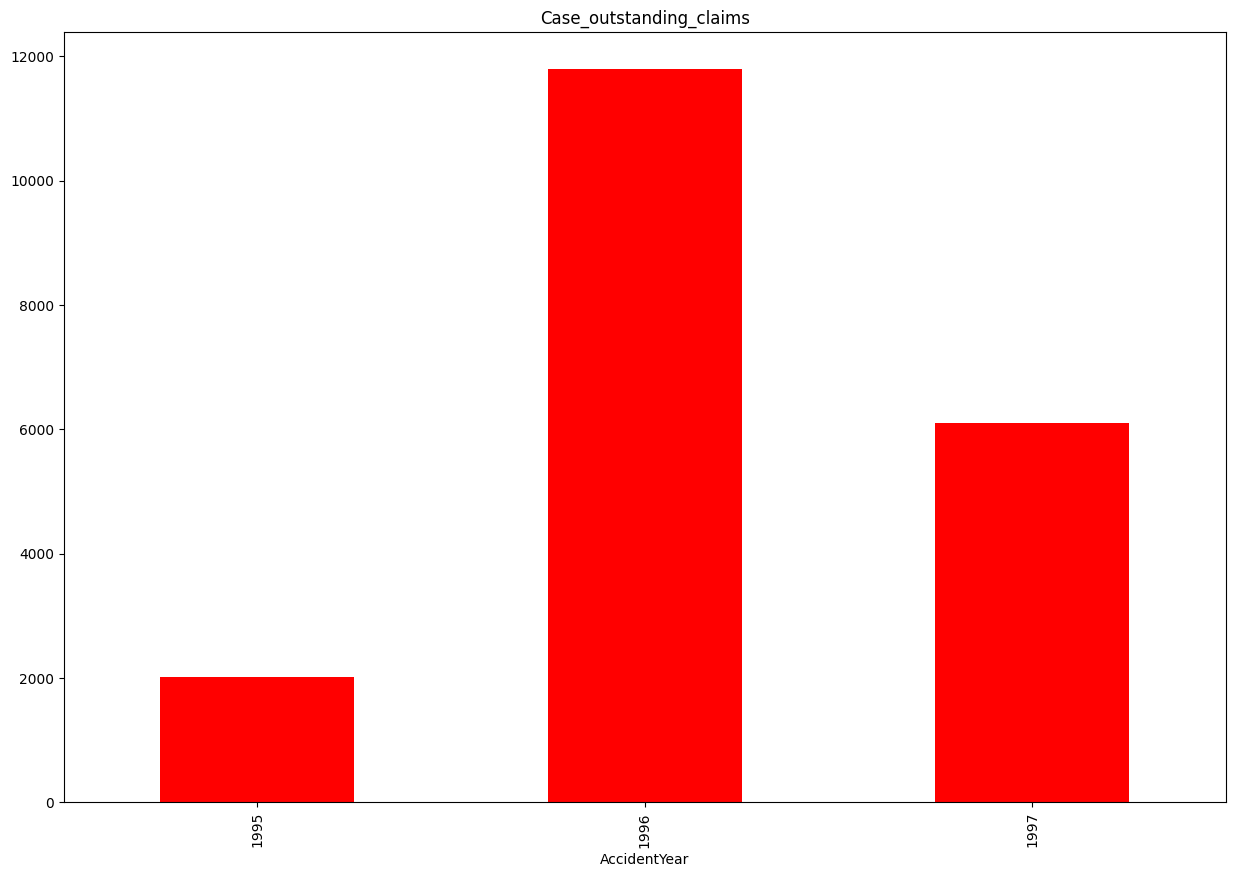



This is the cummulative filled incremental paid claims Triangle
   AccidentYear  12          24           36
0          1995   6   91.000000   200.000000
1          1996  76  774.000000  1414.416080
2          1997  45  356.148613   687.700869


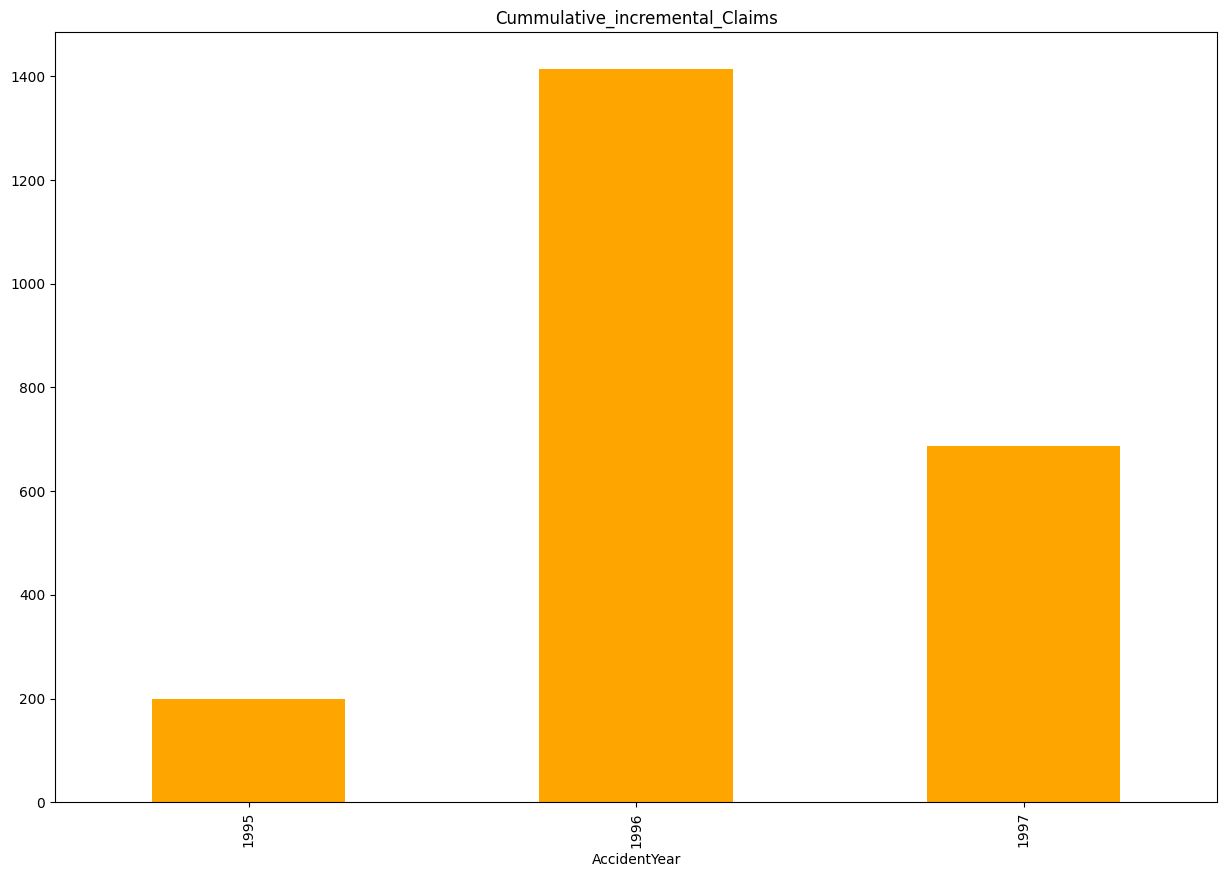

2001
2302.1169493647812
----------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------
The name of the dataset is: Hyundai Marine & Fire Ins Co Ltd
the final dataset looks like this:
   AccidentYear  12  24  36  48  60  72  84  96  108  120
0          1994   0   0   0   1   2   2  61  62   62   62
1          1995   0   2   1   2   8   8   8   8    8    8
2          1996   0   2  15  16  16  16  16  16   16   16
3          1997   8  21   7   9   8   8   8   8    8    8
----------------------------------------------------------------------------------------------------------------------------------------------------


This is the case_outstanding Triangle
   AccidentYear  12     24     36     48
0          1994  26   85.0  171.0  292.0
1          1995  46  

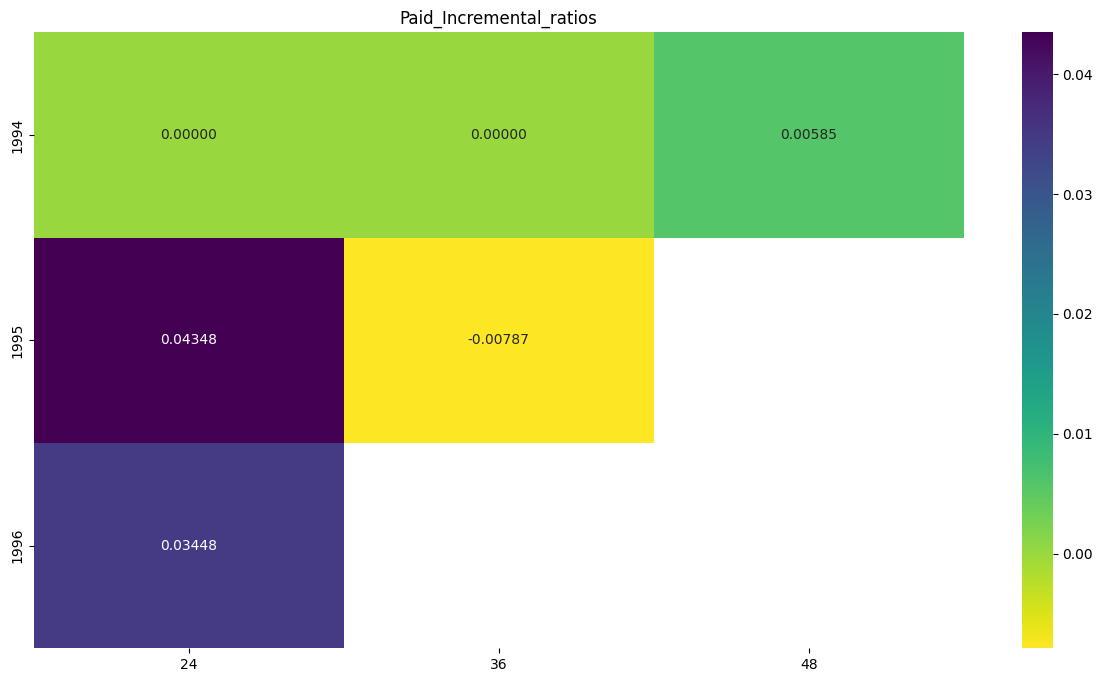



This is the case_ratio_Triangle
   AccidentYear        24        36        48
0          1994  3.269231  2.011765  1.707602
1          1995  2.760870  1.905512       NaN
2          1996  2.844828       NaN       NaN
----------------------------------------------------------------------------------------------------------------------------------------------------


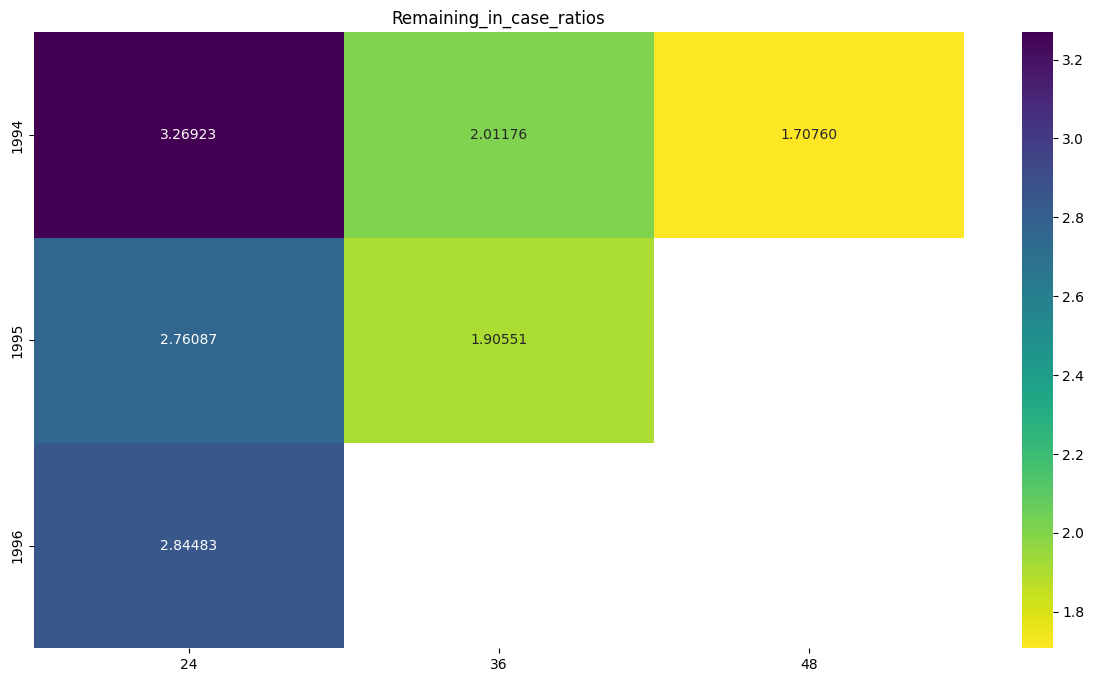



This is the case_out measures or averages Triangle
       Mean    Median  Months
0  2.958309  2.844828      24
1  1.958638  1.958638      36
2  1.707602  1.707602      48
----------------------------------------------------------------------------------------------------------------------------------------------------


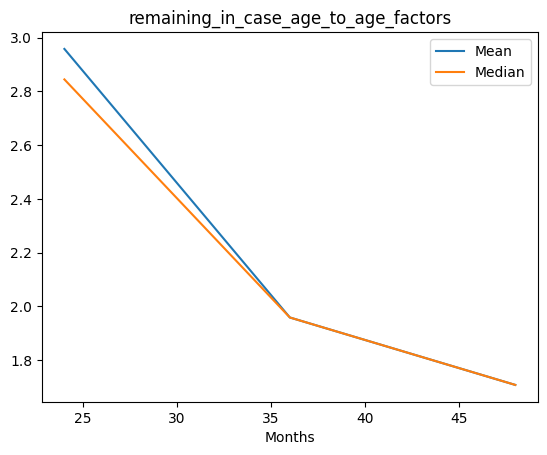



This is the paid incremental measures or averages Triangle
       Mean    Median  Months
0  0.025987  0.034483      24
1 -0.003937 -0.003937      36
2  0.005848  0.005848      48
----------------------------------------------------------------------------------------------------------------------------------------------------


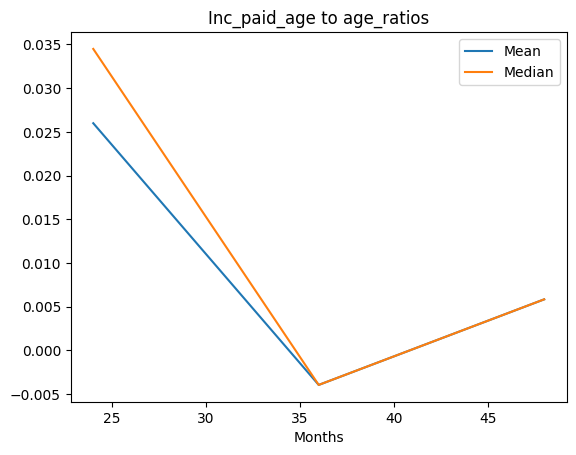



This is the filled case_outstanding Triangle
   AccidentYear  12       24       36       48
0          1994  26   85.000  171.000  292.000
1          1995  46  127.000  242.000  413.240
2          1996  58  165.000  323.175  551.854
3          1997  31   91.708  179.623  306.725
----------------------------------------------------------------------------------------------------------------------------------------------------


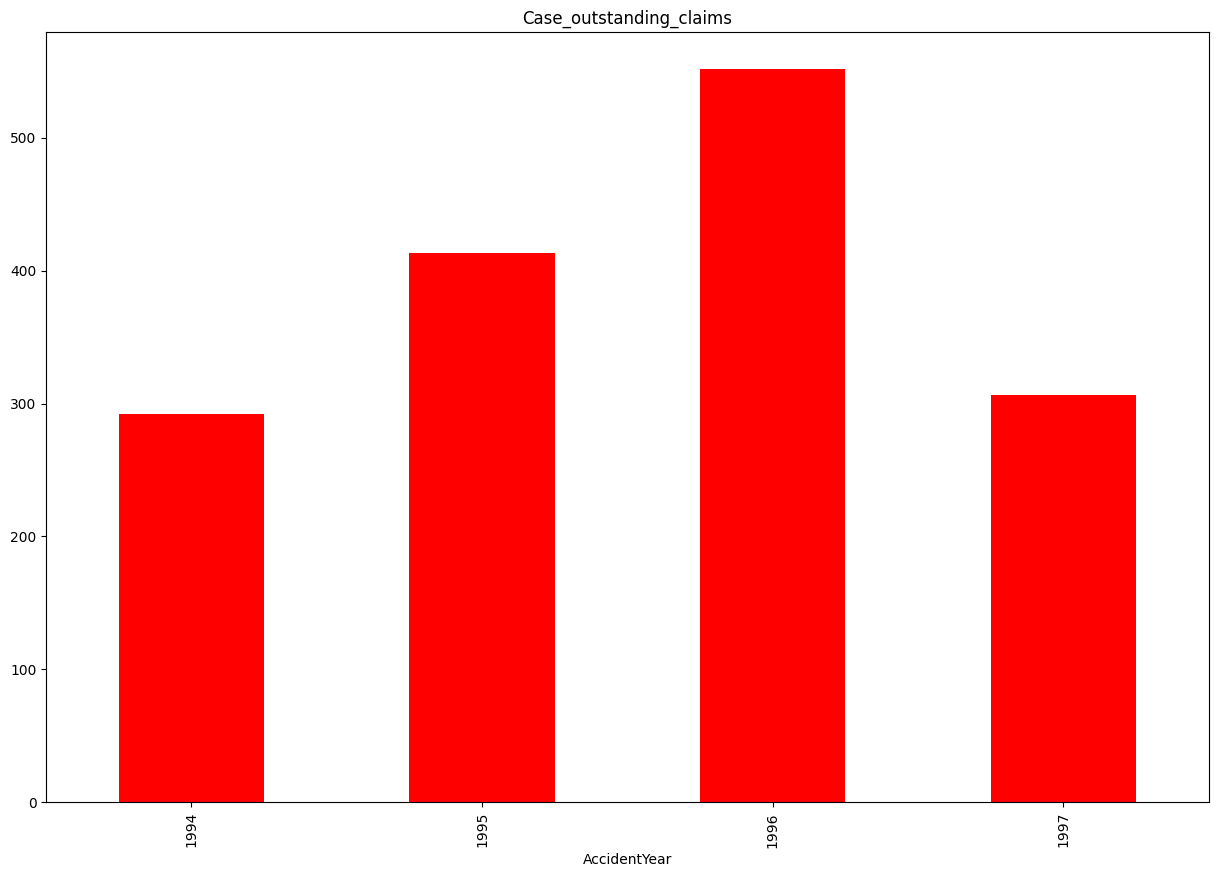



This is the cummulative filled incremental paid claims Triangle
   AccidentYear  12        24        36        48
0          1994   0  0.000000  0.000000  1.000000
1          1995   0  2.000000  1.000000  2.415205
2          1996   0  2.000000  1.350394  3.240306
3          1997   8  8.805597  8.444542  9.494969


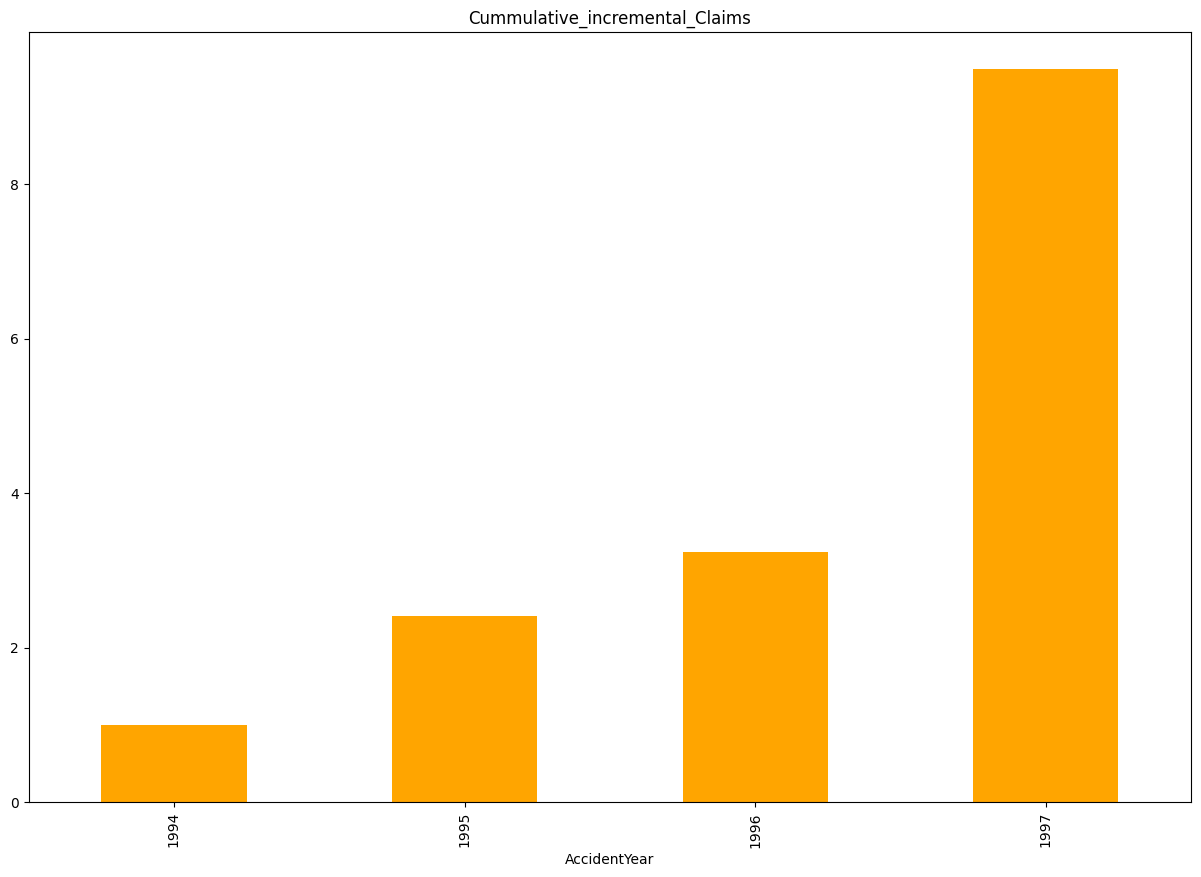

28
16.15047964372559
----------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------
The name of the dataset is: Martingale Natl Ins Co
the final dataset looks like this:
   AccidentYear    12    24    36    48    60    72    84    96   108   120
0          1994   214   839  1193  1193  1193  1193  1193  1193  1193  1193
1          1995   743  1274  1441  1441  1468  1468  1469  1469  1469  1469
2          1996   726  1412  1764  1764  1764  1766  1766  1766  1766  1766
3          1997  1014  1722  1724  1724  1728  1728  1728  1728  1728  1728
----------------------------------------------------------------------------------------------------------------------------------------------------


This is the case_outstanding Triangle
   AccidentYear   12      

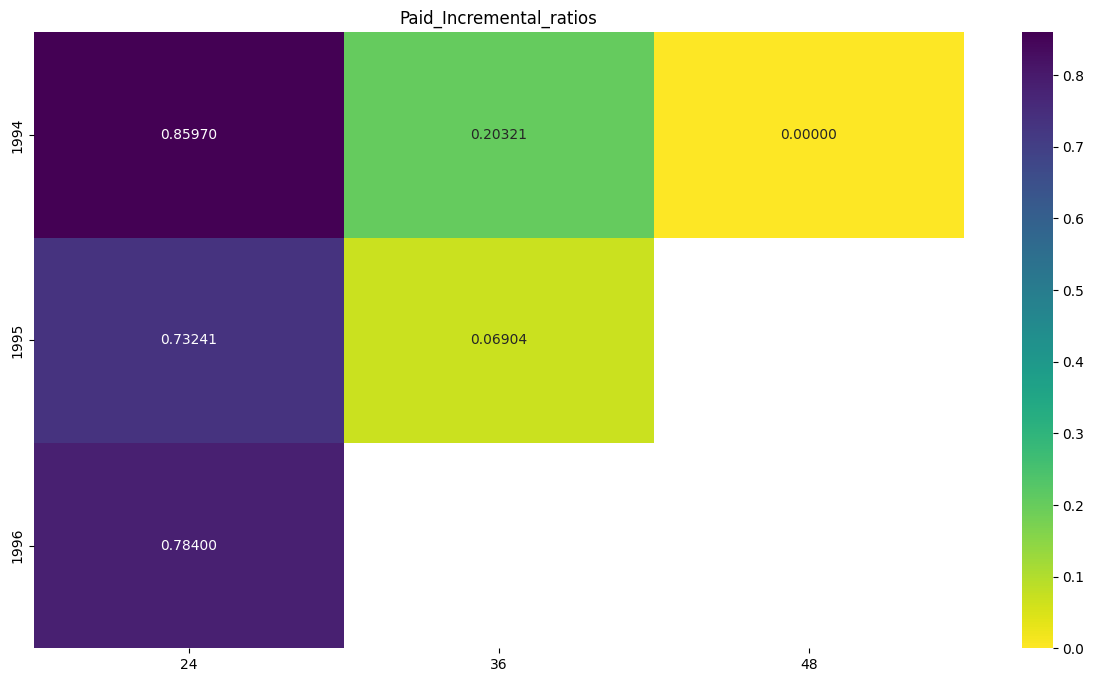



This is the case_ratio_Triangle
   AccidentYear        24        36        48
0          1994  2.396149  2.067164  1.848375
1          1995  3.336552  2.229020       NaN
2          1996  3.228571       NaN       NaN
----------------------------------------------------------------------------------------------------------------------------------------------------


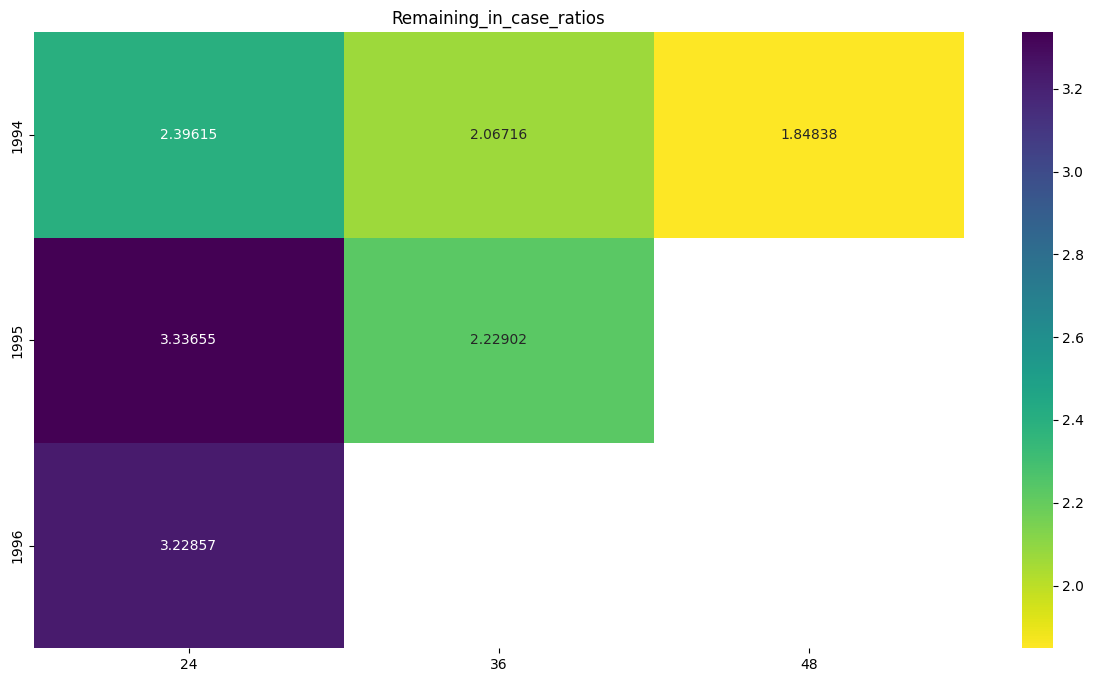



This is the case_out measures or averages Triangle
       Mean    Median  Months
0  2.987091  3.228571      24
1  2.148092  2.148092      36
2  1.848375  1.848375      48
----------------------------------------------------------------------------------------------------------------------------------------------------


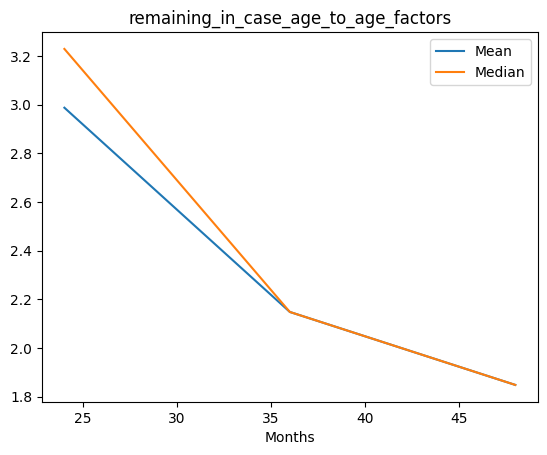



This is the paid incremental measures or averages Triangle
       Mean    Median  Months
0  0.792037  0.784000      24
1  0.136126  0.136126      36
2  0.000000  0.000000      48
----------------------------------------------------------------------------------------------------------------------------------------------------


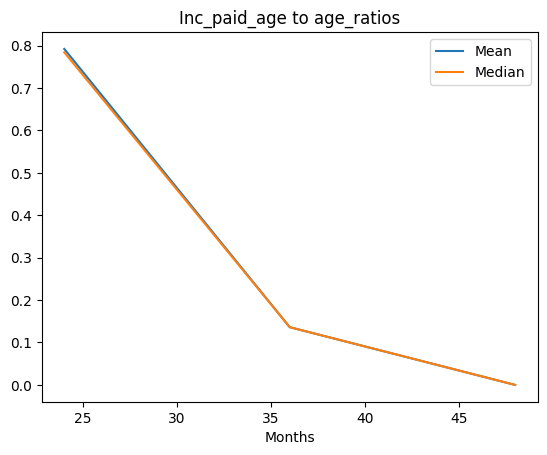



This is the filled case_outstanding Triangle
   AccidentYear   12        24        36         48
0          1994  727  1742.000  3601.000   6656.000
1          1995  725  2419.000  5392.000   9966.440
2          1996  875  2825.000  6068.361  11216.610
3          1997  833  2488.246  5344.982   9879.534
----------------------------------------------------------------------------------------------------------------------------------------------------


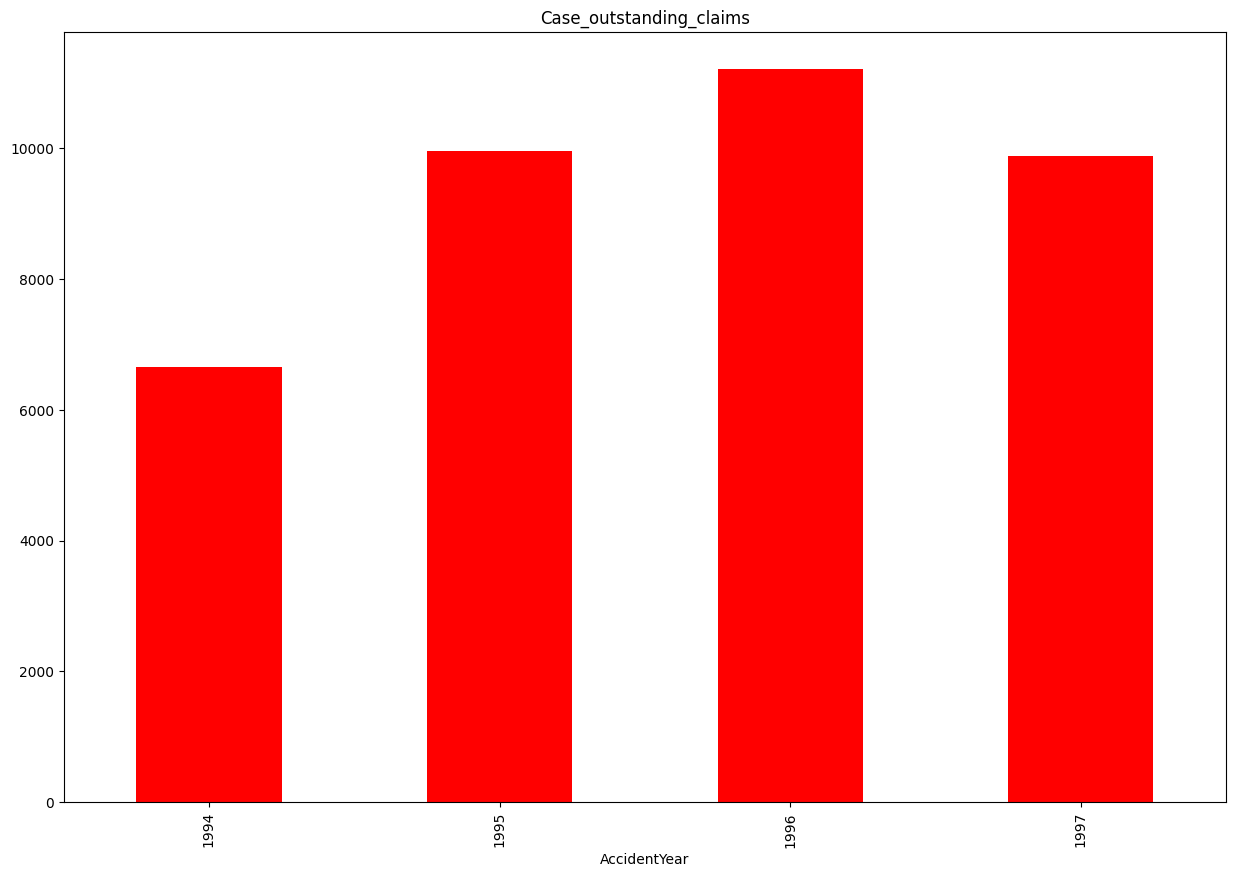



This is the cummulative filled incremental paid claims Triangle
   AccidentYear    12           24           36           48
0          1994   214   839.000000  1193.000000  1193.000000
1          1995   743  1274.000000  1441.000000  1441.000000
2          1996   726  1412.000000  1796.555227  1796.555227
3          1997  1014  1673.766871  2012.481209  2012.481209


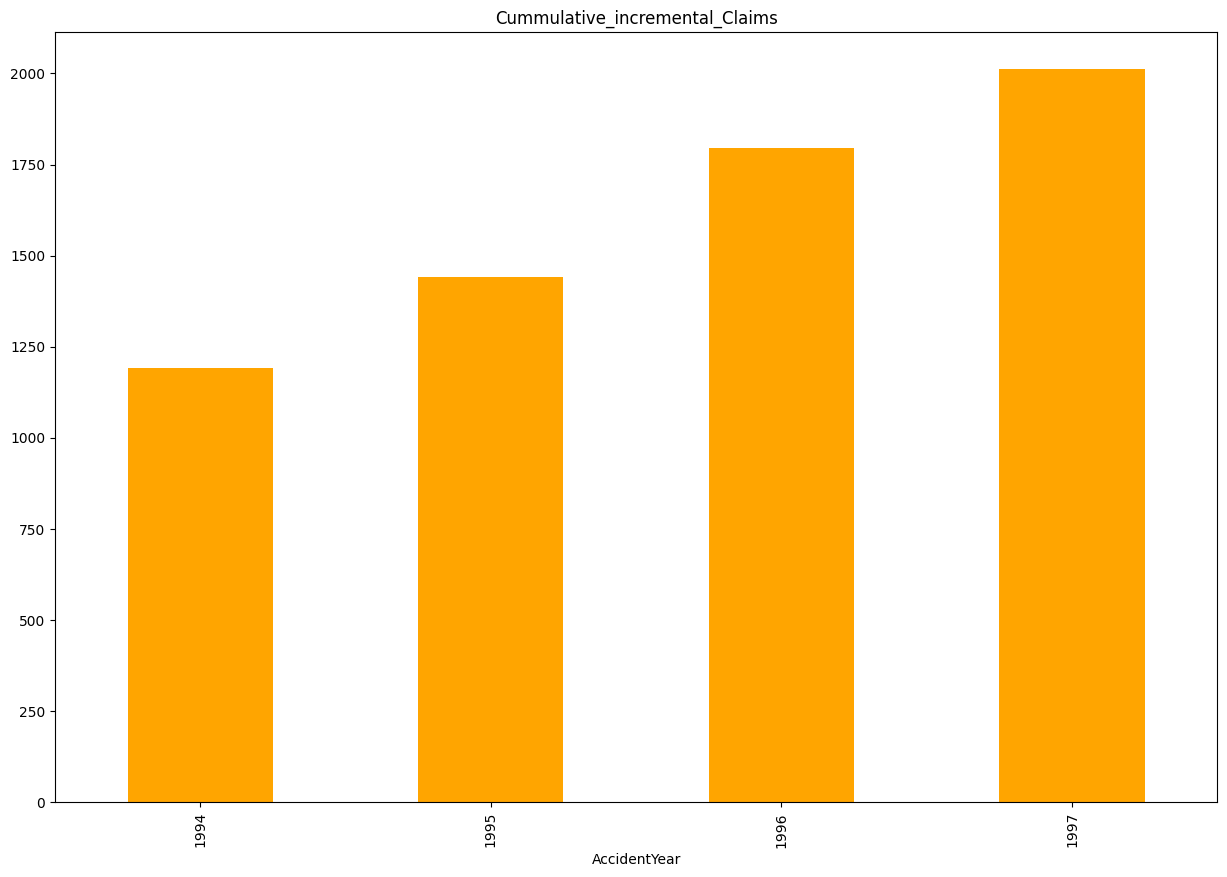

6122
6443.036435188566
----------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------
The name of the dataset is: Proformance Ins Co (The)
the final dataset looks like this:
   AccidentYear   12    24    36    48    60    72    84    96   108   120
0          1995   12    67   101   184   196   250   250   251   251   266
1          1996  249   538  1121  1757  2003  2023  2119  2191  2185  2315
2          1997  418  1149  1987  2946  3730  3961  4045  4213  4279  4301
----------------------------------------------------------------------------------------------------------------------------------------------------


This is the case_outstanding Triangle
   AccidentYear    12      24     36
0          1995   181   485.0  985.0
1          1996   998  3202.

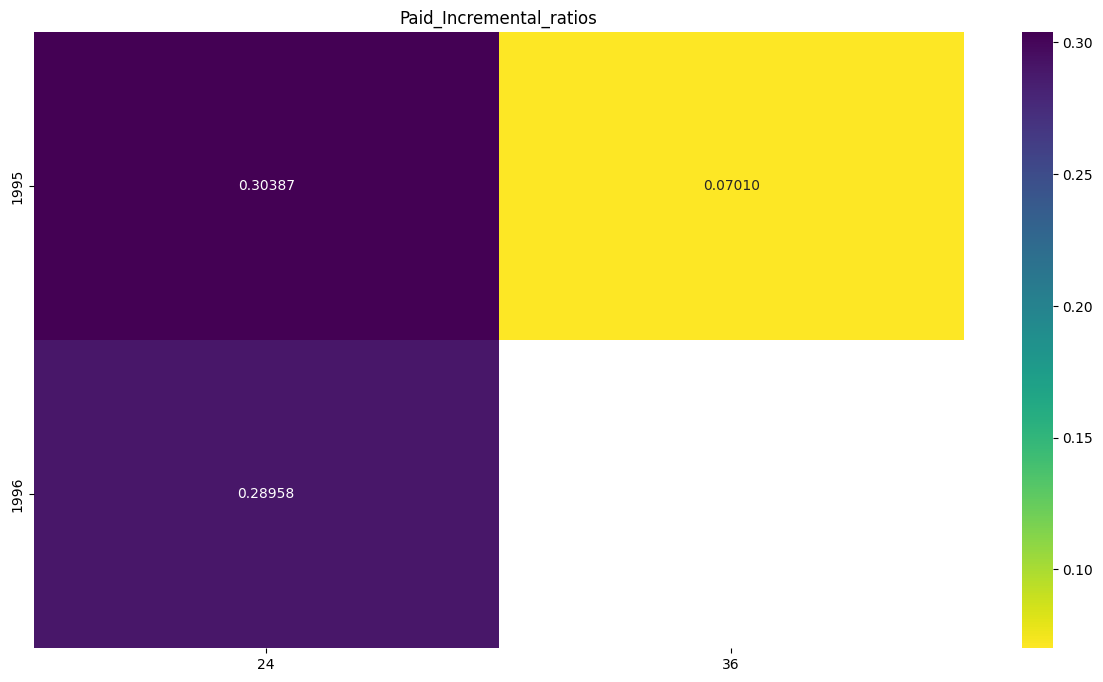



This is the case_ratio_Triangle
   AccidentYear        24        36
0          1995  2.679558  2.030928
1          1996  3.208417       NaN
----------------------------------------------------------------------------------------------------------------------------------------------------


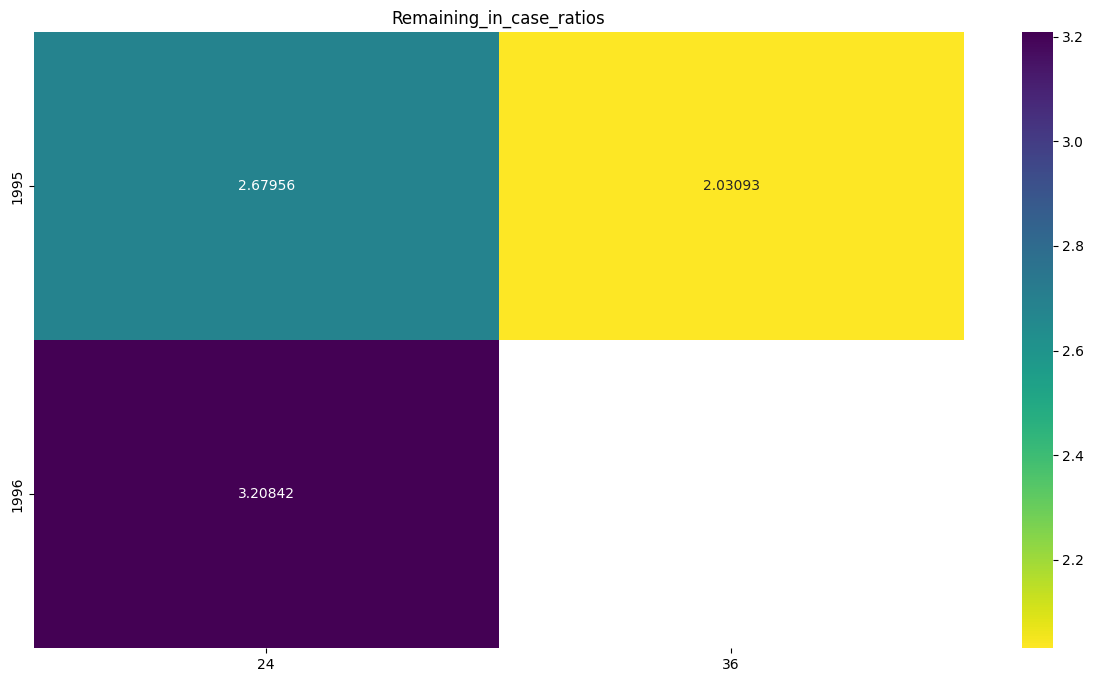



This is the case_out measures or averages Triangle
       Mean    Median  Months
0  2.943987  2.943987      24
1  2.030928  2.030928      36
----------------------------------------------------------------------------------------------------------------------------------------------------


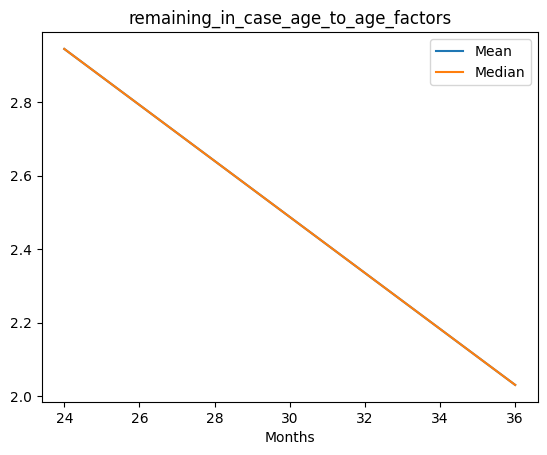



This is the paid incremental measures or averages Triangle
       Mean    Median  Months
0  0.296723  0.296723      24
1  0.070103  0.070103      36
----------------------------------------------------------------------------------------------------------------------------------------------------


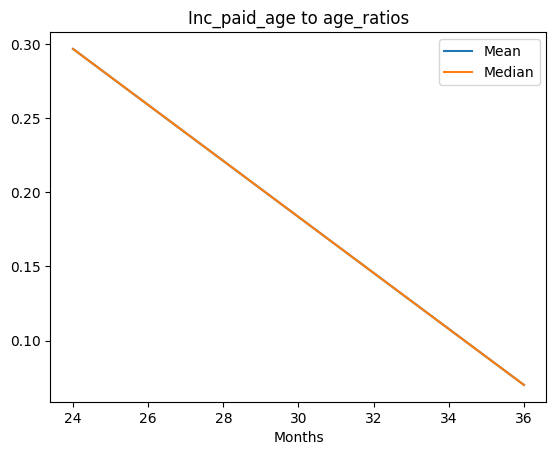



This is the filled case_outstanding Triangle
   AccidentYear    12        24         36
0          1995   181   485.000    985.000
1          1996   998  3202.000   6503.031
2          1997  3062  9014.489  18307.777
----------------------------------------------------------------------------------------------------------------------------------------------------


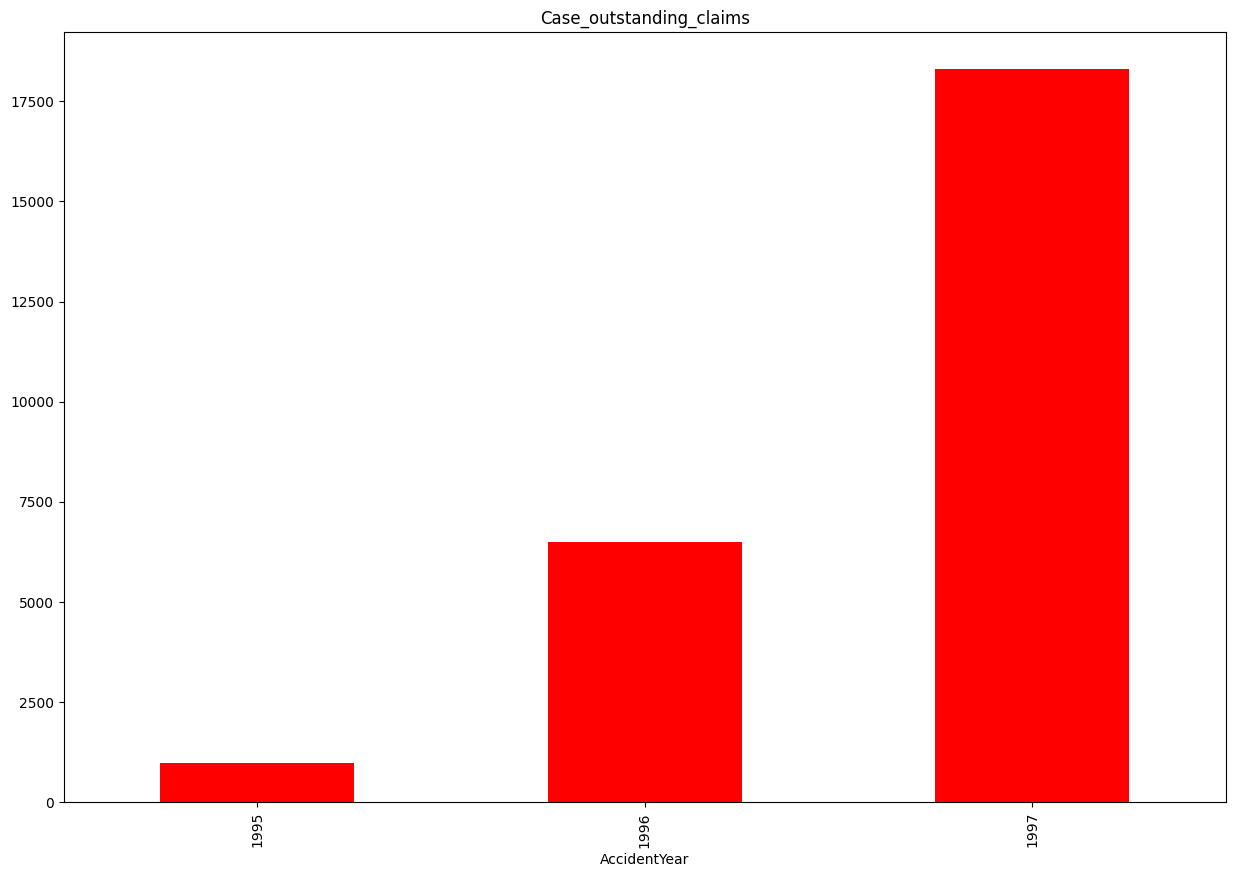



This is the cummulative filled incremental paid claims Triangle
   AccidentYear   12           24           36
0          1995   12    67.000000   101.000000
1          1996  249   538.000000   762.470103
2          1997  418  1326.566686  1958.510245


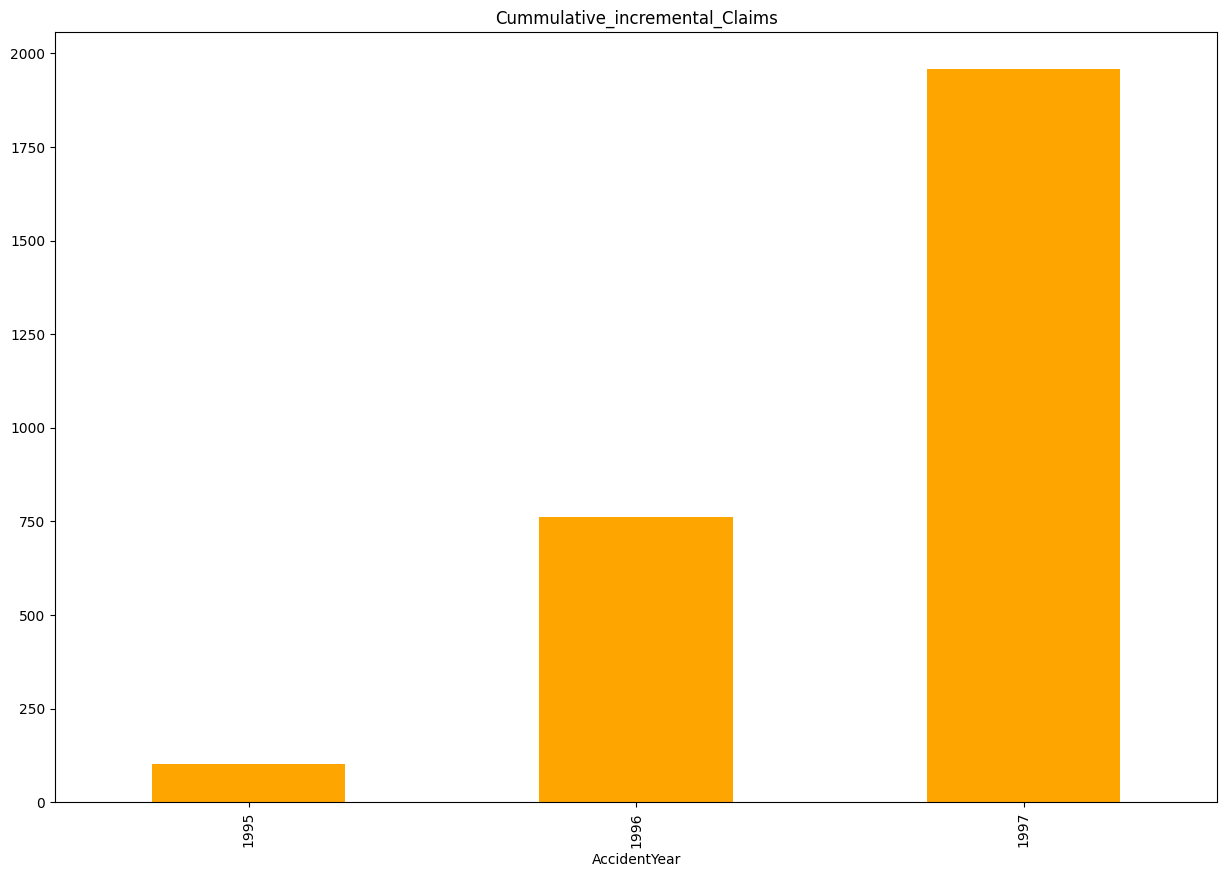

3209
2821.980347713574
----------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------
The name of the dataset is: Catholic Relief Ins Co Of Amer
the final dataset looks like this:
   AccidentYear   12   24   36   48   60   72   84   96  108  120
0          1990   79   31  247  247  247  247  247  247  247  247
1          1991  178  324  324  324  324  324  324  324  324  324
2          1992  216  216  216  216  216  216  216  216  216  216
----------------------------------------------------------------------------------------------------------------------------------------------------


This is the case_outstanding Triangle
   AccidentYear   12    24    36    48    60    72      84      96
0          1990   66   282   529  1023  1764  2752  3987.0  5469.

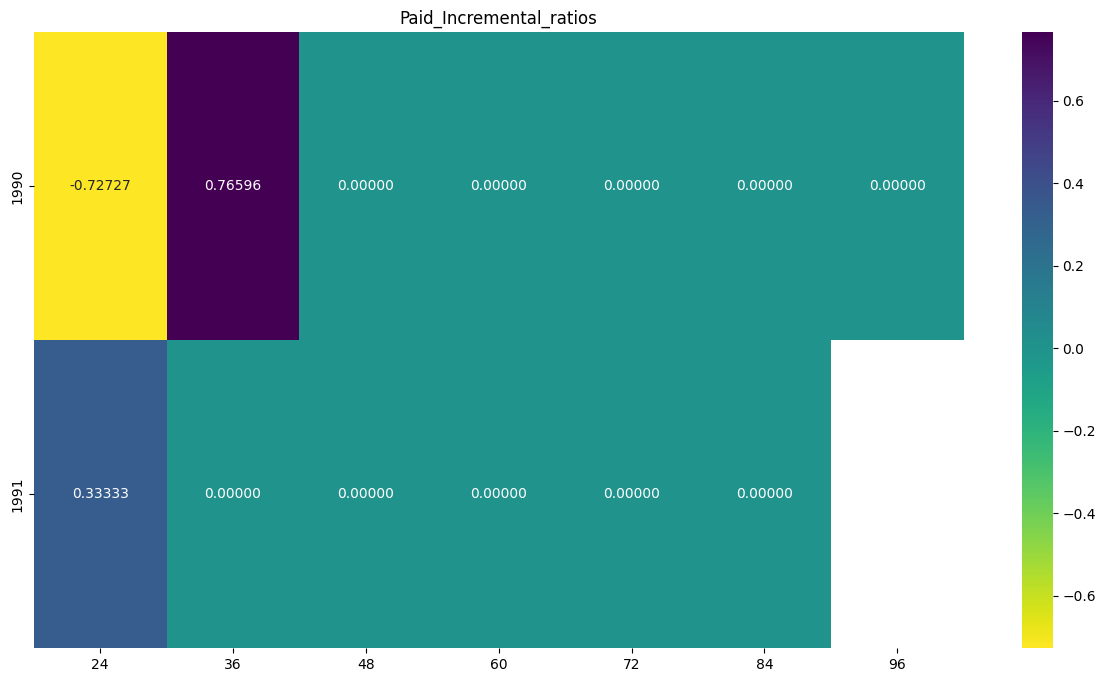



This is the case_ratio_Triangle
   AccidentYear        24        36        48        60        72        84  \
0          1990  4.272727  1.875887  1.933837  1.724340  1.560091  1.448765   
1          1991  2.406393  1.891841  1.633902  1.487416  1.394552  1.330867   

         96  
0  1.371708  
1       NaN  
----------------------------------------------------------------------------------------------------------------------------------------------------


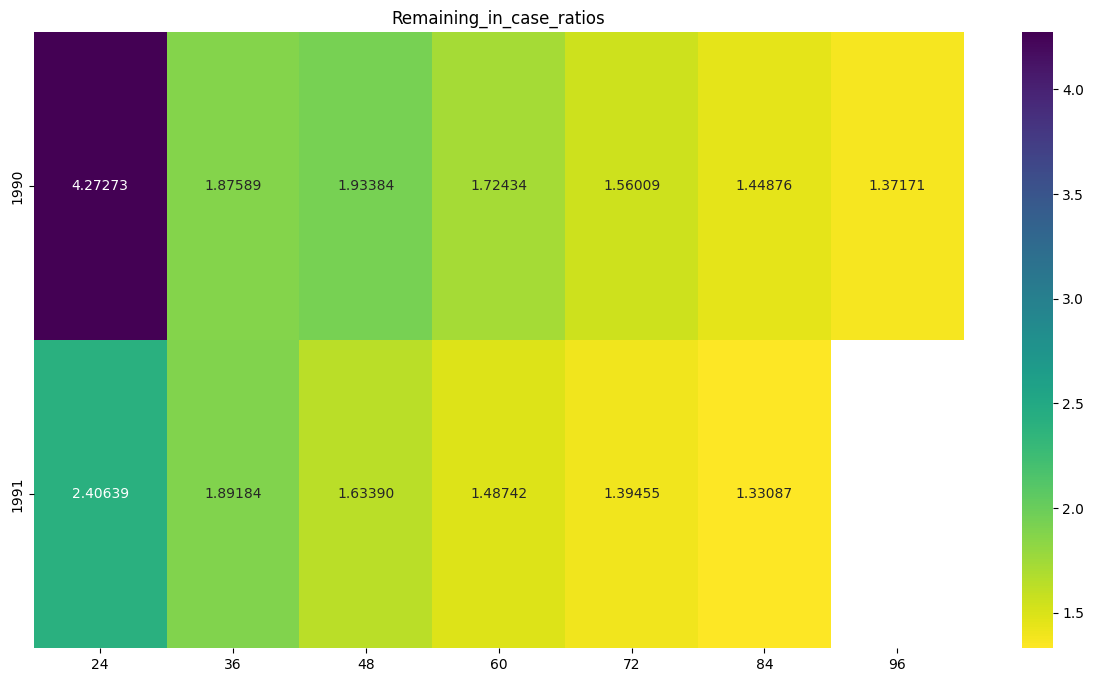



This is the case_out measures or averages Triangle
       Mean    Median  Months
0  3.339560  3.339560      24
1  1.883864  1.883864      36
2  1.783870  1.783870      48
3  1.605878  1.605878      60
4  1.477321  1.477321      72
5  1.389816  1.389816      84
6  1.371708  1.371708      96
----------------------------------------------------------------------------------------------------------------------------------------------------


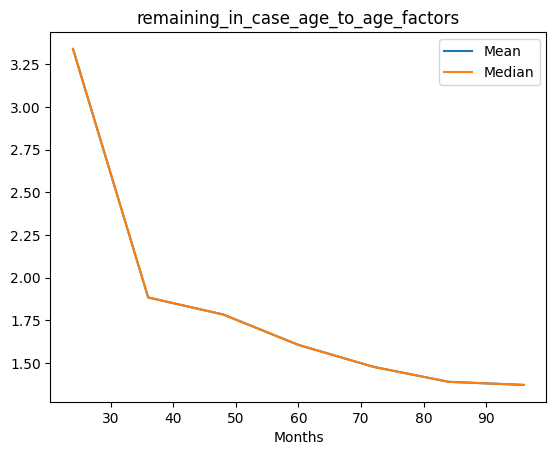



This is the paid incremental measures or averages Triangle
       Mean    Median  Months
0 -0.196970 -0.196970      24
1  0.382979  0.382979      36
2  0.000000  0.000000      48
3  0.000000  0.000000      60
4  0.000000  0.000000      72
5  0.000000  0.000000      84
6  0.000000  0.000000      96
----------------------------------------------------------------------------------------------------------------------------------------------------


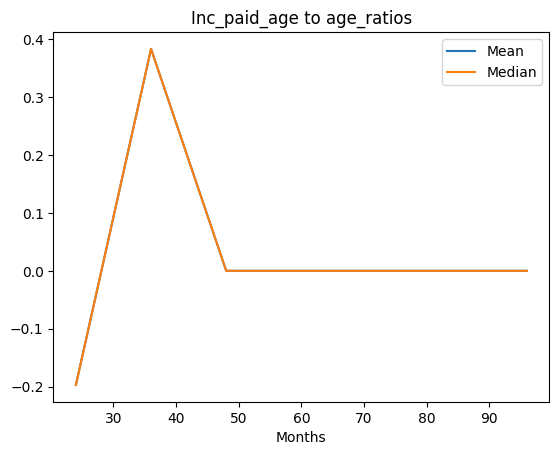



This is the filled case_outstanding Triangle
   AccidentYear   12    24    36    48    60    72        84         96
0          1990   66   282   529  1023  1764  2752  3987.000   5469.000
1          1991  438  1054  1994  3258  4846  6758  8994.000  12337.142
2          1992    0   216   648  1296  2160  3240  4503.003   6176.805
----------------------------------------------------------------------------------------------------------------------------------------------------


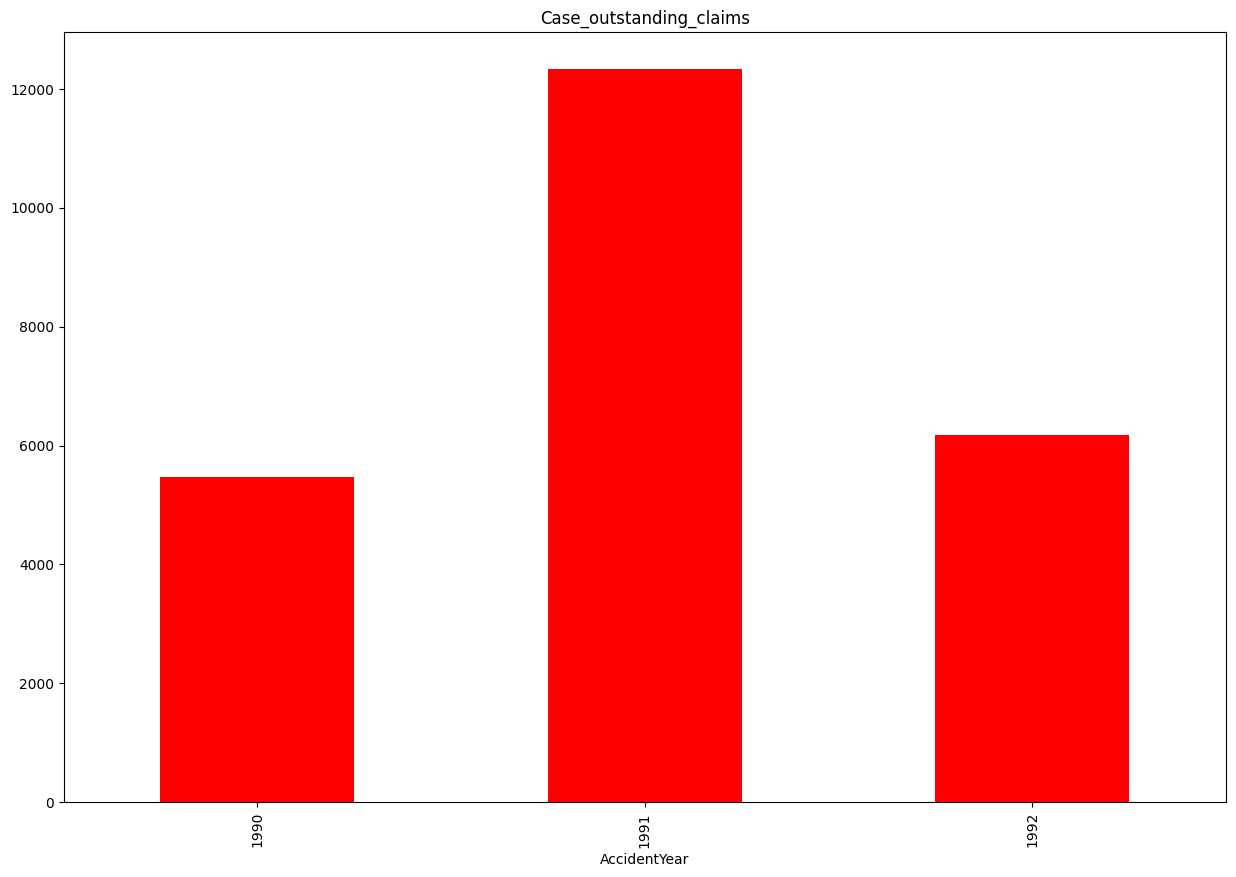



This is the cummulative filled incremental paid claims Triangle
   AccidentYear   12   24   36   48   60   72     84     96
0          1990   79   31  247  247  247  247  247.0  247.0
1          1991  178  324  324  324  324  324  324.0  324.0
2          1992  216  216  216  216  216  216  216.0  216.0


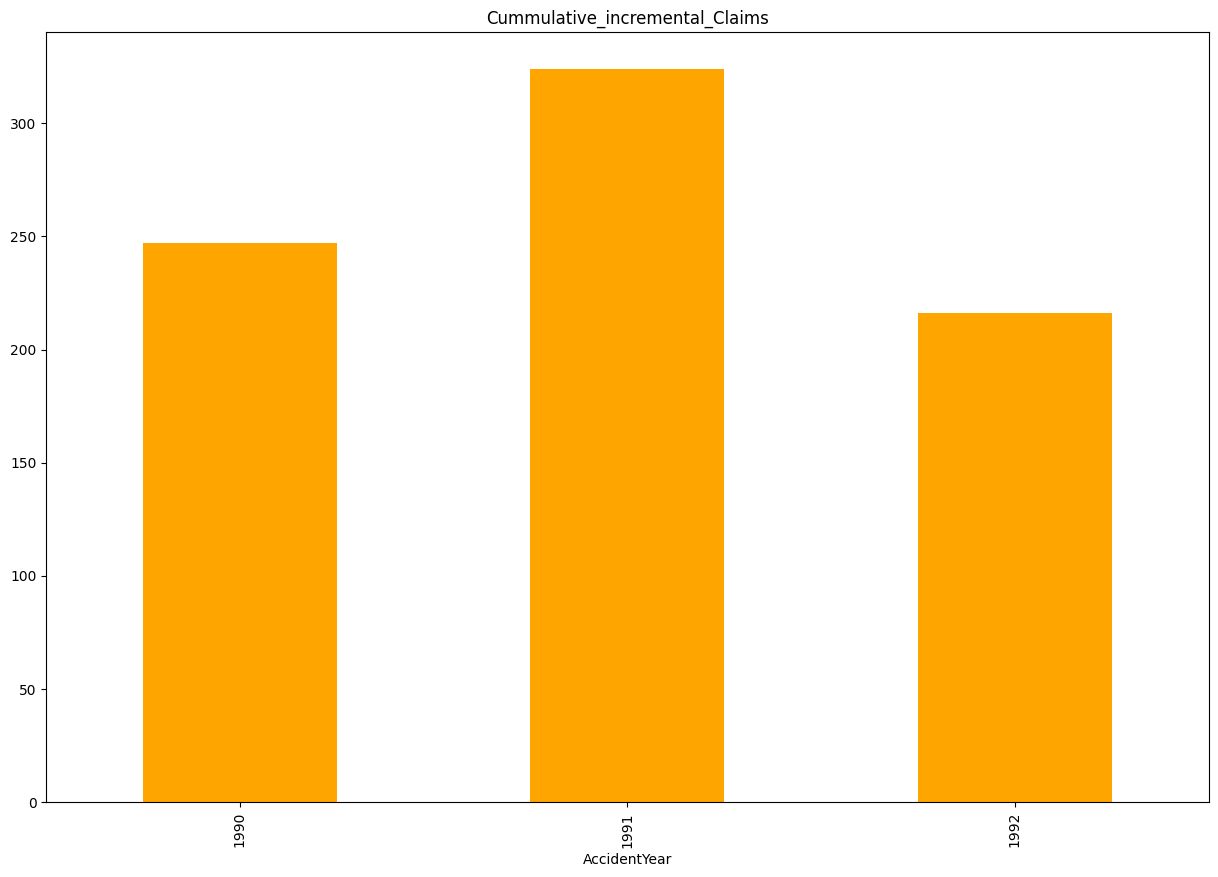

787
787.0
----------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------
The name of the dataset is: First Amer Ins Co
the final dataset looks like this:
   AccidentYear    12      24      36      48      60      72      84      96  \
0          1992     0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1          1993   241   581.0   901.0  1261.0  1603.0  1742.0  1836.0  1805.0   
2          1994  1803  3192.0  4307.0  4844.0  5248.0  5416.0  5455.0  5472.0   
3          1995   836  1722.0  2575.0  2899.0  3168.0  3206.0  2990.0  3004.0   
4          1997    30    29.0    35.0    35.0     NaN     NaN     NaN     NaN   

      108     120  
0     NaN     NaN  
1  1883.0  1958.0  
2  5472.0  5472.0  
3  3004.0  3005.0  
4     NaN     NaN  
----

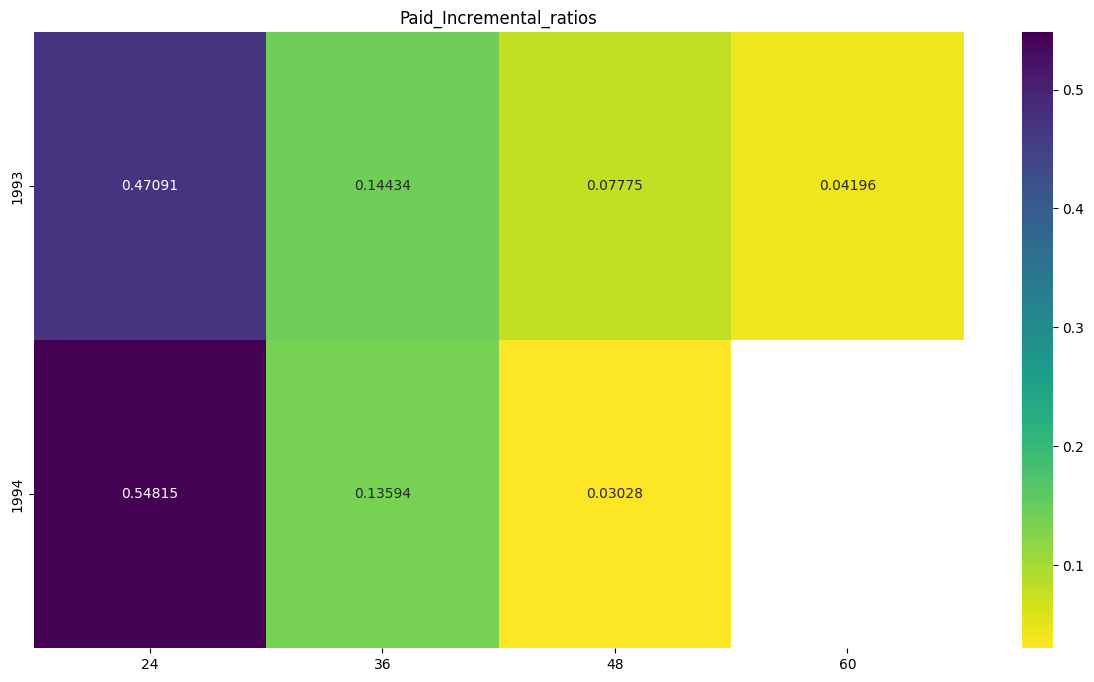



This is the case_ratio_Triangle
   AccidentYear        24        36        48        60
0          1993  3.070637  2.088408  1.760475  1.593424
1          1994  3.236780  2.162277  1.805977       NaN
----------------------------------------------------------------------------------------------------------------------------------------------------


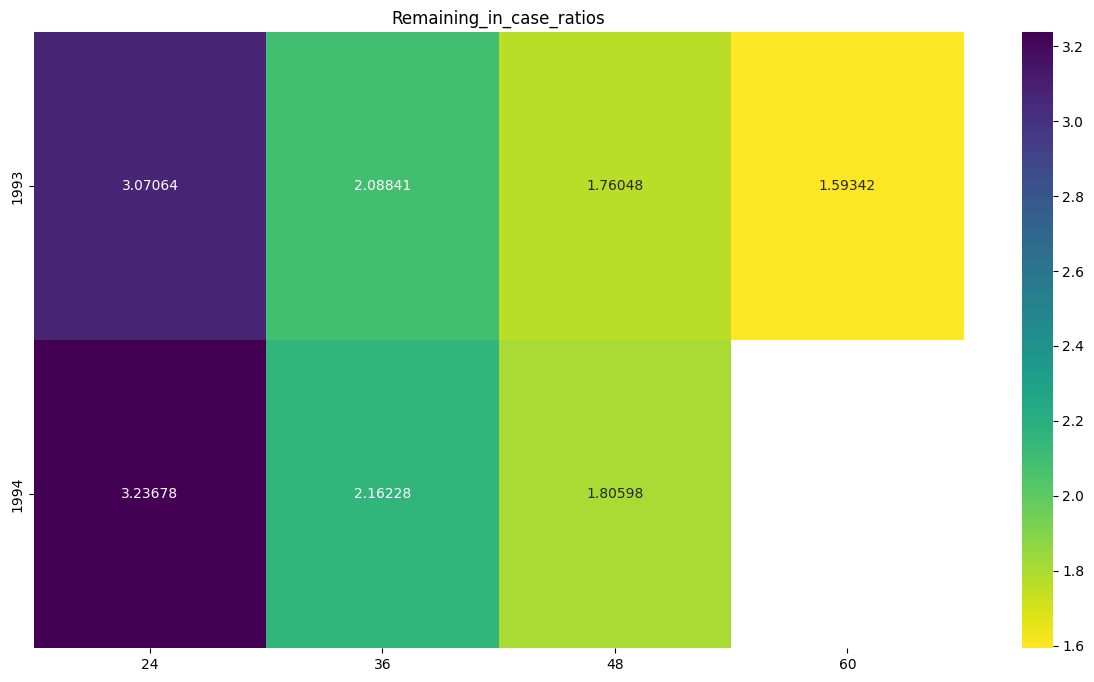



This is the case_out measures or averages Triangle
       Mean    Median  Months
0  3.153708  3.153708      24
1  2.125343  2.125343      36
2  1.783226  1.783226      48
3  1.593424  1.593424      60
----------------------------------------------------------------------------------------------------------------------------------------------------


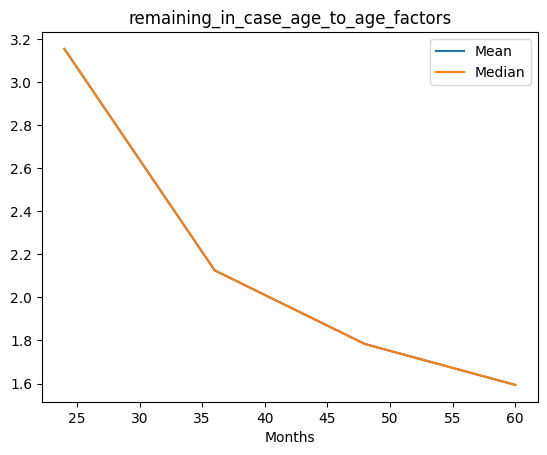



This is the paid incremental measures or averages Triangle
       Mean    Median  Months
0  0.509530  0.509530      24
1  0.140141  0.140141      36
2  0.054016  0.054016      48
3  0.041958  0.041958      60
----------------------------------------------------------------------------------------------------------------------------------------------------


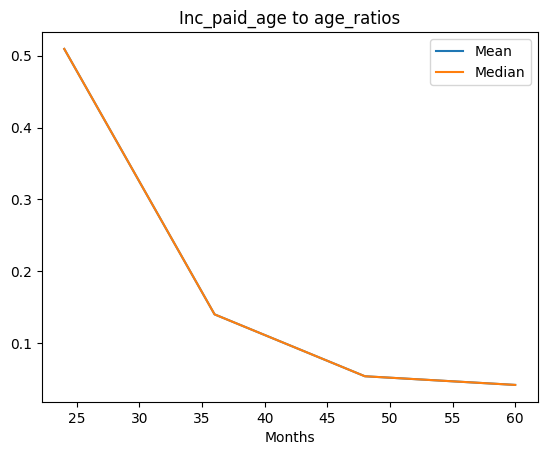



This is the filled case_outstanding Triangle
   AccidentYear    12    24     36         48         60
0          1993   722  2217   4630   8151.000  12988.000
1          1994  2534  8202  17735  32029.000  51035.781
2          1995  2209  7268  15095  26917.797  42891.467
----------------------------------------------------------------------------------------------------------------------------------------------------


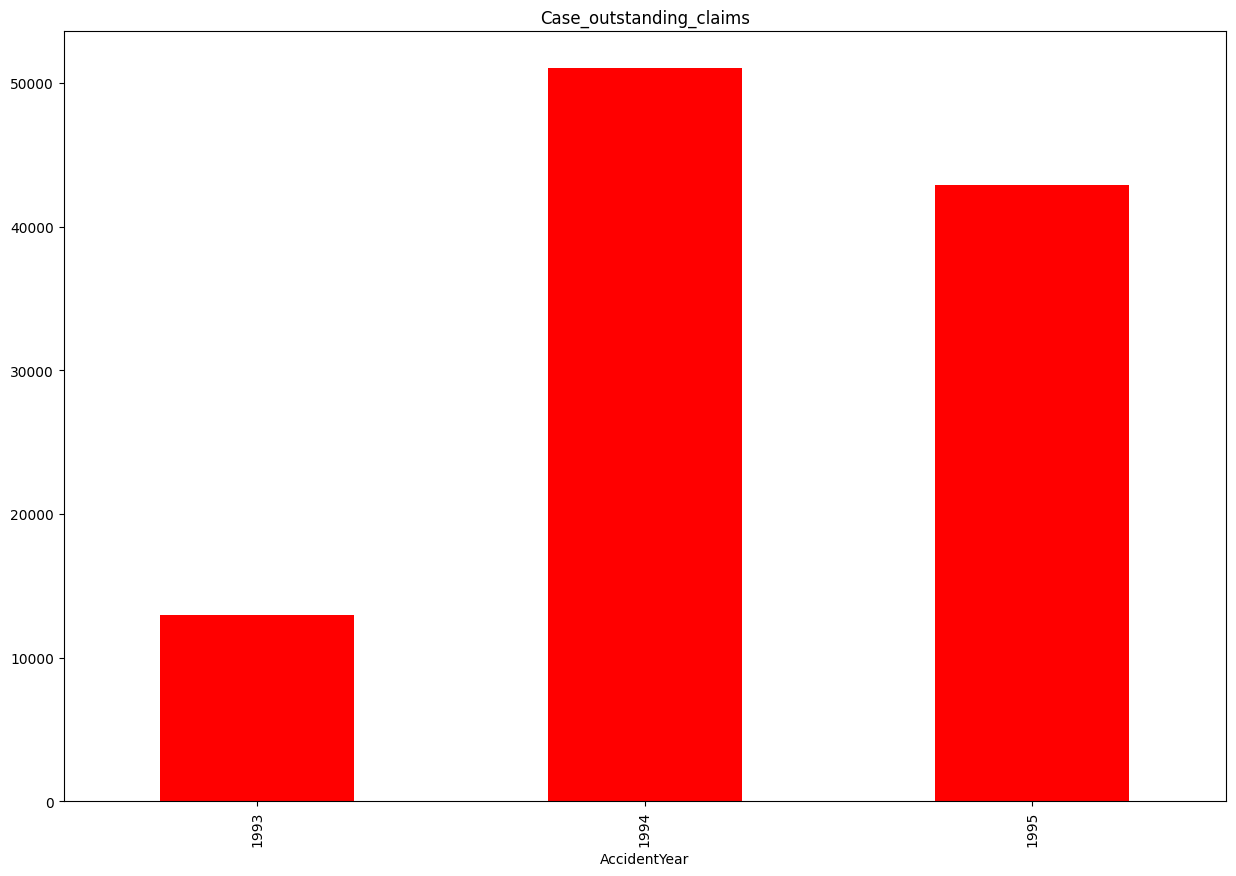



This is the cummulative filled incremental paid claims Triangle
   AccidentYear    12    24    36           48           60
0          1993   241   581   901  1261.000000  1603.000000
1          1994  1803  3192  4307  4844.000000  6187.874126
2          1995   836  1722  2575  3390.378228  4519.796284


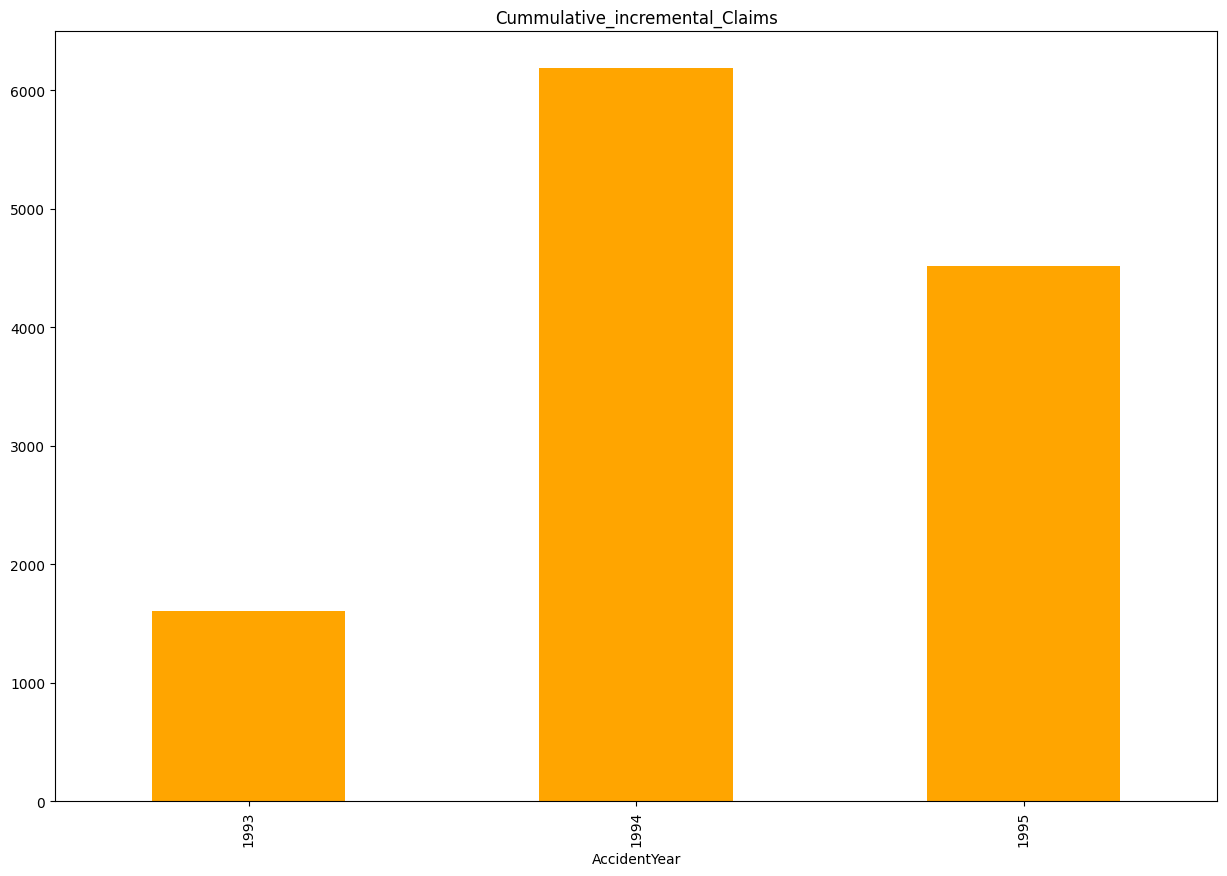

10019.0
12310.6704100657
----------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------
The name of the dataset is: Generali Us Branch
the final dataset looks like this:
   AccidentYear    12      24      36      48      60      72      84      96  \
0          1991     1     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1          1992    38    65.0     NaN     NaN     NaN     NaN     NaN     NaN   
2          1993    54    -4.0    -4.0    -4.0     NaN     NaN     NaN     NaN   
3          1994   302   876.0   944.0   984.0  1024.0     NaN     NaN     NaN   
4          1995  1275  4529.0  4802.0  5202.0  4312.0  5144.0  5388.0  5366.0   
5          1996  1239  2044.0  2954.0  3796.0  5435.0  5597.0  6295.0  6298.0   
6          1997  1616  4114.

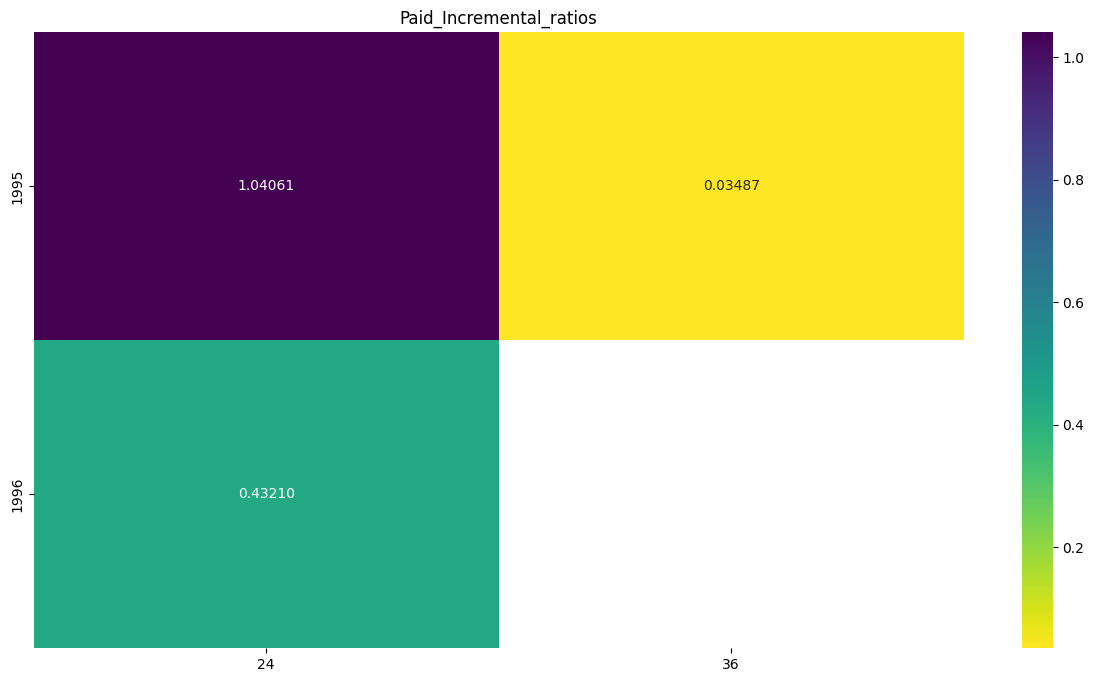



This is the case_ratio_Triangle
   AccidentYear        24        36
0          1995  2.503678  2.223911
1          1996  3.384326       NaN
----------------------------------------------------------------------------------------------------------------------------------------------------


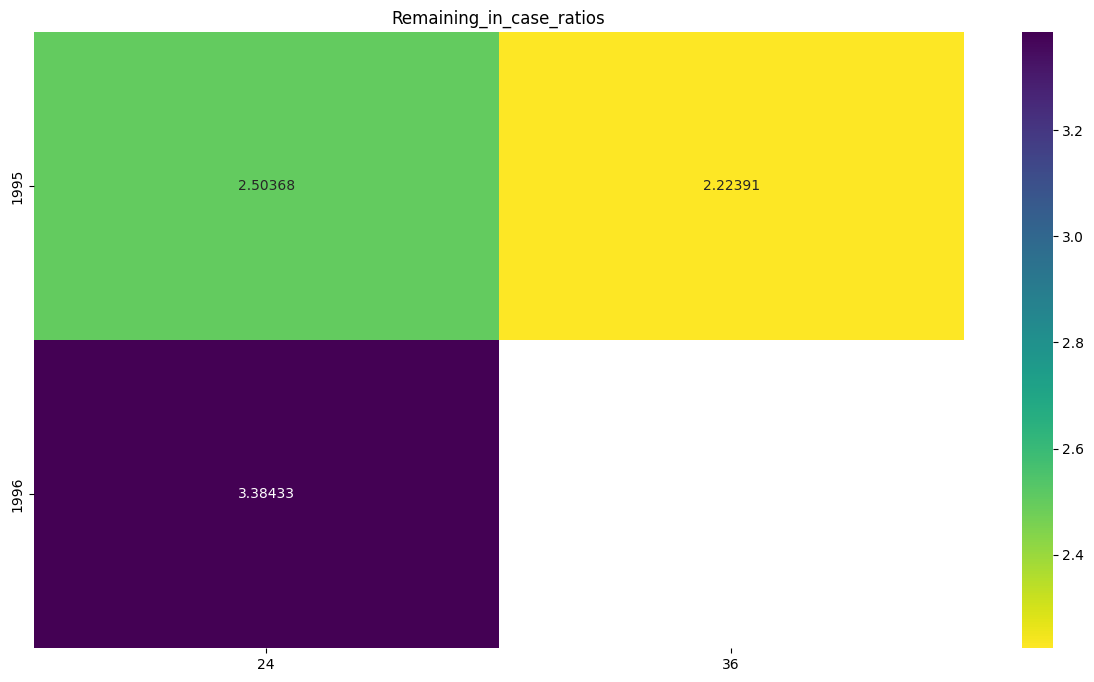



This is the case_out measures or averages Triangle
       Mean    Median  Months
0  2.944002  2.944002      24
1  2.223911  2.223911      36
----------------------------------------------------------------------------------------------------------------------------------------------------


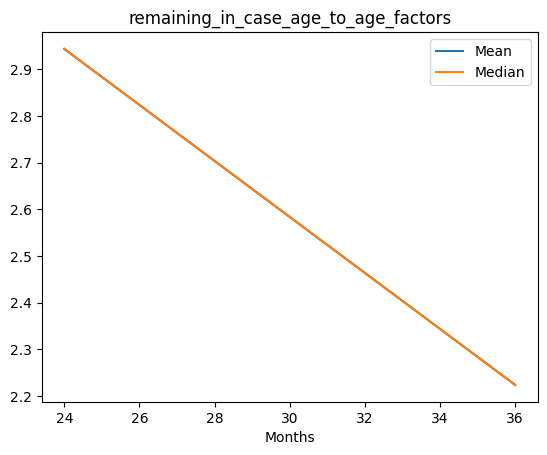



This is the paid incremental measures or averages Triangle
       Mean    Median  Months
0  0.736356  0.736356      24
1  0.034870  0.034870      36
----------------------------------------------------------------------------------------------------------------------------------------------------


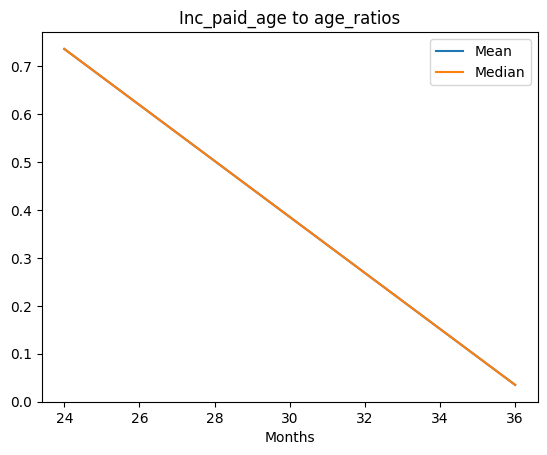



This is the filled case_outstanding Triangle
   AccidentYear    12         24         36
0          1995  3127   7829.000  17411.000
1          1996  1863   6305.000  14021.759
2          1997  4668  13742.601  30562.323
----------------------------------------------------------------------------------------------------------------------------------------------------


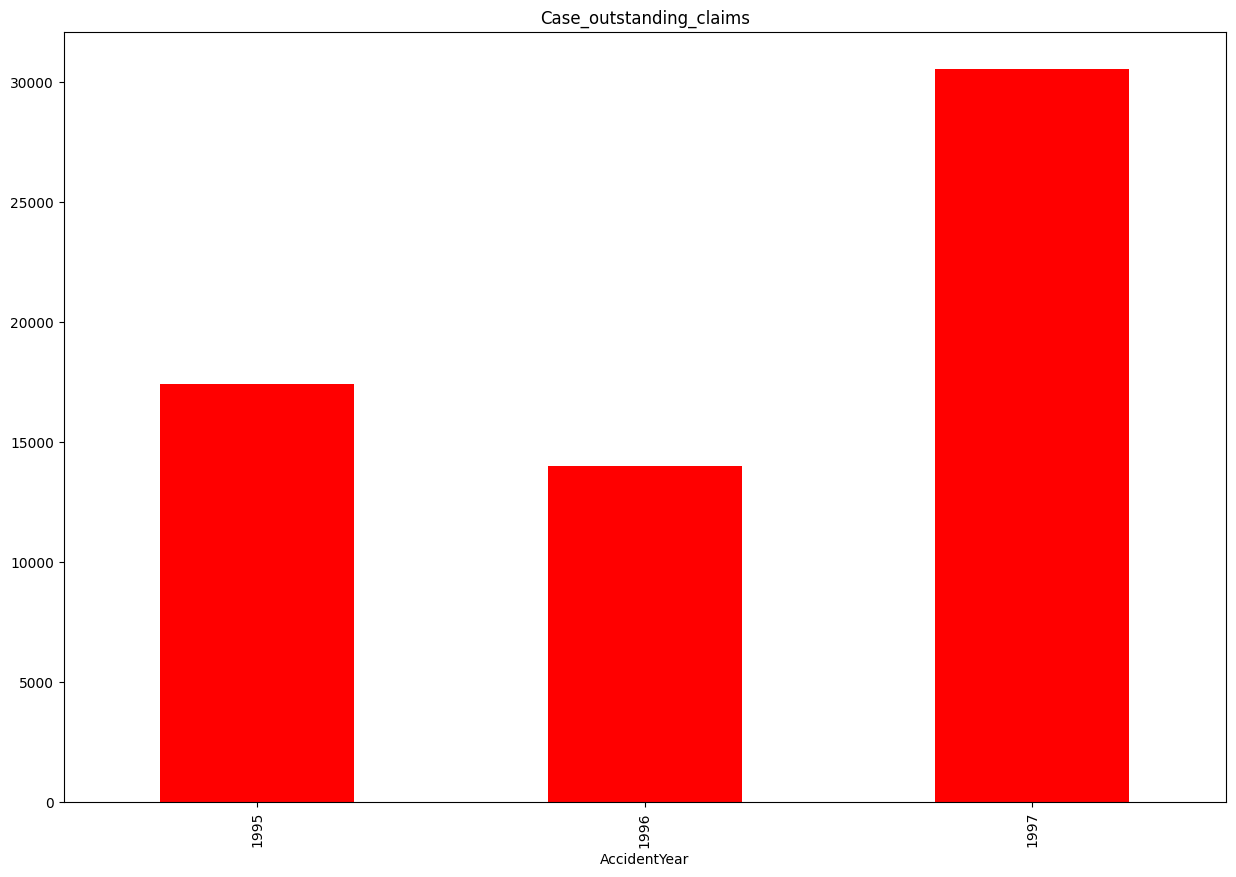



This is the cummulative filled incremental paid claims Triangle
   AccidentYear    12           24           36
0          1995  1275  4529.000000  4802.000000
1          1996  1239  2044.000000  2263.857581
2          1997  1616  5053.311611  5532.520970


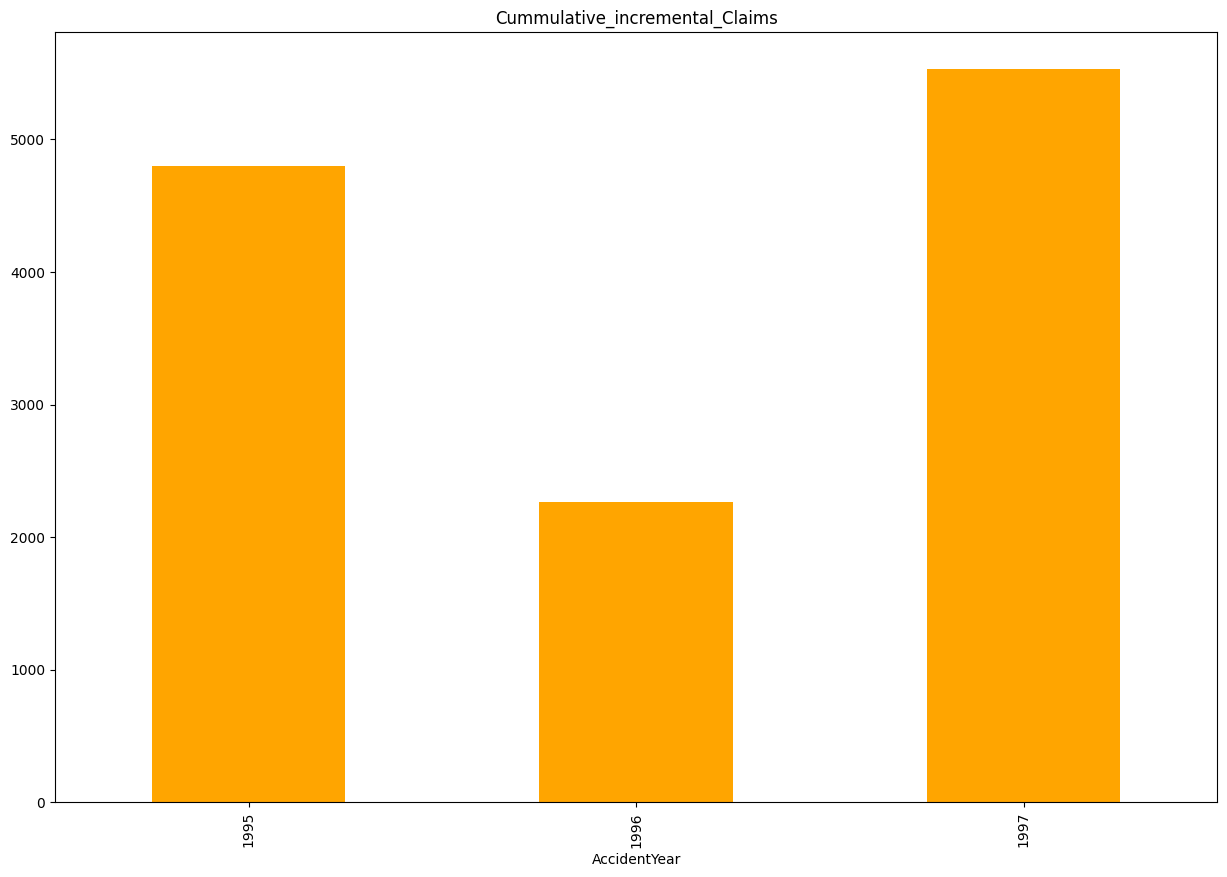

15069.0
12598.37855090616
----------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------
The name of the dataset is: Underwriters At Lloyds London
the final dataset looks like this:
   AccidentYear  12    24    36     48     60     72     84     96    108  \
0          1988   0   0.0   0.0    0.0    0.0    NaN    NaN    NaN    NaN   
1          1989   0   0.0   0.0    0.0    NaN    NaN    NaN    NaN    NaN   
2          1990   0  12.0  53.0   56.0   66.0   66.0   66.0   66.0   66.0   
3          1991   3  72.0  86.0  166.0  181.0  181.0  181.0  181.0  181.0   
4          1992   8  36.0  59.0   65.0   65.0   65.0   65.0   65.0   65.0   
5          1993   0   0.0   0.0    NaN    NaN    NaN    NaN    NaN    NaN   
6          1994   0   0.0   NaN    NaN    Na

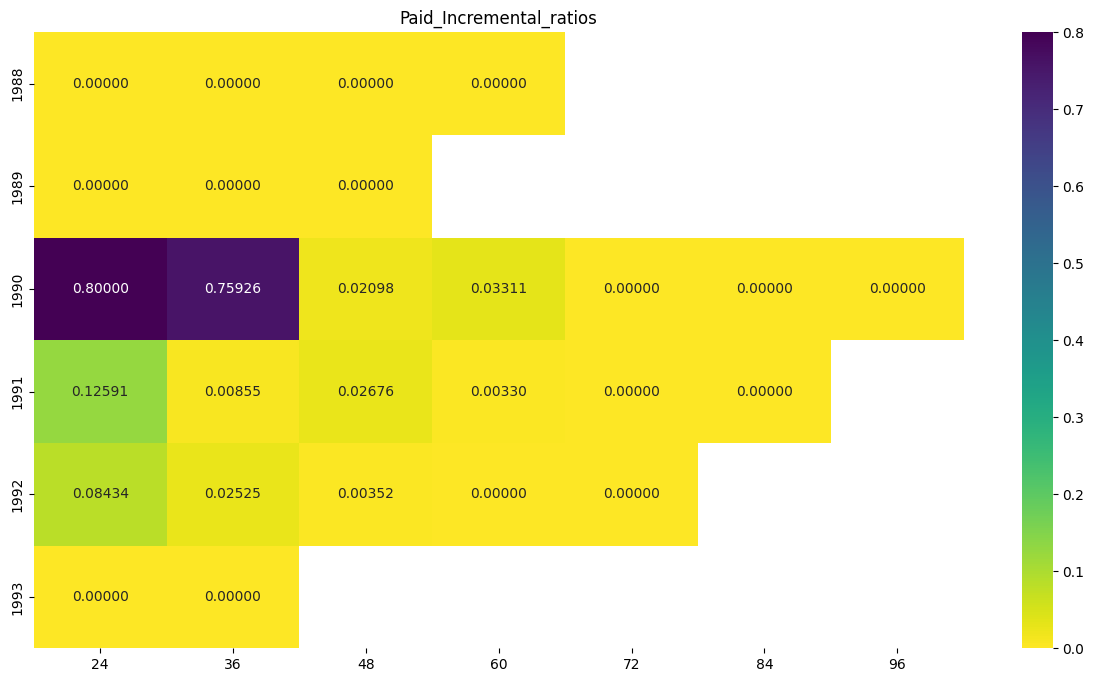



This is the case_ratio_Triangle
   AccidentYear        24        36        48        60        72        84  \
0          1988  2.500000  2.100000  1.539683  1.371134       NaN       NaN   
1          1989  4.636364  2.411765  1.609756       NaN       NaN       NaN   
2          1990  3.600000  2.648148  2.111888  1.725166  1.552783  1.437577   
3          1991  2.989051  1.824786  1.519572  1.378688  1.303577  1.255053   
4          1992  2.743976  1.871570  1.509091  1.362612  1.284655       NaN   
5          1993  2.642857  1.918919       NaN       NaN       NaN       NaN   

         96  
0       NaN  
1       NaN  
2  1.361135  
3       NaN  
4       NaN  
5       NaN  
----------------------------------------------------------------------------------------------------------------------------------------------------


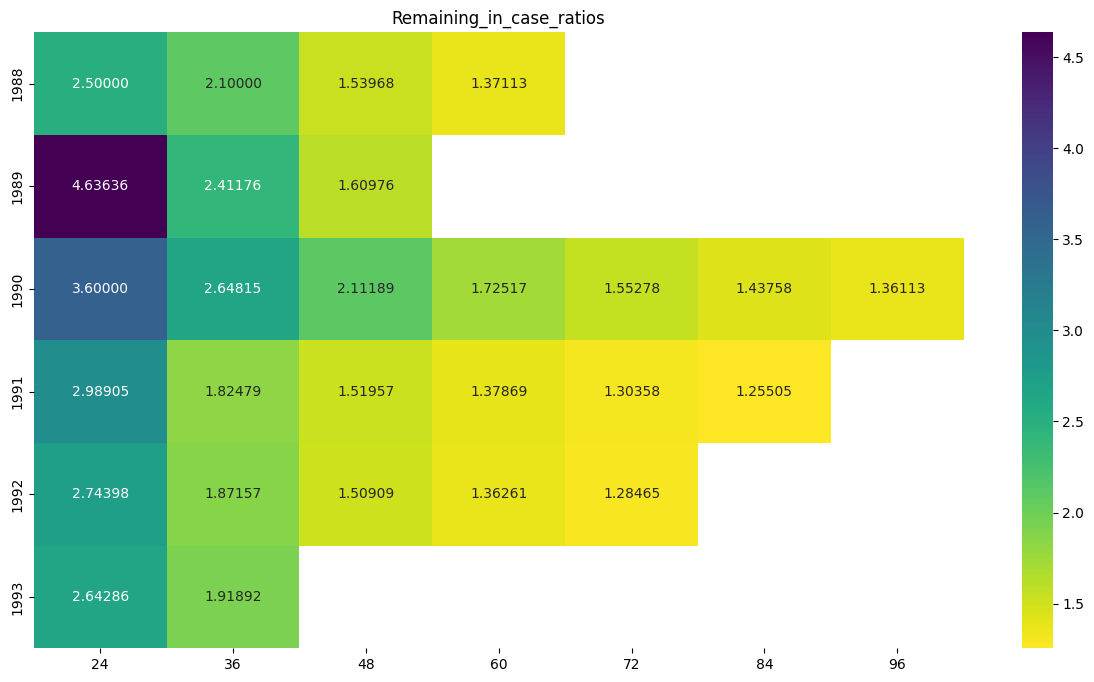



This is the case_out measures or averages Triangle
       Mean    Median  Months
0  3.185375  2.866513      24
1  2.129198  2.009459      36
2  1.657998  1.539683      48
3  1.459400  1.374911      60
4  1.380338  1.303577      72
5  1.346315  1.346315      84
6  1.361135  1.361135      96
----------------------------------------------------------------------------------------------------------------------------------------------------


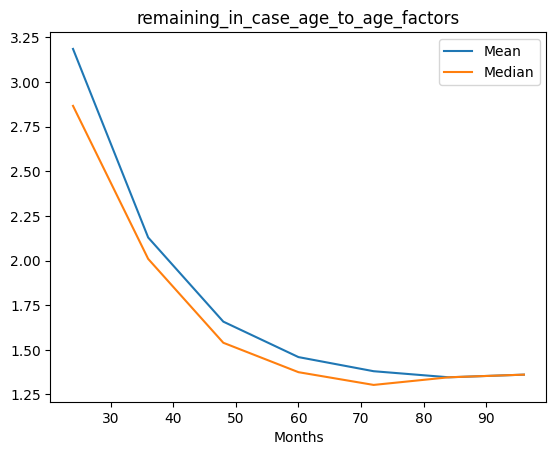



This is the paid incremental measures or averages Triangle
       Mean    Median  Months
0  0.168375  0.042169      24
1  0.132176  0.004274      36
2  0.010253  0.003519      48
3  0.009104  0.001651      60
4  0.000000  0.000000      72
5  0.000000  0.000000      84
6  0.000000  0.000000      96
----------------------------------------------------------------------------------------------------------------------------------------------------


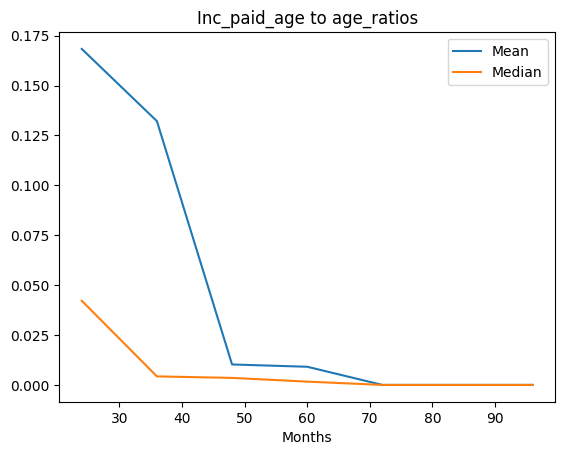



This is the filled case_outstanding Triangle
   AccidentYear   12    24        36        48        60        72         84  \
0          1988   12    30    63.000    97.000   133.000   183.585    247.163   
1          1989   11    51   123.000   198.000   288.961   398.864    536.997   
2          1990   15    54   143.000   302.000   521.000   809.000   1163.000   
3          1991  548  1638  2989.000  4542.000  6262.000  8163.000  10245.000   
4          1992  332   911  1705.000  2573.000  3506.000  4504.000   6063.804   
5          1993   14    37    71.000   117.718   171.798   237.139    319.264   
6          1994    9    20    42.584    70.604   103.039   142.229    191.485   

          96  
0    336.422  
1    730.925  
2   1583.000  
3  13944.828  
4   8253.656  
5    434.561  
6    260.637  
----------------------------------------------------------------------------------------------------------------------------------------------------


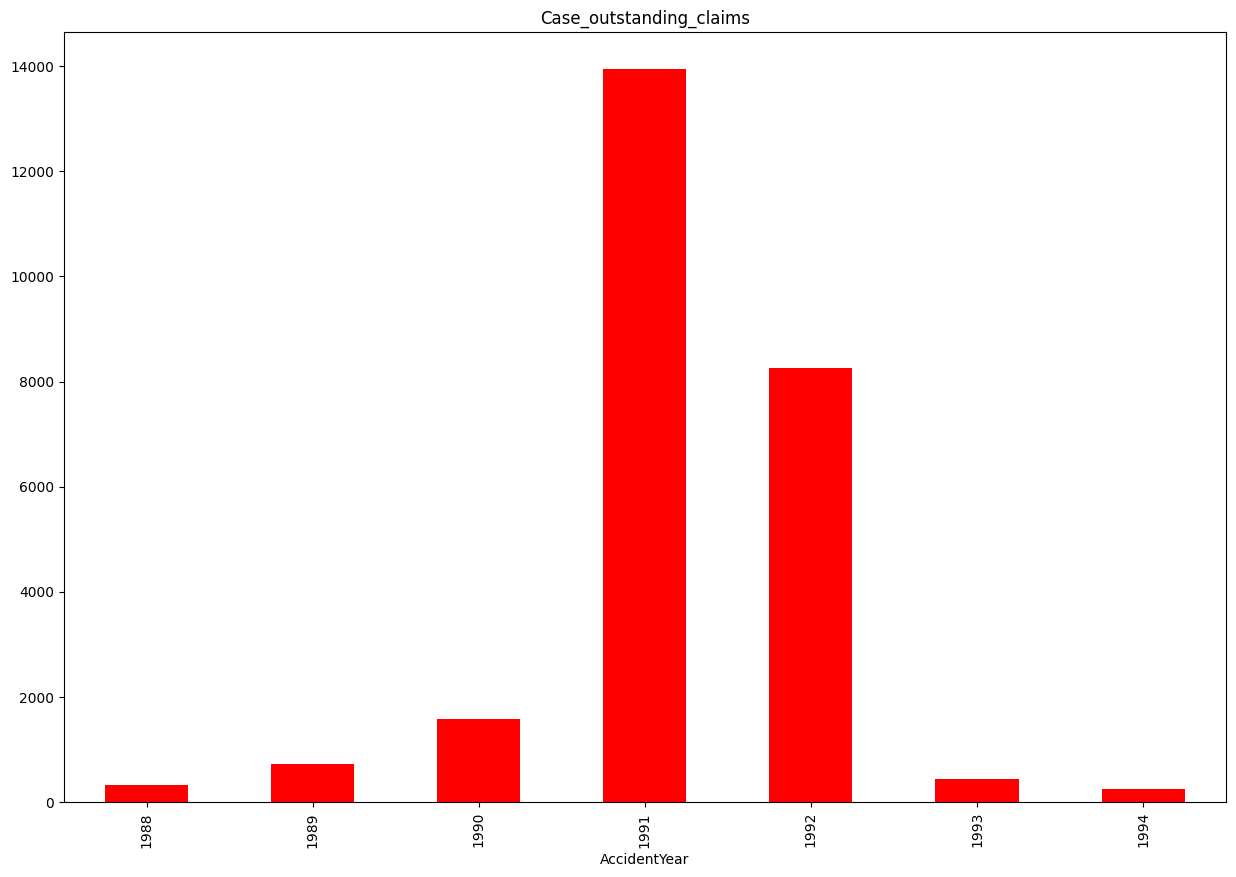



This is the cummulative filled incremental paid claims Triangle
   AccidentYear  12  24         36          48          60          72  \
0          1988   0   0   0.000000    0.000000    0.000000    0.000000   
1          1989   0   0   0.000000    0.000000    1.802547    1.802547   
2          1990   0  12  53.000000   56.000000   66.000000   66.000000   
3          1991   3  72  86.000000  166.000000  181.000000  181.000000   
4          1992   8  36  59.000000   65.000000   65.000000   65.000000   
5          1993   0   0   0.000000    0.727933    1.799611    1.799611   
6          1994   0   0   2.643511    3.080107    3.722869    3.722869   

           84          96  
0    0.000000    0.000000  
1    1.802547    1.802547  
2   66.000000   66.000000  
3  181.000000  181.000000  
4   65.000000   65.000000  
5    1.799611    1.799611  
6    3.722869    3.722869  


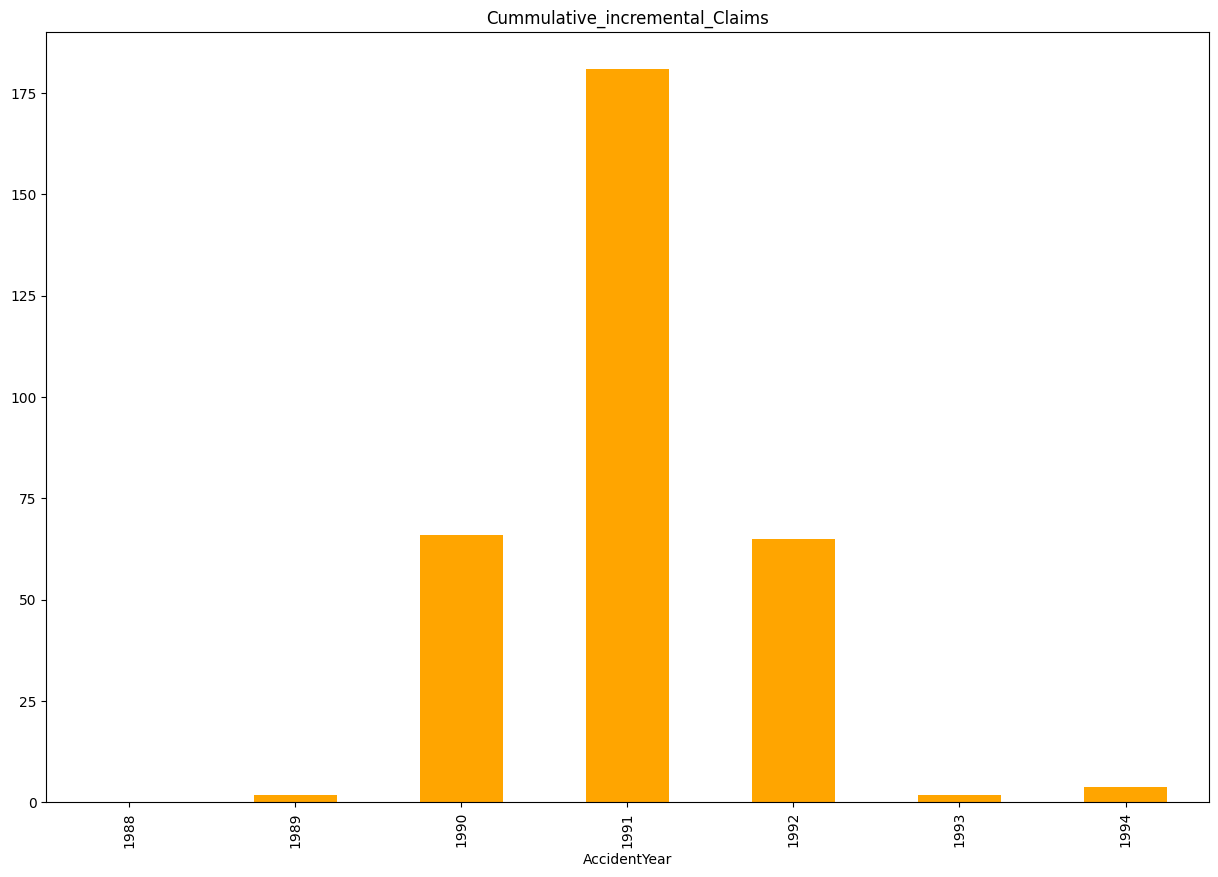

312.0
319.3250274378133
----------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------
The name of the dataset is: Cooperative Mut Ins Co
the final dataset looks like this:
   AccidentYear  12  24  36   48   60   72   84   96  108  120
0          1993   3  13  13   13   13   16   16   16   16   16
1          1994  23  32  35   41   65  136  136  136  136  136
2          1995  31  42  45   35   35   35   35   35   35   35
3          1996  51  55  35   39   44   55   55   55   55   53
4          1997  34  37  65  157  157  157  157  157  160  160
----------------------------------------------------------------------------------------------------------------------------------------------------


This is the case_outstanding Triangle
   AccidentYear   12    2

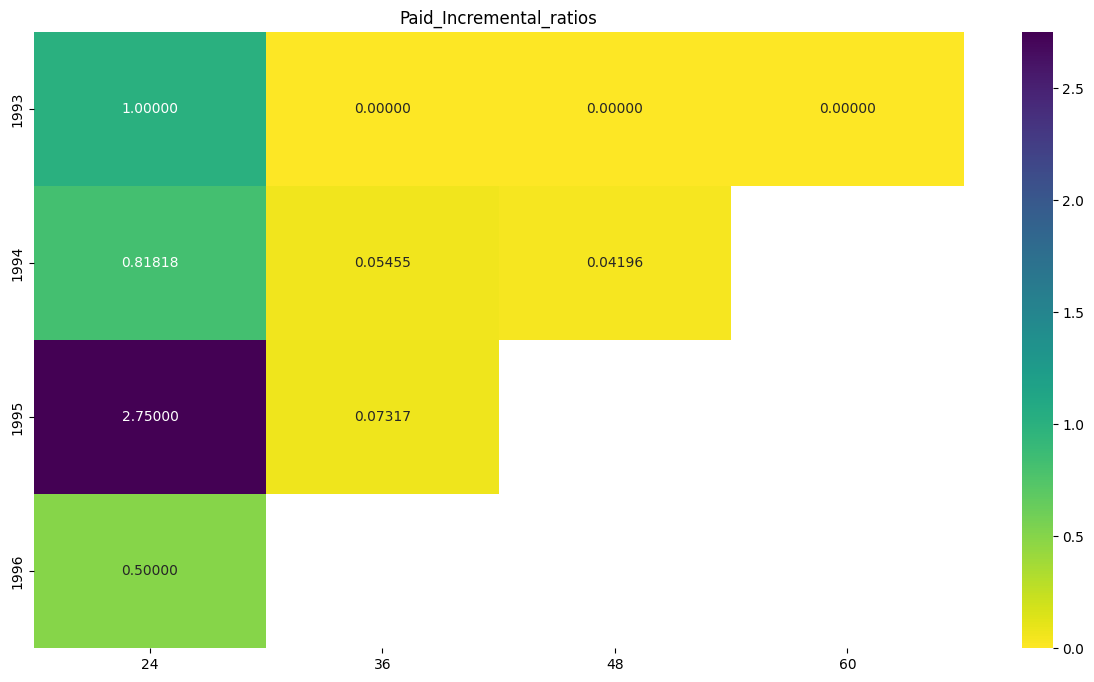



This is the case_ratio_Triangle
   AccidentYear     24        36        48        60
0          1993   2.30  2.130435  1.795918  1.590909
1          1994   5.00  2.600000  1.965035       NaN
2          1995  10.25  2.926829       NaN       NaN
3          1996  10.75       NaN       NaN       NaN
----------------------------------------------------------------------------------------------------------------------------------------------------


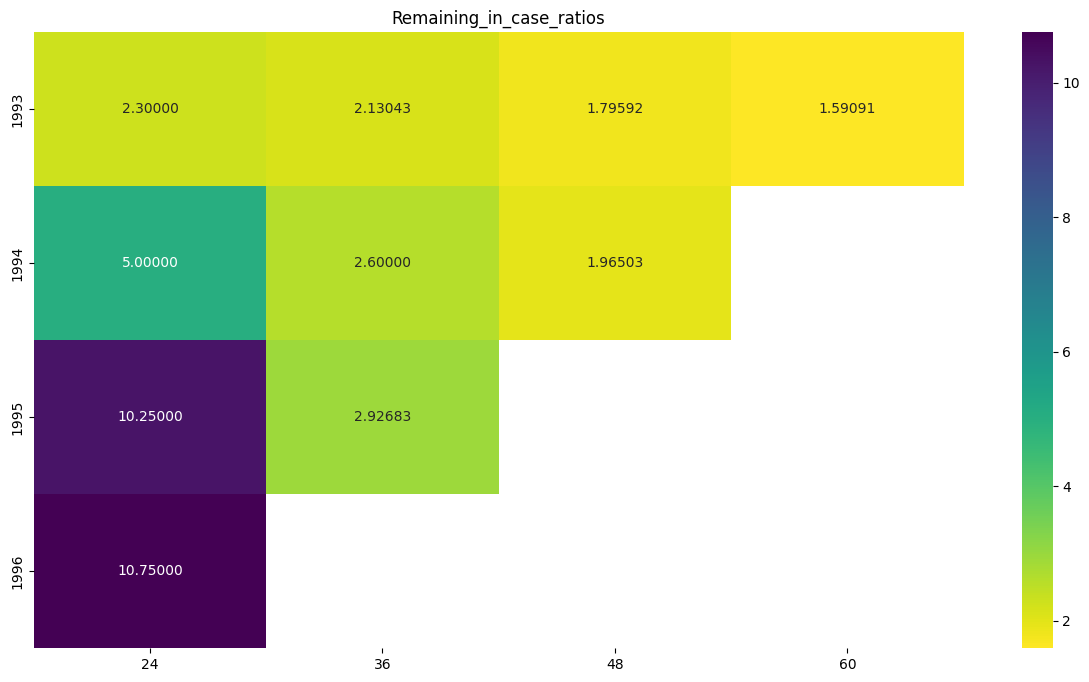



This is the case_out measures or averages Triangle
       Mean    Median  Months
0  7.075000  7.625000      24
1  2.552421  2.600000      36
2  1.880477  1.880477      48
3  1.590909  1.590909      60
----------------------------------------------------------------------------------------------------------------------------------------------------


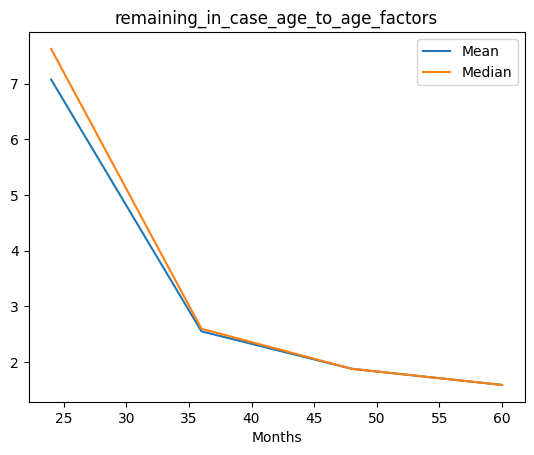



This is the paid incremental measures or averages Triangle
       Mean    Median  Months
0  1.267045  0.909091      24
1  0.042572  0.054545      36
2  0.020979  0.020979      48
3  0.000000  0.000000      60
----------------------------------------------------------------------------------------------------------------------------------------------------


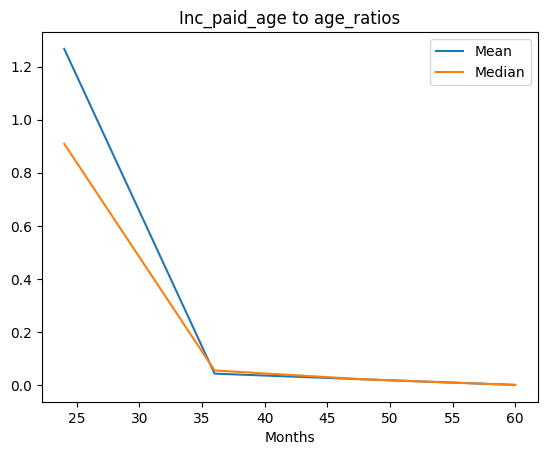



This is the filled case_outstanding Triangle
   AccidentYear   12       24        36        48        60
0          1993   10   23.000    49.000    88.000   140.000
1          1994   11   55.000   143.000   281.000   447.045
2          1995    4   41.000   120.000   225.657   359.000
3          1996    8   86.000   219.508   412.780   656.695
4          1997  127  898.525  2293.414  4312.712  6861.133
----------------------------------------------------------------------------------------------------------------------------------------------------


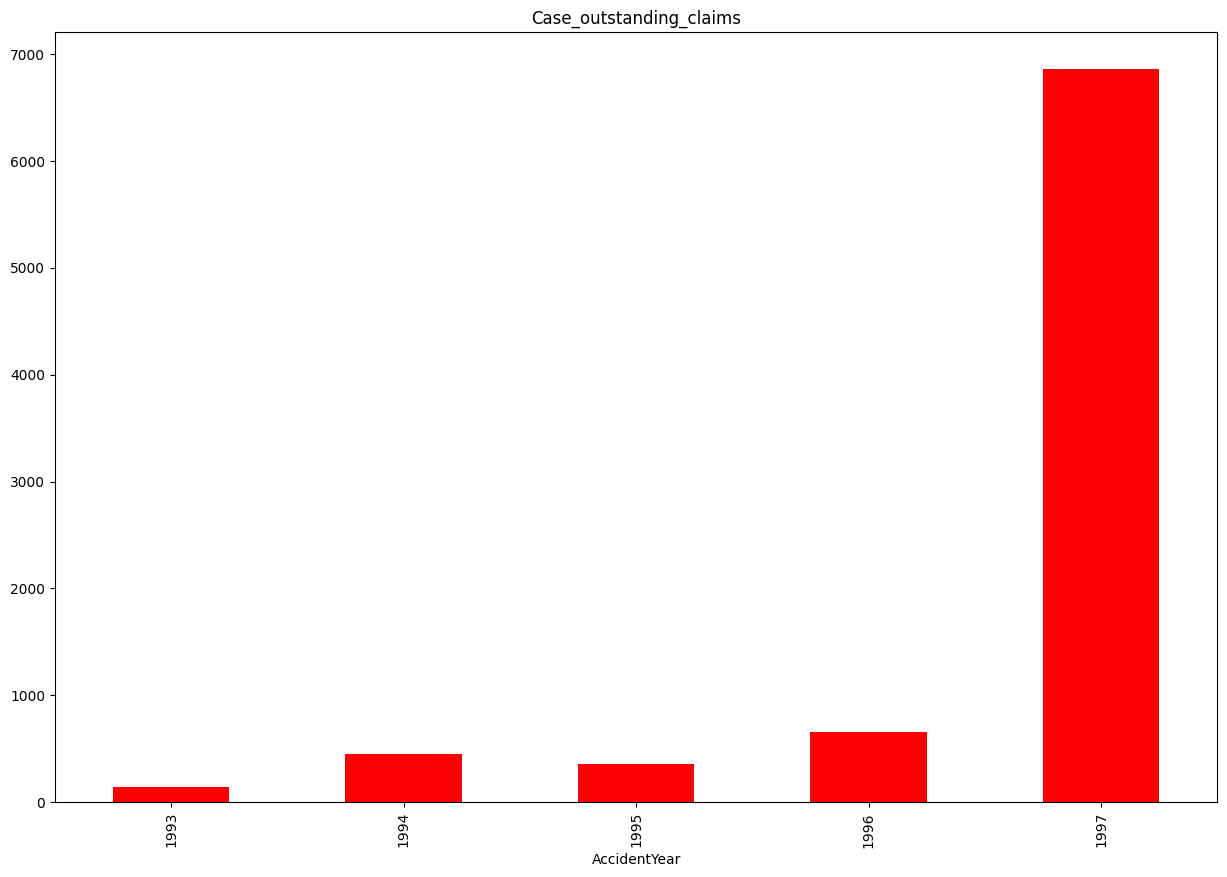



This is the cummulative filled incremental paid claims Triangle
   AccidentYear  12          24          36          48          60
0          1993   3   13.000000   13.000000   13.000000   13.000000
1          1994  23   32.000000   35.000000   41.000000   41.000000
2          1995  31   42.000000   45.000000   47.517483   47.517483
3          1996  51   55.000000   58.661197   63.266260   63.266260
4          1997  34  194.914773  233.166835  281.280415  281.280415


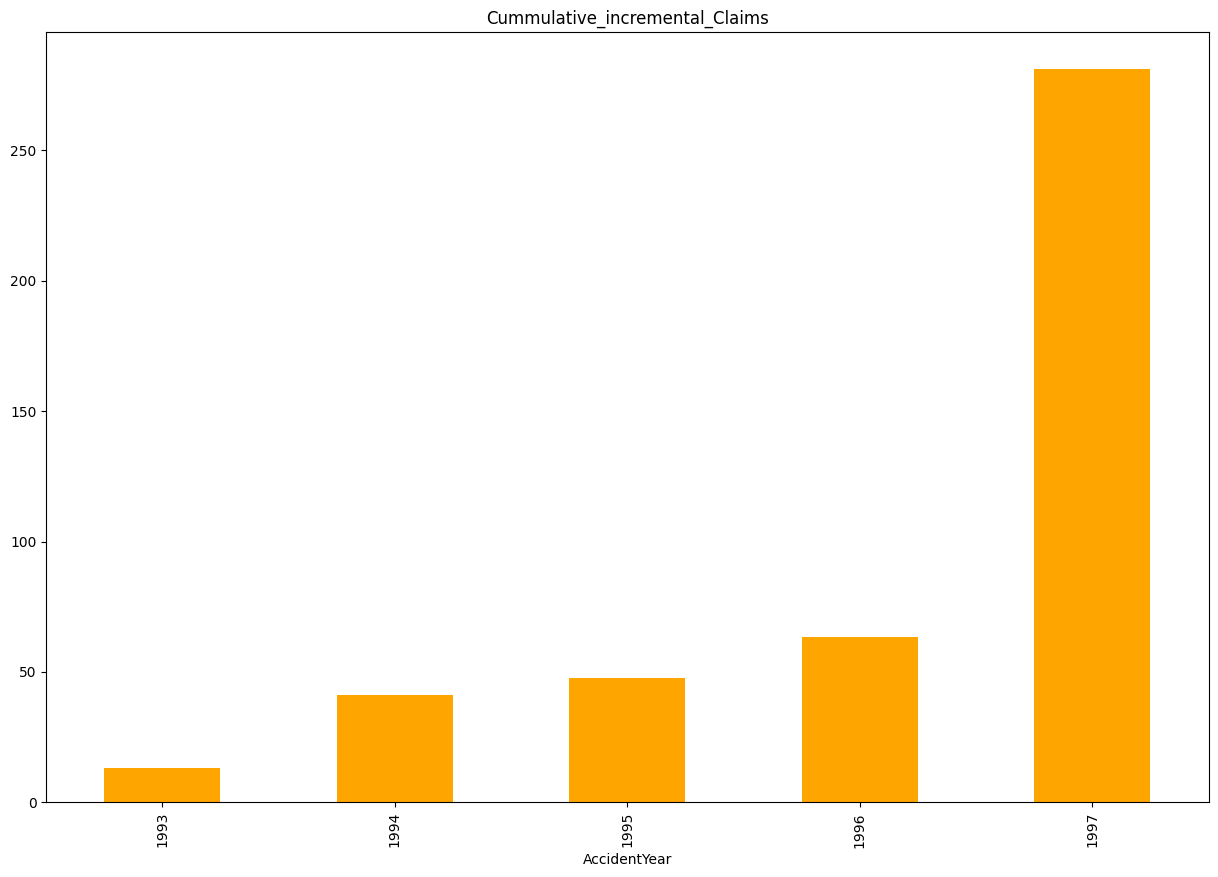

314
446.06415802490193
----------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------
The name of the dataset is: Elevators Mut Ins Co
the final dataset looks like this:
   AccidentYear  12     24     36     48     60     72     84     96    108  \
0          1995   0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1          1996   8   10.0   11.0   11.0   10.0   10.0   10.0   10.0   10.0   
2          1997  79  128.0  151.0  151.0  151.0  151.0  151.0  151.0  151.0   

     120  
0    NaN  
1   10.0  
2  151.0  
----------------------------------------------------------------------------------------------------------------------------------------------------


This is the case_outstanding Triangle
   AccidentYear   12    24
0          1995   

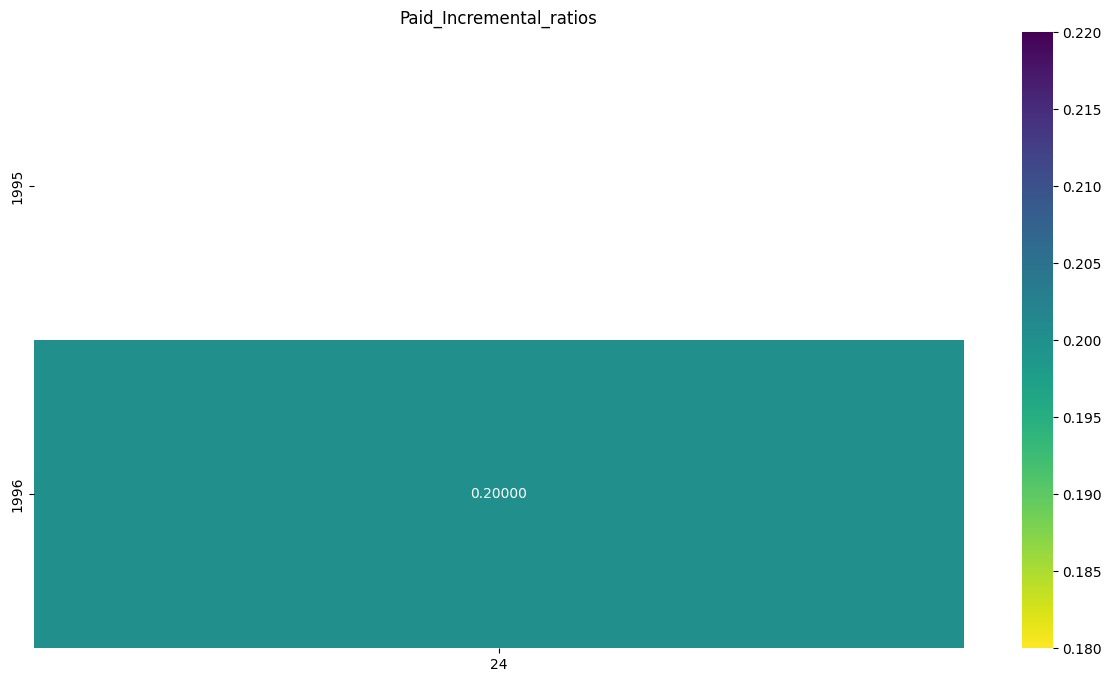



This is the case_ratio_Triangle
   AccidentYear   24
0          1995  NaN
1          1996  3.1
----------------------------------------------------------------------------------------------------------------------------------------------------


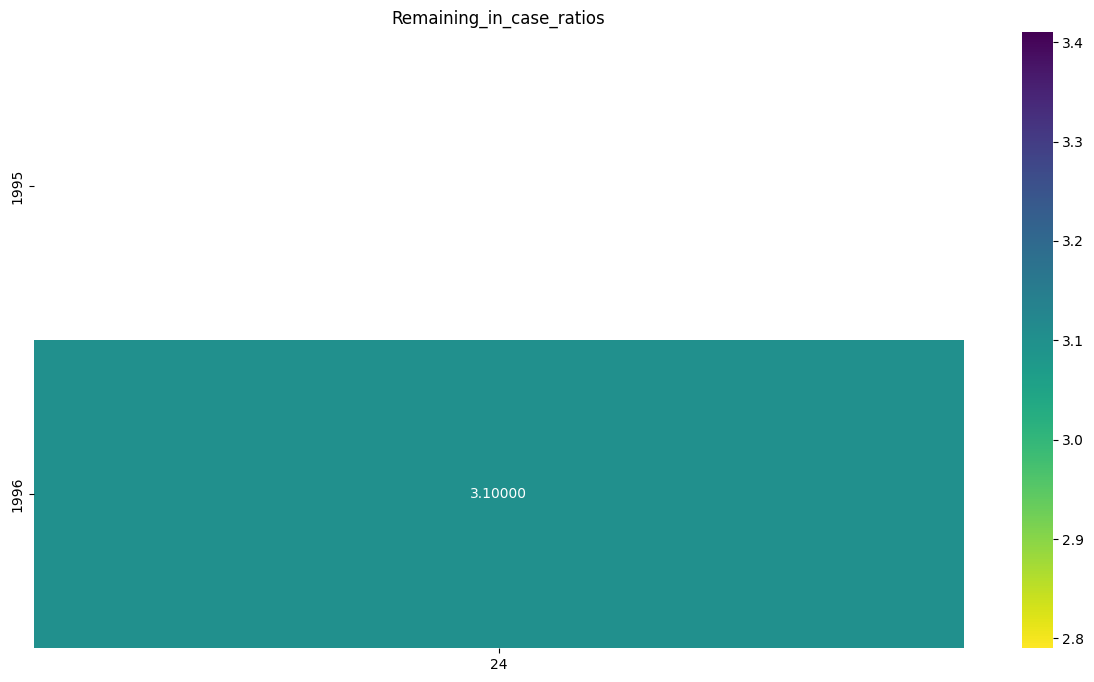



This is the case_out measures or averages Triangle
   Mean  Median  Months
0   3.1     3.1      24
----------------------------------------------------------------------------------------------------------------------------------------------------


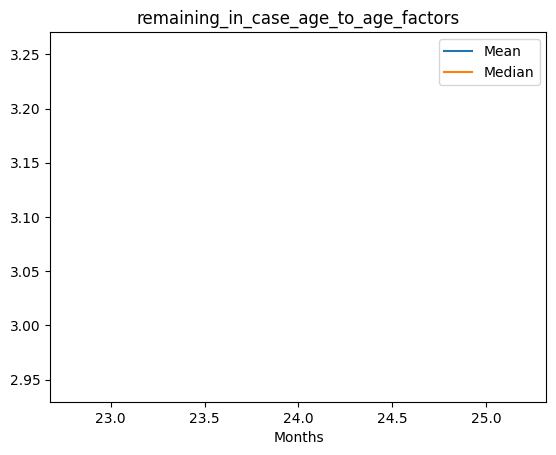



This is the paid incremental measures or averages Triangle
   Mean  Median  Months
0   0.2     0.2      24
----------------------------------------------------------------------------------------------------------------------------------------------------


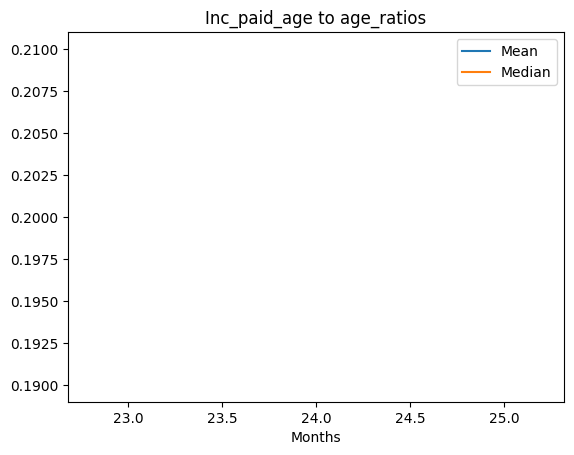



This is the filled case_outstanding Triangle
   AccidentYear   12     24
0          1995    9   27.9
1          1996   10   31.0
2          1997  116  359.6
----------------------------------------------------------------------------------------------------------------------------------------------------


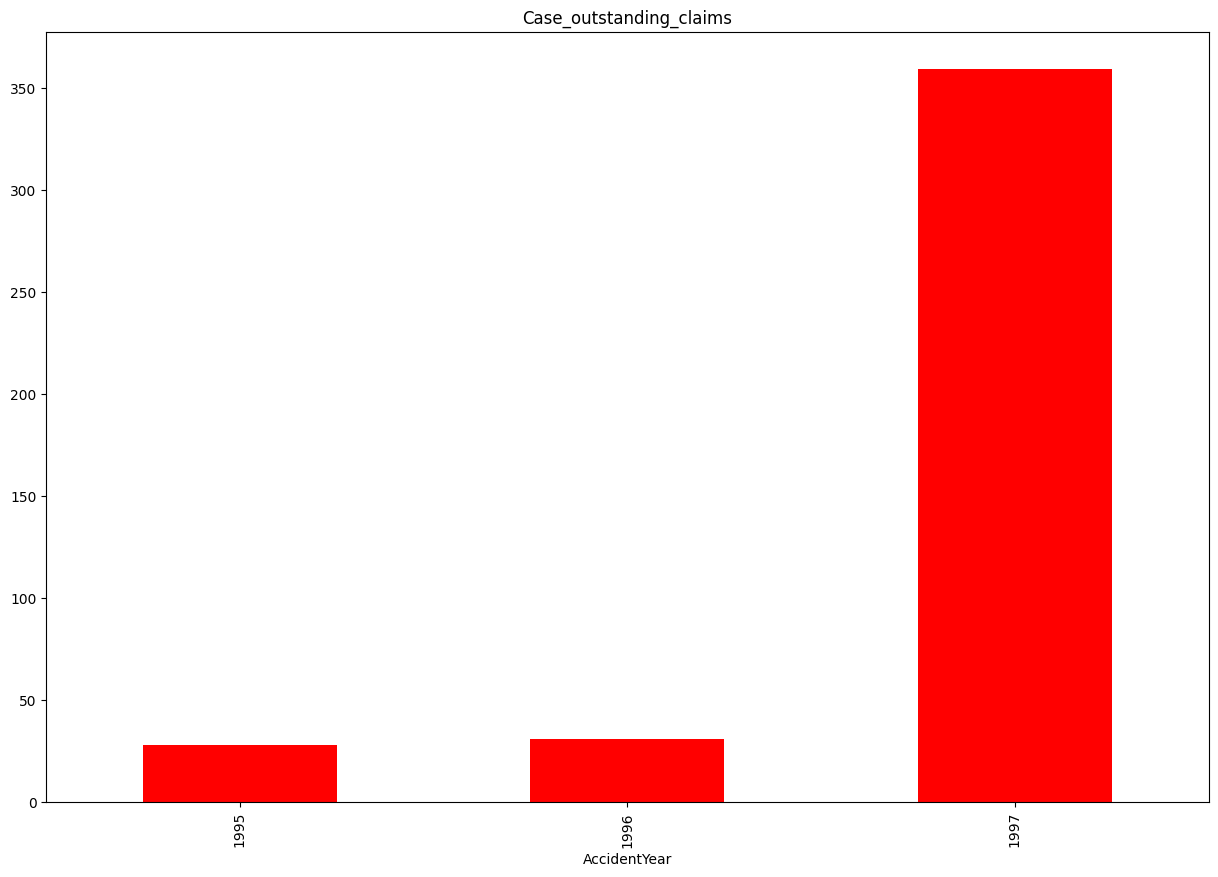



This is the cummulative filled incremental paid claims Triangle
   AccidentYear  12     24
0          1995   0    1.8
1          1996   8   10.0
2          1997  79  102.2


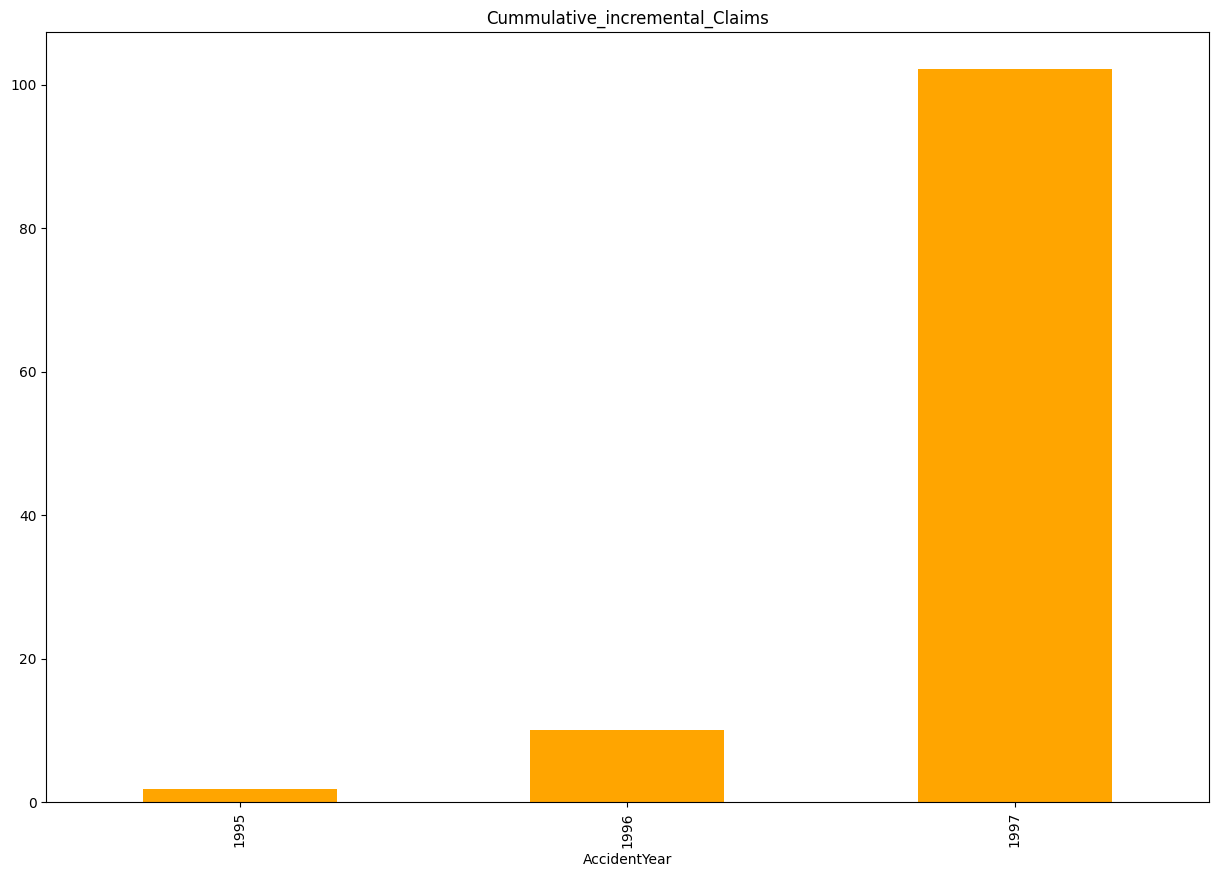

138.0
114.0
----------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------
The name of the dataset is: Mennonite Mut Ins Co
the final dataset looks like this:
   AccidentYear  12  24   36   48   60   72   84   96  108  120
0          1993   4   4    4    4    3    4    3    4    4    4
1          1994   7  31   30   29   29   29   30   30   30   29
2          1995  15  39  113  155  155  155  155  155  155  155
3          1996  34  32   32   32   37   37   37   38   37   38
4          1997  40  41   46   46   46   46   46   46   45   45
----------------------------------------------------------------------------------------------------------------------------------------------------


This is the case_outstanding Triangle
   AccidentYear   12     24     3

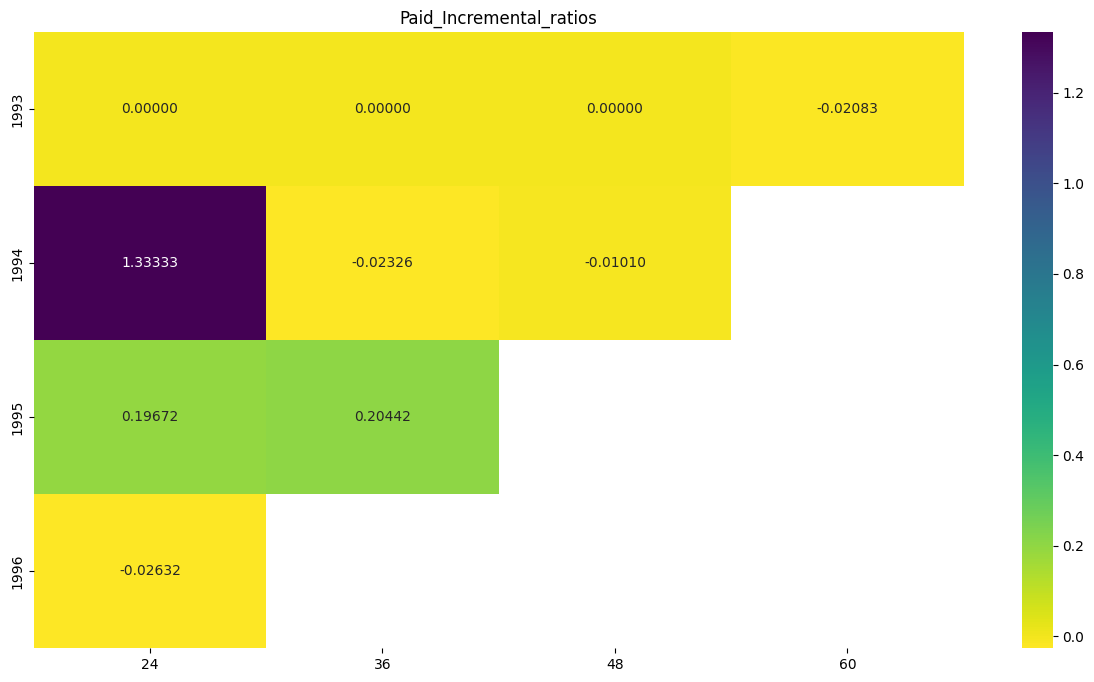



This is the case_ratio_Triangle
   AccidentYear        24        36        48        60
0          1993  2.666667  1.875000  1.600000  1.458333
1          1994  2.388889  2.302326  1.868687       NaN
2          1995  2.967213  1.933702       NaN       NaN
3          1996  2.473684       NaN       NaN       NaN
----------------------------------------------------------------------------------------------------------------------------------------------------


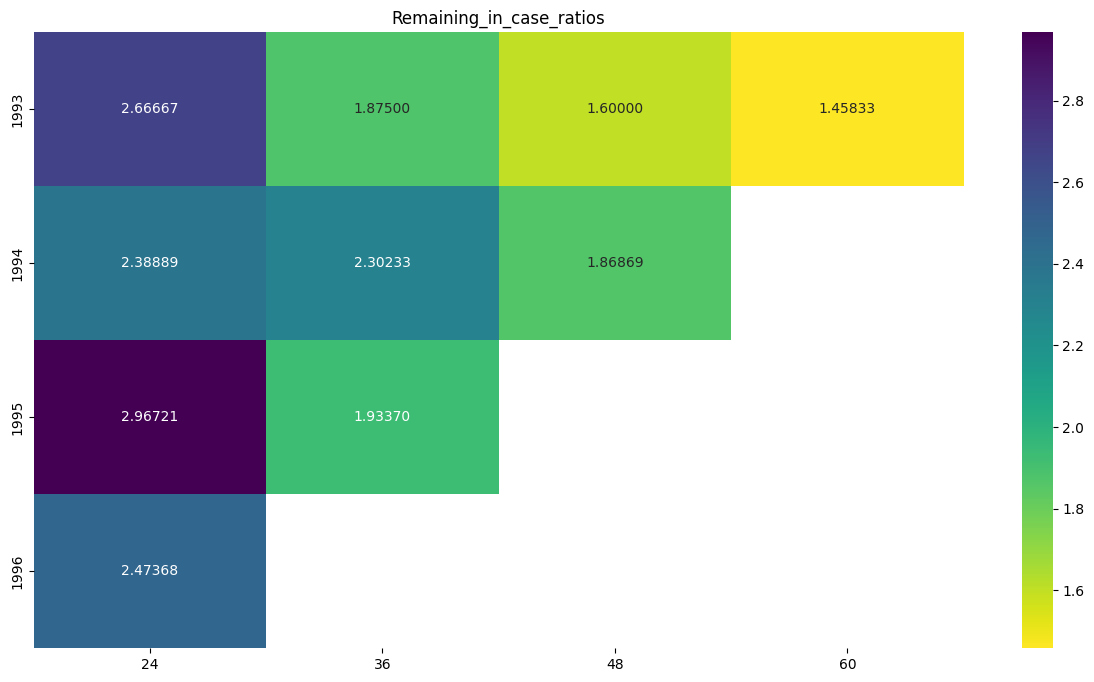



This is the case_out measures or averages Triangle
       Mean    Median  Months
0  2.624113  2.570175      24
1  2.037009  1.933702      36
2  1.734343  1.734343      48
3  1.458333  1.458333      60
----------------------------------------------------------------------------------------------------------------------------------------------------


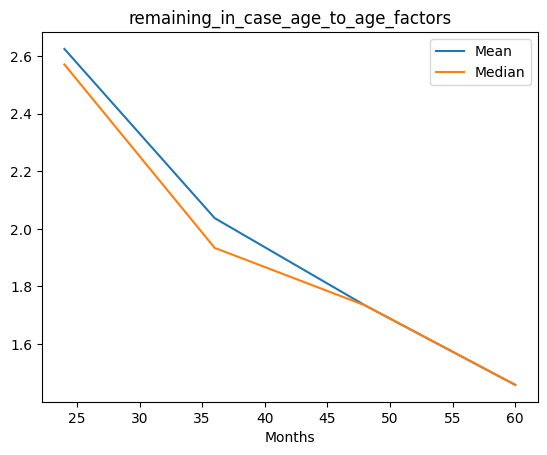



This is the paid incremental measures or averages Triangle
       Mean    Median  Months
0  0.375935  0.098361      24
1  0.060388  0.000000      36
2 -0.005051 -0.005051      48
3 -0.020833 -0.020833      60
----------------------------------------------------------------------------------------------------------------------------------------------------


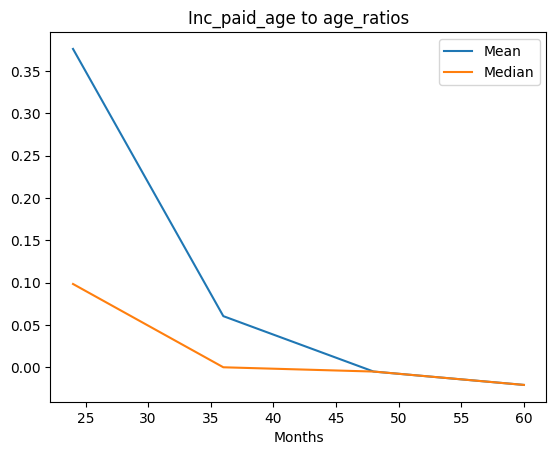



This is the filled case_outstanding Triangle
   AccidentYear   12       24       36        48        60
0          1993    6   16.000   30.000    48.000    70.000
1          1994   18   43.000   99.000   185.000   269.792
2          1995  122  362.000  700.000  1214.040  1770.475
3          1996   76  188.000  382.958   664.181   968.597
4          1997    8   20.993   42.763    74.166   108.159
----------------------------------------------------------------------------------------------------------------------------------------------------


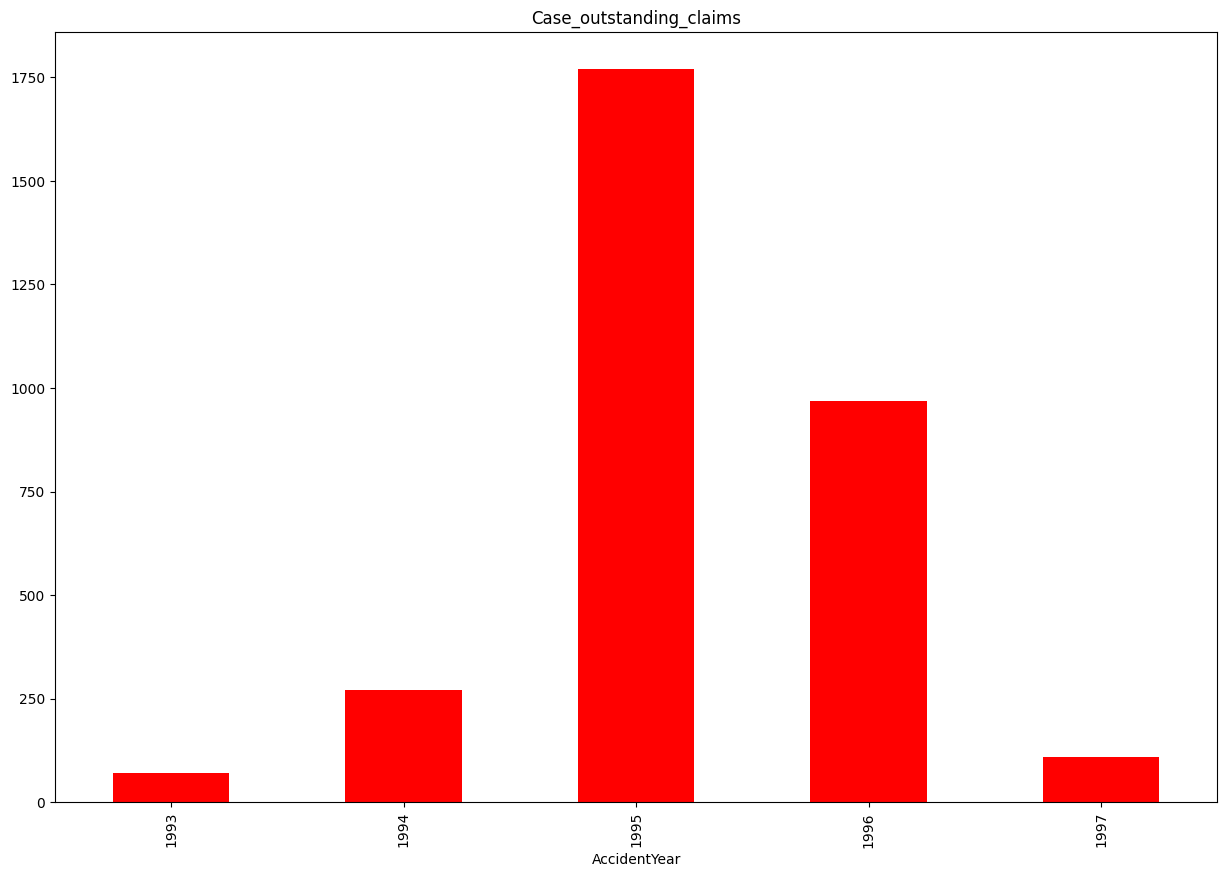



This is the cummulative filled incremental paid claims Triangle
   AccidentYear  12         24          36          48         60
0          1993   4   4.000000    4.000000    4.000000   3.000000
1          1994   7  31.000000   30.000000   29.000000  25.145833
2          1995  15  39.000000  113.000000  109.464646  84.172146
3          1996  34  32.000000   43.352949   41.418817  27.581713
4          1997  40  43.007478   44.275204   44.059229  42.514104


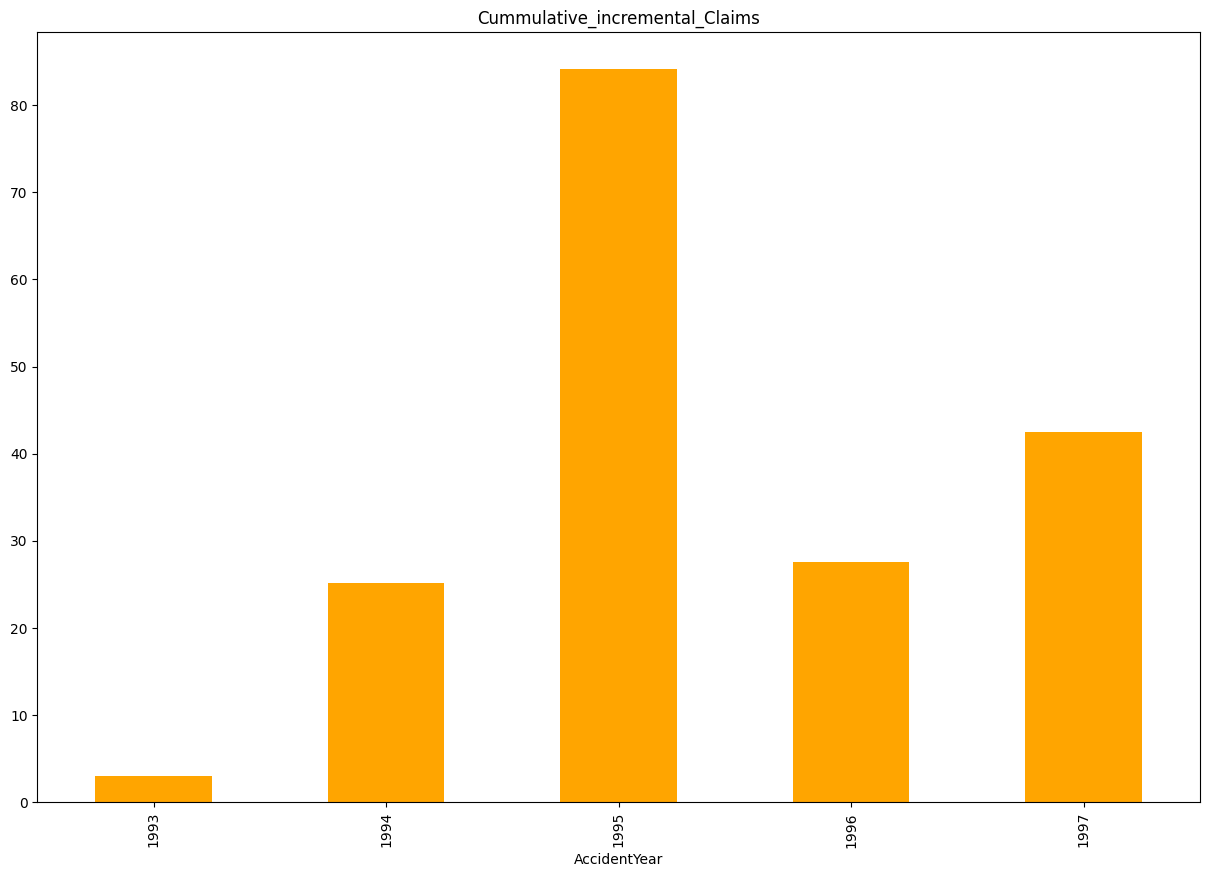

270
182.413796828467
----------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------
The name of the dataset is: Co-Operative Ins Co
the final dataset looks like this:
   AccidentYear  12  24  36  48  60  72  84  96  108  120
0          1995   1   1   2   2   2   2   2   2    2    2
1          1996  12  29  29  87  86  87  87  87   87   87
2          1997  10  19  20  20  21  21  21  21   21   21
----------------------------------------------------------------------------------------------------------------------------------------------------


This is the case_outstanding Triangle
   AccidentYear  12     24     36
0          1995  28   78.0  142.0
1          1996  63  173.0    NaN
2          1997  66    NaN    NaN
-----------------------------------------

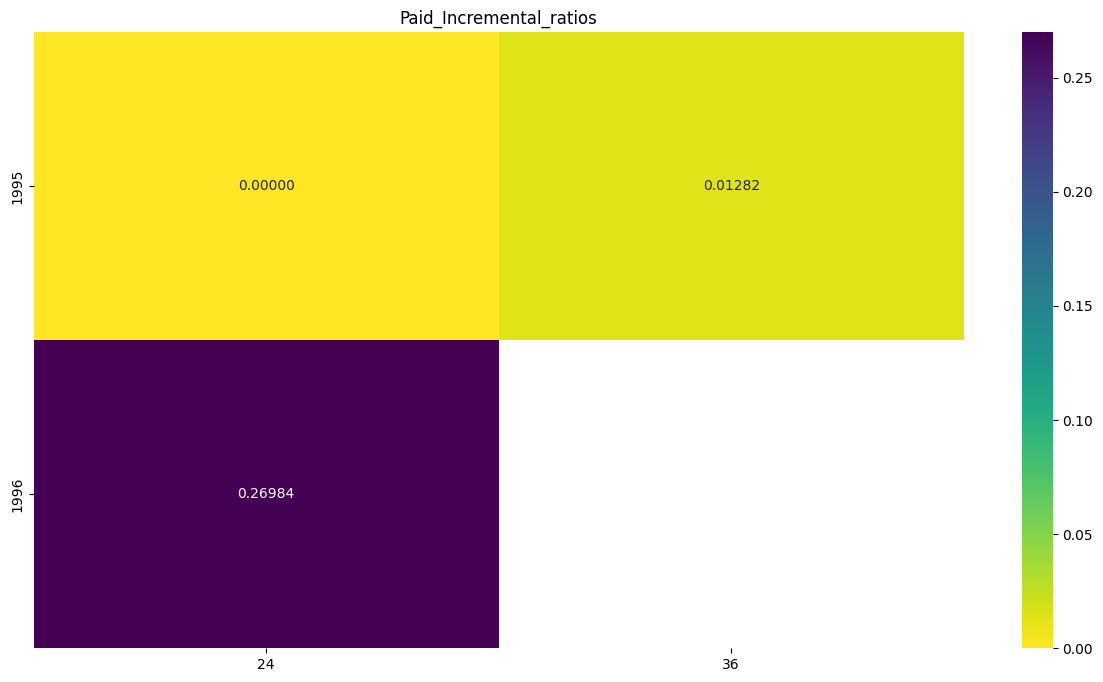



This is the case_ratio_Triangle
   AccidentYear        24        36
0          1995  2.785714  1.820513
1          1996  2.746032       NaN
----------------------------------------------------------------------------------------------------------------------------------------------------


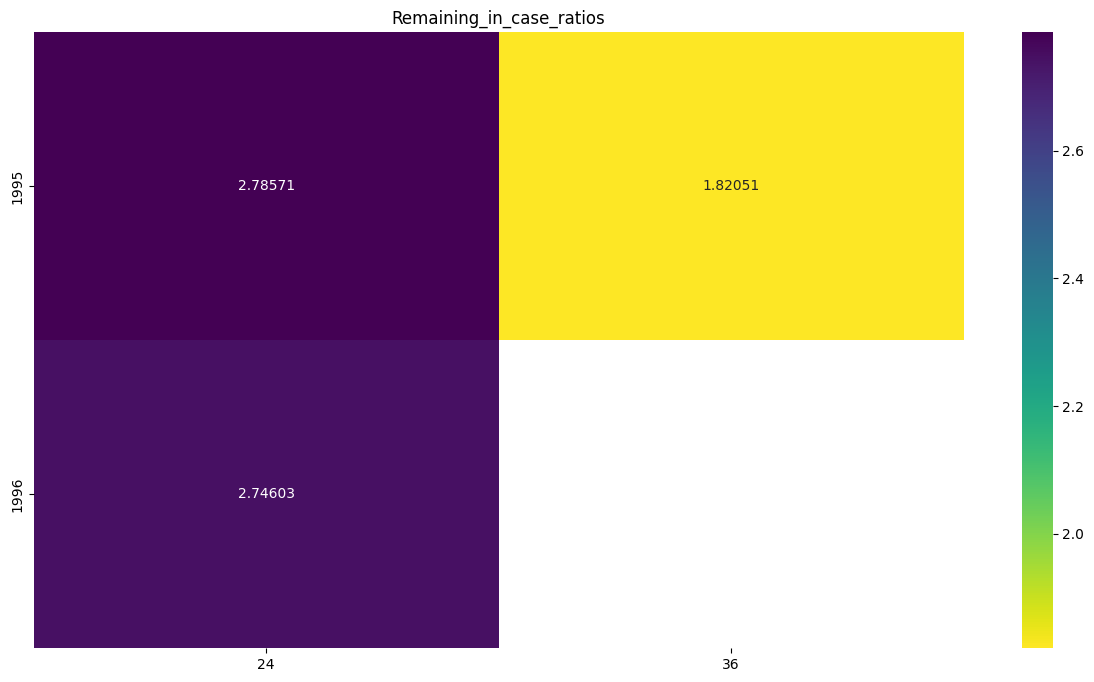



This is the case_out measures or averages Triangle
       Mean    Median  Months
0  2.765873  2.765873      24
1  1.820513  1.820513      36
----------------------------------------------------------------------------------------------------------------------------------------------------


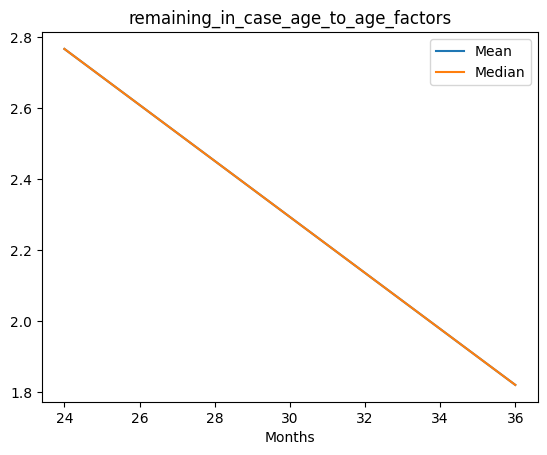



This is the paid incremental measures or averages Triangle
       Mean    Median  Months
0  0.134921  0.134921      24
1  0.012821  0.012821      36
----------------------------------------------------------------------------------------------------------------------------------------------------


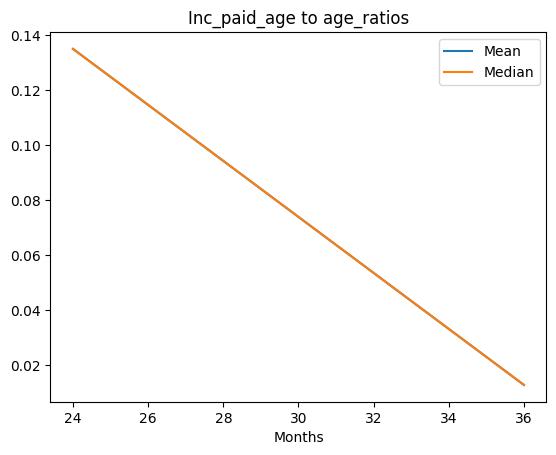



This is the filled case_outstanding Triangle
   AccidentYear  12       24       36
0          1995  28   78.000  142.000
1          1996  63  173.000  314.949
2          1997  66  182.548  332.331
----------------------------------------------------------------------------------------------------------------------------------------------------


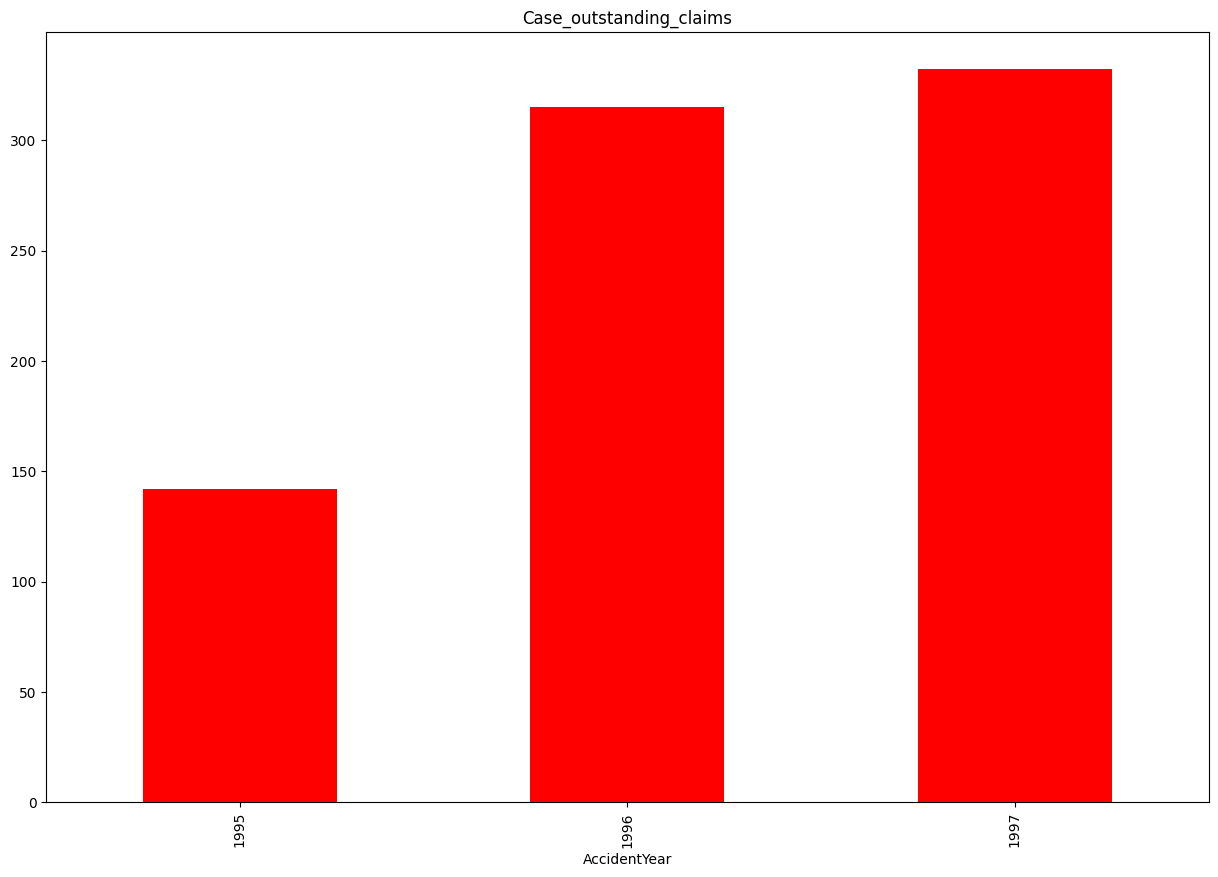



This is the cummulative filled incremental paid claims Triangle
   AccidentYear  12         24         36
0          1995   1   1.000000   2.000000
1          1996  12  29.000000  31.217949
2          1997  10  18.904762  21.245121


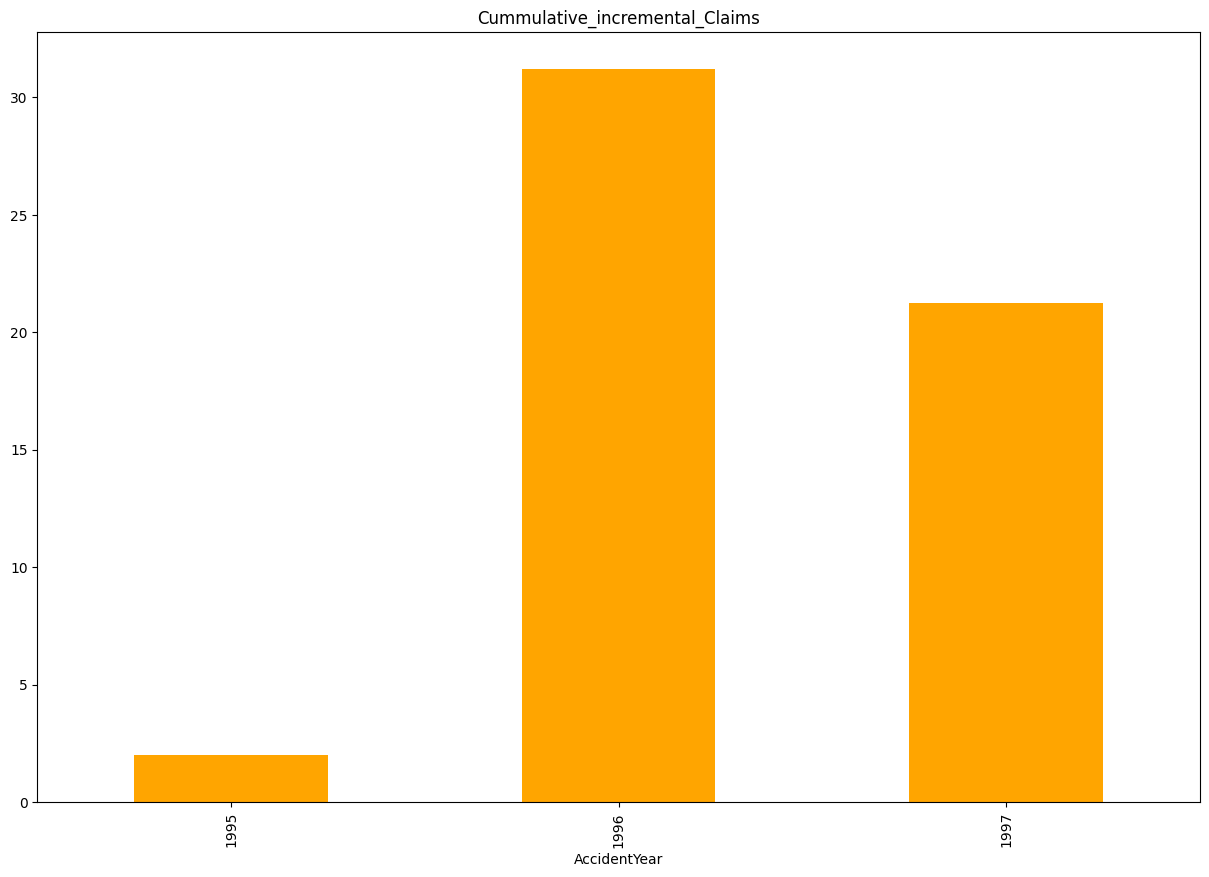

51
54.46306959706959
----------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------
The name of the dataset is: New York Municipal Ins Reciprocal
the final dataset looks like this:
   AccidentYear   12   24   36   48    60    72    84    96   108   120
0          1993   11   13   13   13    13    13    13    13    13    13
1          1994  121  168  222  323   331   341   367   368   597   597
2          1995  222  310  351  363   369   384   393   397   397   397
3          1996  302  395  466  598   613   635   636   637   637   637
4          1997  273  364  492  916  1152  1152  1152  1152  1152  1152
----------------------------------------------------------------------------------------------------------------------------------------------------


T

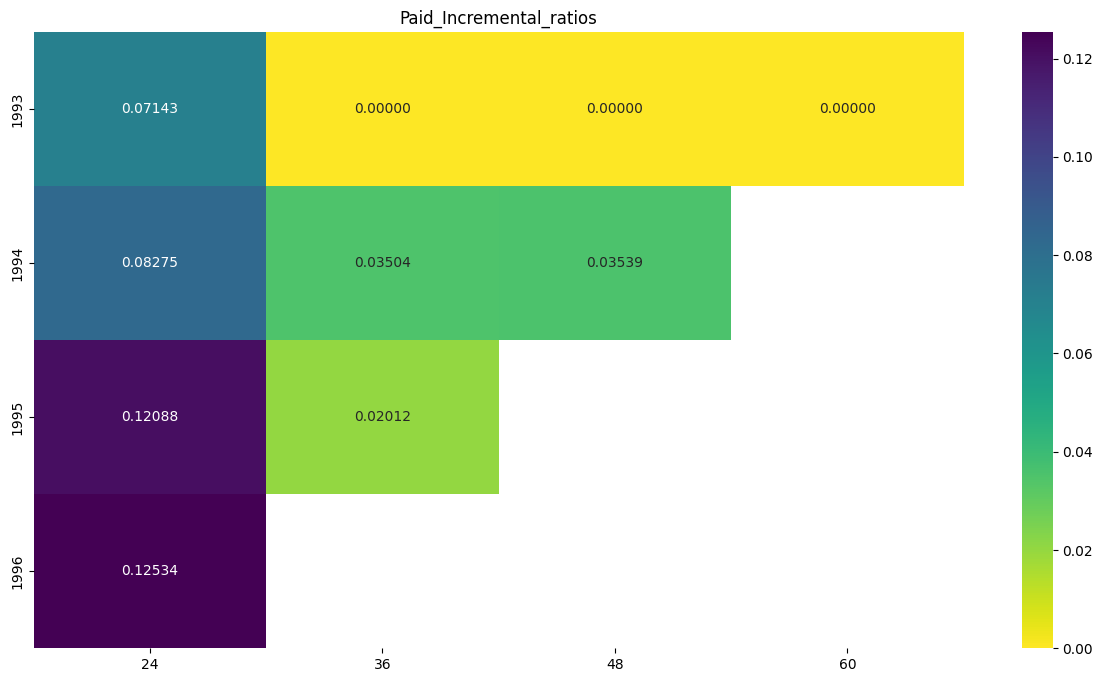



This is the case_ratio_Triangle
   AccidentYear        24        36        48        60
0          1993  2.857143  1.912500  1.562092  1.414226
1          1994  2.713028  1.852044  1.567975       NaN
2          1995  2.799451  1.866536       NaN       NaN
3          1996  2.823450       NaN       NaN       NaN
----------------------------------------------------------------------------------------------------------------------------------------------------


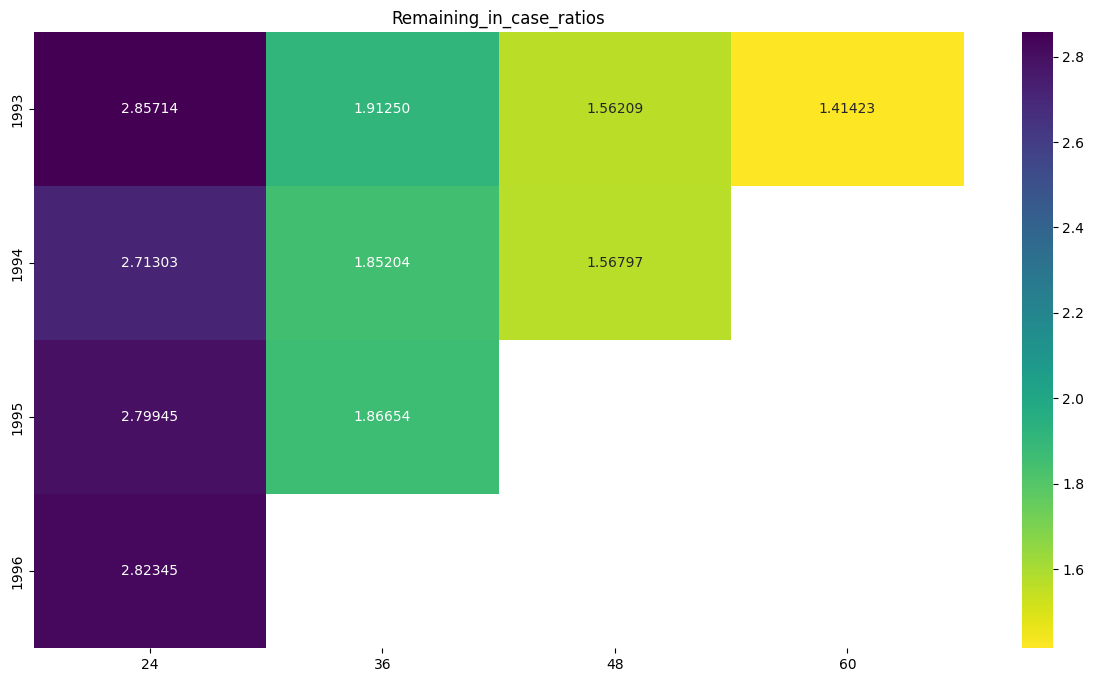



This is the case_out measures or averages Triangle
       Mean    Median  Months
0  2.798268  2.811450      24
1  1.877027  1.866536      36
2  1.565033  1.565033      48
3  1.414226  1.414226      60
----------------------------------------------------------------------------------------------------------------------------------------------------


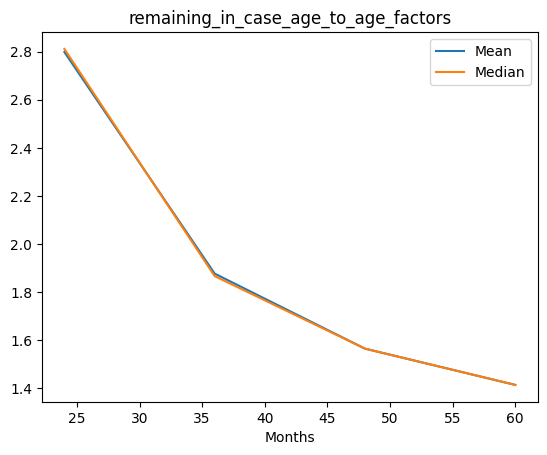



This is the paid incremental measures or averages Triangle
       Mean    Median  Months
0  0.100098  0.101813      24
1  0.018387  0.020118      36
2  0.017694  0.017694      48
3  0.000000  0.000000      60
----------------------------------------------------------------------------------------------------------------------------------------------------


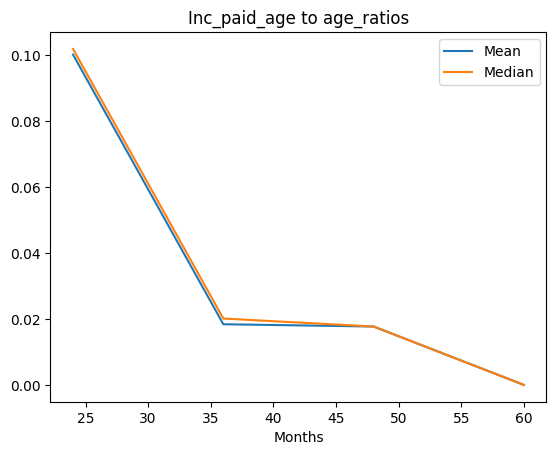



This is the filled case_outstanding Triangle
   AccidentYear   12        24        36        48        60
0          1993   28    80.000   153.000   239.000   338.000
1          1994  568  1541.000  2854.000  4475.000  6328.661
2          1995  728  2038.000  3804.000  5953.386  8419.433
3          1996  742  2095.000  3932.371  6154.291  8703.558
4          1997  392  1096.921  2058.950  3222.325  4557.096
----------------------------------------------------------------------------------------------------------------------------------------------------


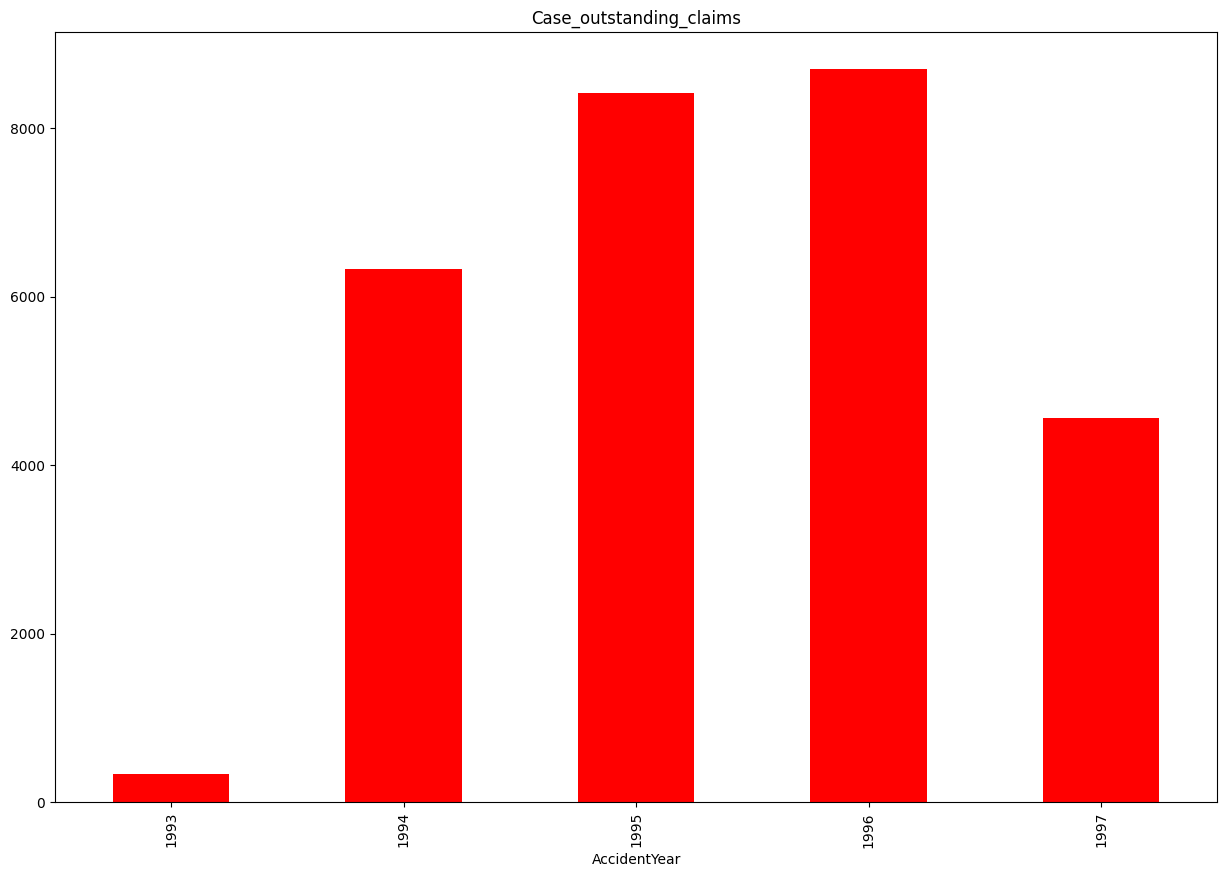



This is the cummulative filled incremental paid claims Triangle
   AccidentYear   12          24          36          48          60
0          1993   11   13.000000   13.000000   13.000000   13.000000
1          1994  121  168.000000  222.000000  323.000000  323.000000
2          1995  222  310.000000  351.000000  418.309741  418.309741
3          1996  302  395.000000  433.520027  503.101224  503.101224
4          1997  273  312.238328  332.407028  368.839044  368.839044


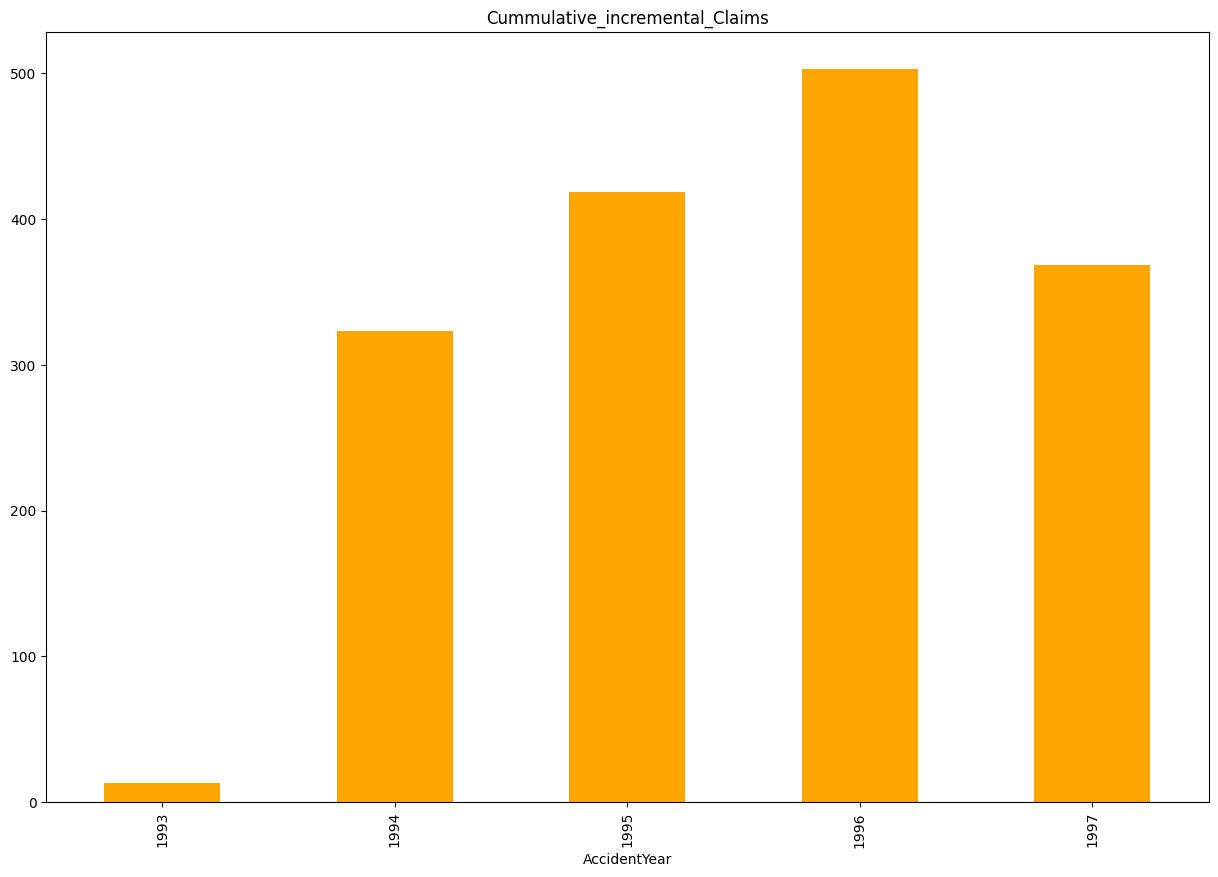

2478
1626.250008283947
----------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------
The name of the dataset is: Housing & Redevelopment Ins Exch
the final dataset looks like this:
   AccidentYear  12  24  36  48  60  72  84  96  108  120
0          1993   1   1   1   1   2   2   2   2    2    2
1          1994  10  14  16  16  16  16  16  16   16   16
2          1995  10  13  25  33  33  33  33  33   33   34
3          1996  36  37  63  65  67  68  71  92   93   93
4          1997   9  17  60  65  70  70  70  70   70   70
----------------------------------------------------------------------------------------------------------------------------------------------------


This is the case_outstanding Triangle
   AccidentYear  12     24     36     48     6

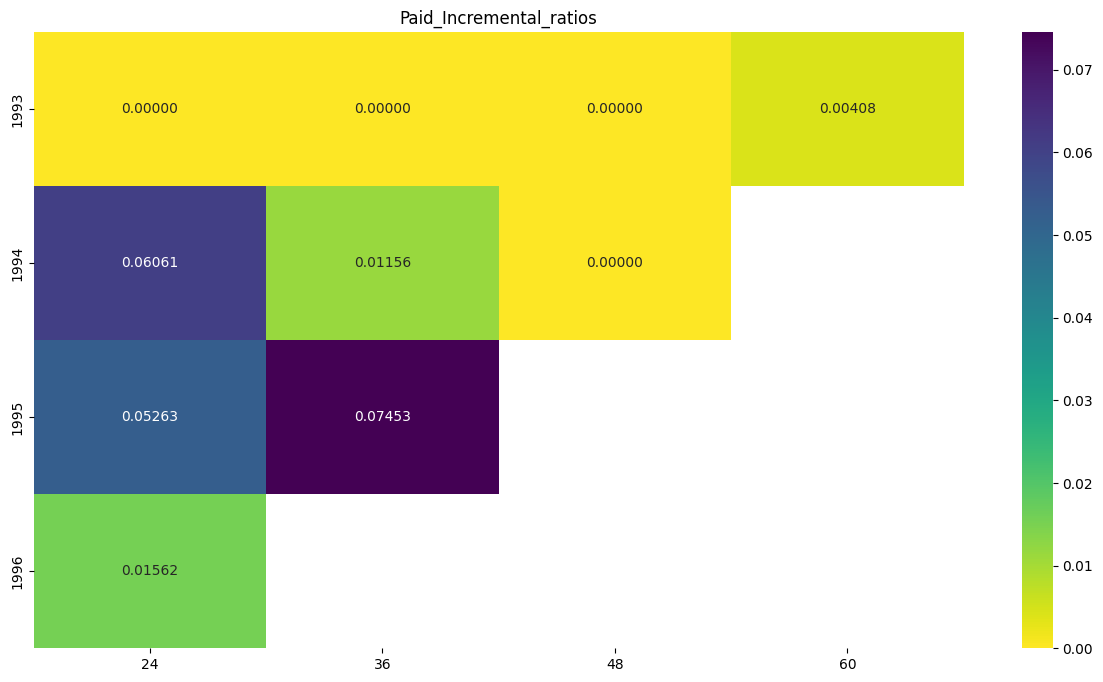



This is the case_ratio_Triangle
   AccidentYear        24        36        48        60
0          1993  2.428571  1.696078  1.416185  1.297959
1          1994  2.621212  1.786127  1.491909       NaN
2          1995  2.824561  2.006211       NaN       NaN
3          1996  3.265625       NaN       NaN       NaN
----------------------------------------------------------------------------------------------------------------------------------------------------


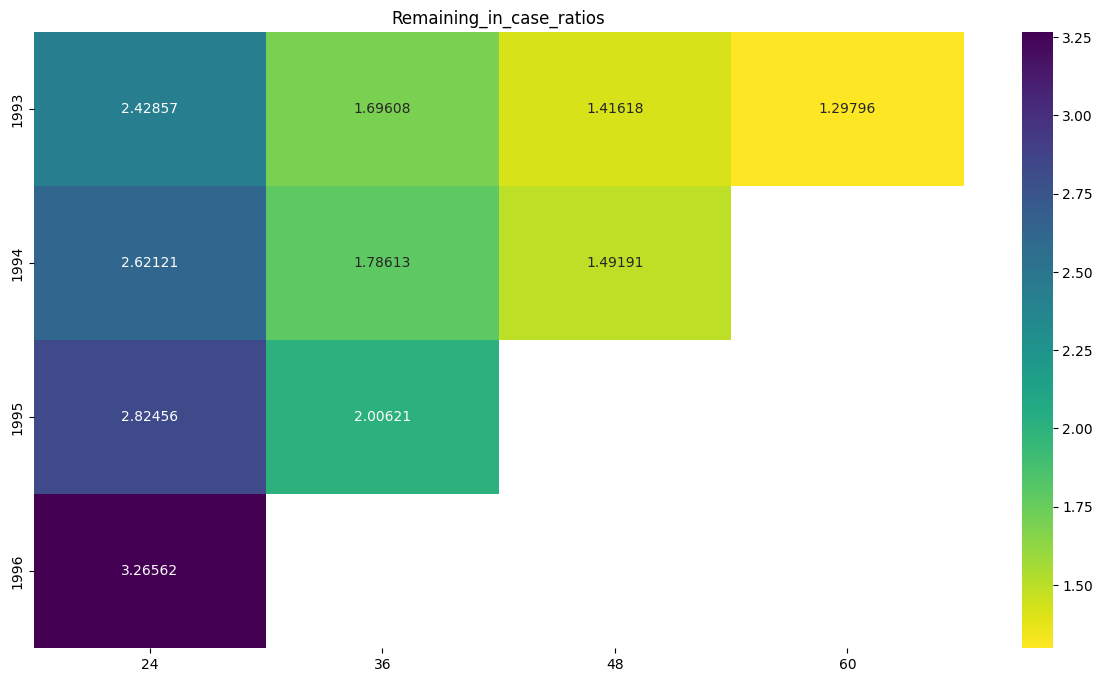



This is the case_out measures or averages Triangle
       Mean    Median  Months
0  2.784992  2.722887      24
1  1.829472  1.786127      36
2  1.454047  1.454047      48
3  1.297959  1.297959      60
----------------------------------------------------------------------------------------------------------------------------------------------------


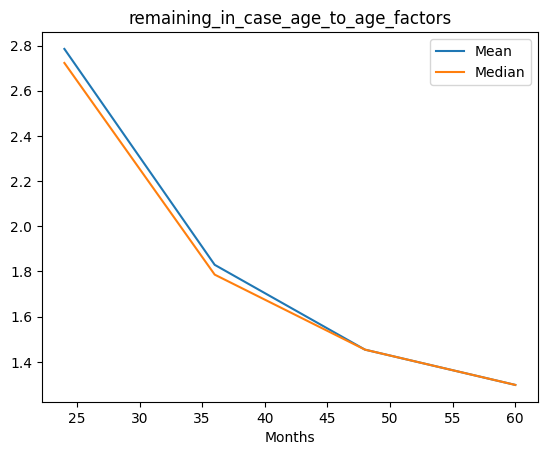



This is the paid incremental measures or averages Triangle
       Mean    Median  Months
0  0.032216  0.034128      24
1  0.028698  0.011561      36
2  0.000000  0.000000      48
3  0.004082  0.004082      60
----------------------------------------------------------------------------------------------------------------------------------------------------


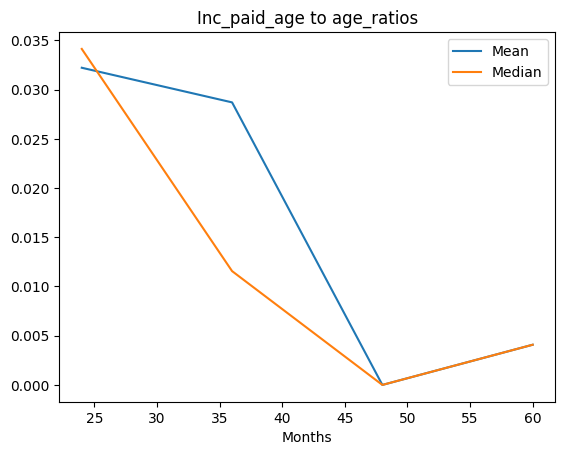



This is the filled case_outstanding Triangle
   AccidentYear  12       24       36       48       60
0          1993  42  102.000  173.000  245.000  318.000
1          1994  66  173.000  309.000  461.000  598.359
2          1995  57  161.000  323.000  469.657  609.596
3          1996  64  209.000  382.360  555.969  721.625
4          1997  88  245.079  448.365  651.944  846.197
----------------------------------------------------------------------------------------------------------------------------------------------------


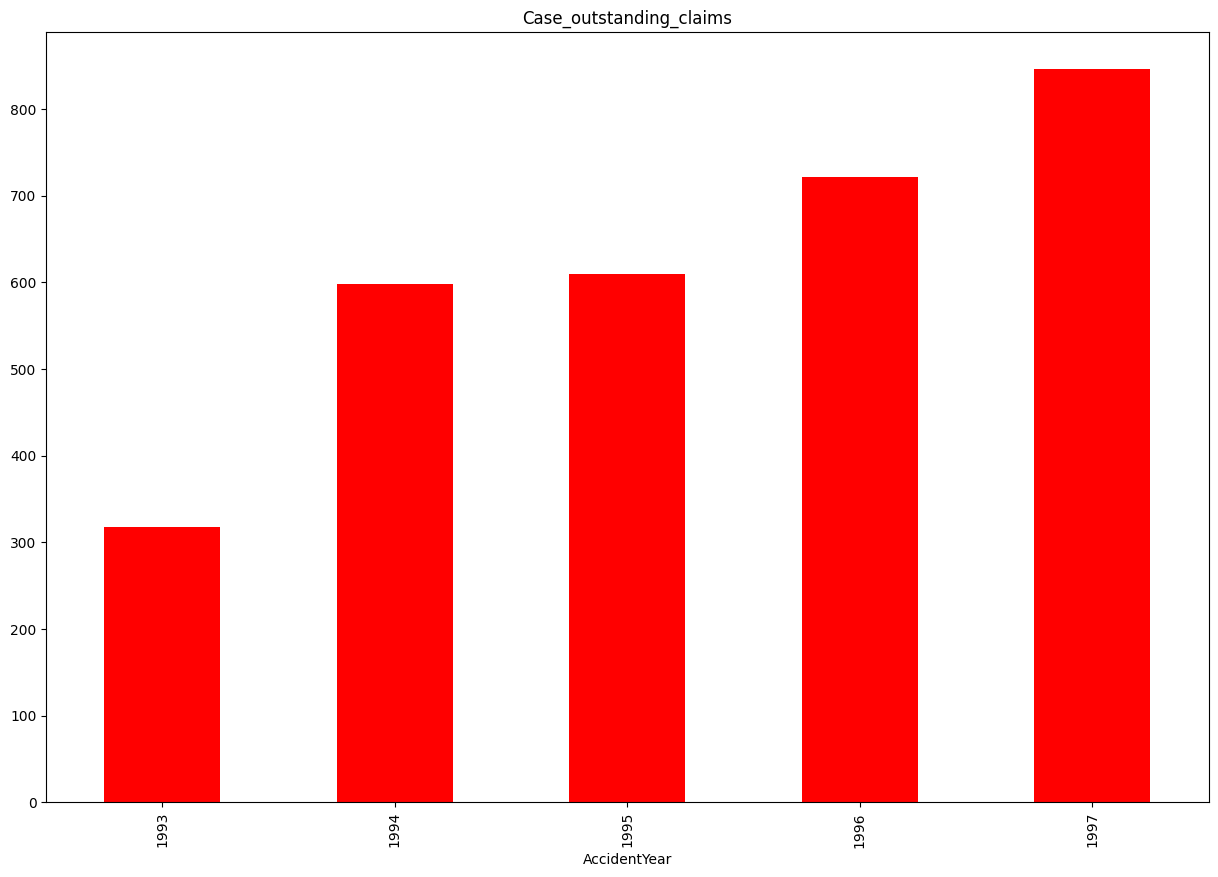



This is the cummulative filled incremental paid claims Triangle
   AccidentYear  12         24         36         48         60
0          1993   1   1.000000   1.000000   1.000000   2.000000
1          1994  10  14.000000  16.000000  16.000000  17.881633
2          1995  10  13.000000  25.000000  25.000000  26.916967
3          1996  36  37.000000  42.997942  42.997942  45.267203
4          1997   9  11.834978  18.868325  18.868325  21.529321


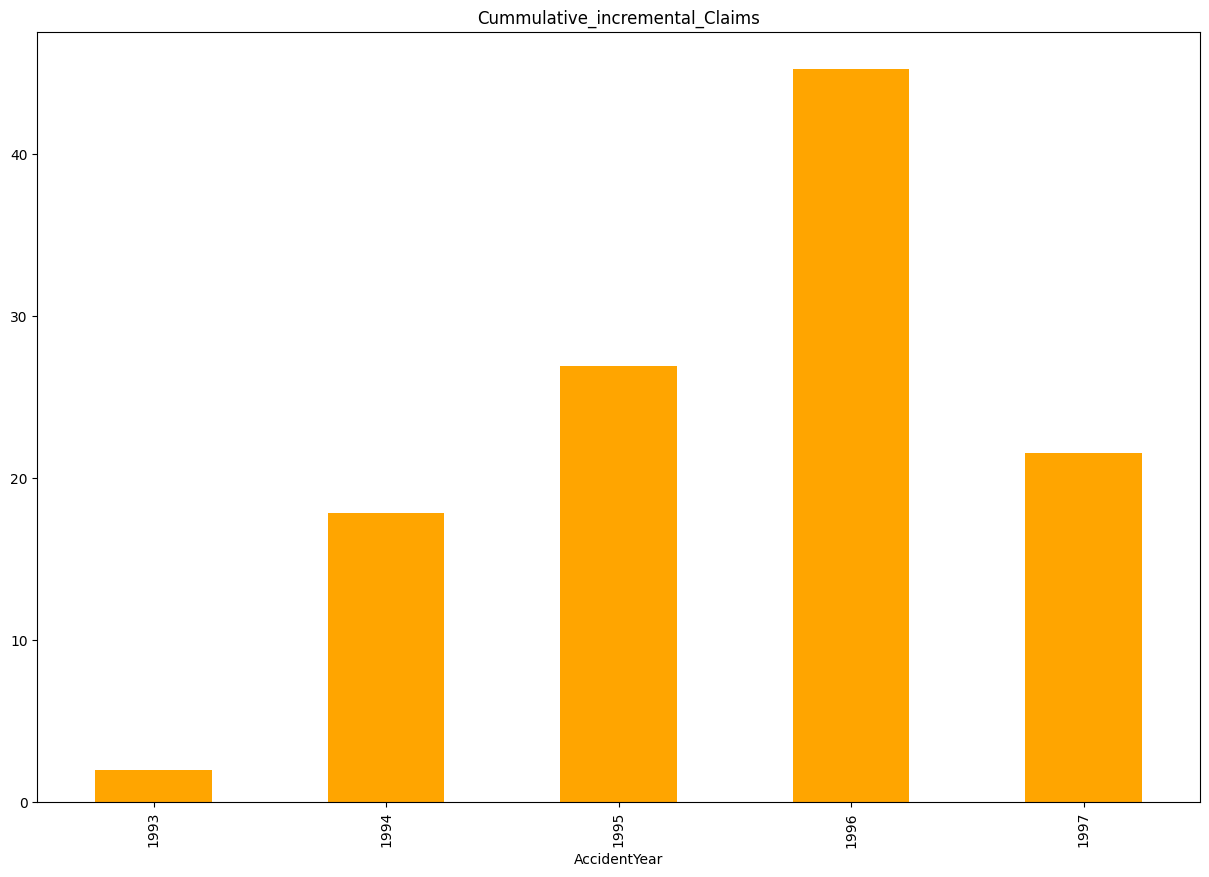

188
113.59512378757273
----------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------
The name of the dataset is: Middle States Ins Co Inc
the final dataset looks like this:
   AccidentYear   12    24    36    48    60    72    84    96   108   120
0          1993   25    81    77    77    77    77    77    77    77    77
1          1994  258   281   280   333   321   324   324   326   328   344
2          1995  364   423   551   540   535   522   520   520   520   520
3          1996  550   701   830   897   925   960  1011  1007  1007  1007
4          1997  966  1197  1333  1354  1382  1414  1412  1412  1412  1412
---------------------------------------------------------------------------------------------------------------------------------------------

<ipython-input-6-d76b96687e75>:86: RuntimeWarning: divide by zero encountered in scalar divide
  val.append(g/f)




This is the paid ratio Triangle
   AccidentYear        24        36        48   60
0          1993       inf -0.102564  0.000000  0.0
1          1994  0.174242 -0.001675  0.038489  NaN
2          1995  0.225191  0.133751       NaN  NaN
3          1996  0.360382       NaN       NaN  NaN
----------------------------------------------------------------------------------------------------------------------------------------------------


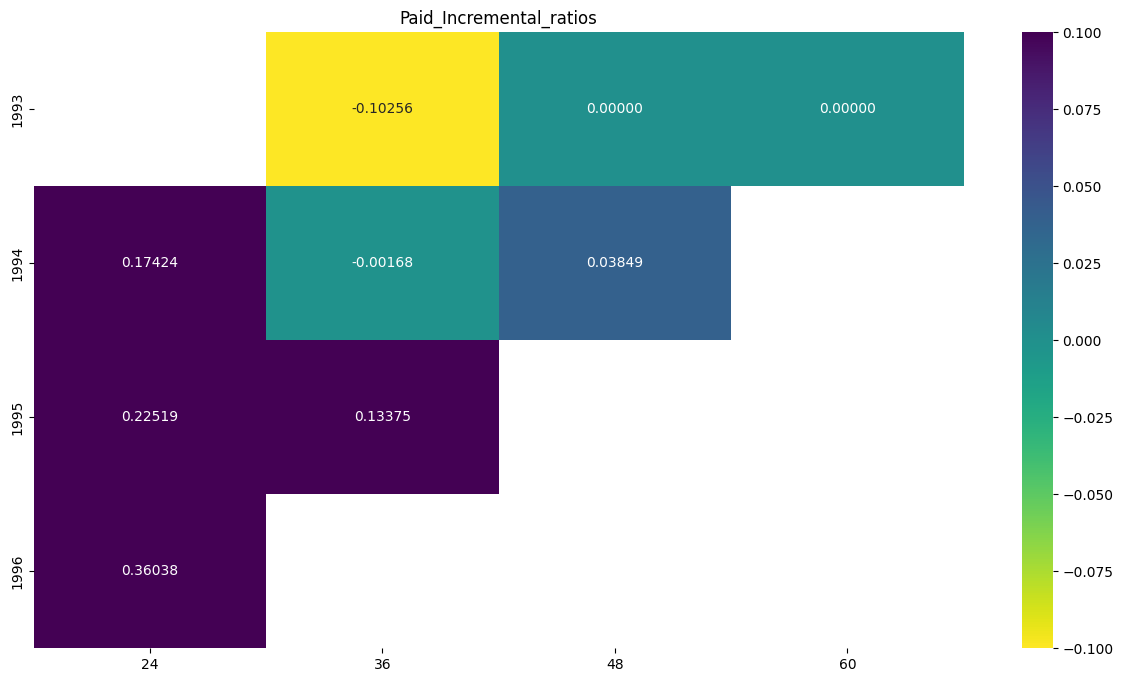

<ipython-input-6-d76b96687e75>:105: RuntimeWarning: divide by zero encountered in scalar divide
  c=self.d_triangle(self.case_outstanding).loc[i].at[li[j+1]]/self.d_triangle(self.case_outstanding).loc[i].at[li[j]]




This is the case_ratio_Triangle
   AccidentYear        24        36        48        60
0          1993       inf  4.076923  2.238994  1.769663
1          1994  4.522727  2.306533  1.767611       NaN
2          1995  3.652672  2.172414       NaN       NaN
3          1996  3.608592       NaN       NaN       NaN
----------------------------------------------------------------------------------------------------------------------------------------------------


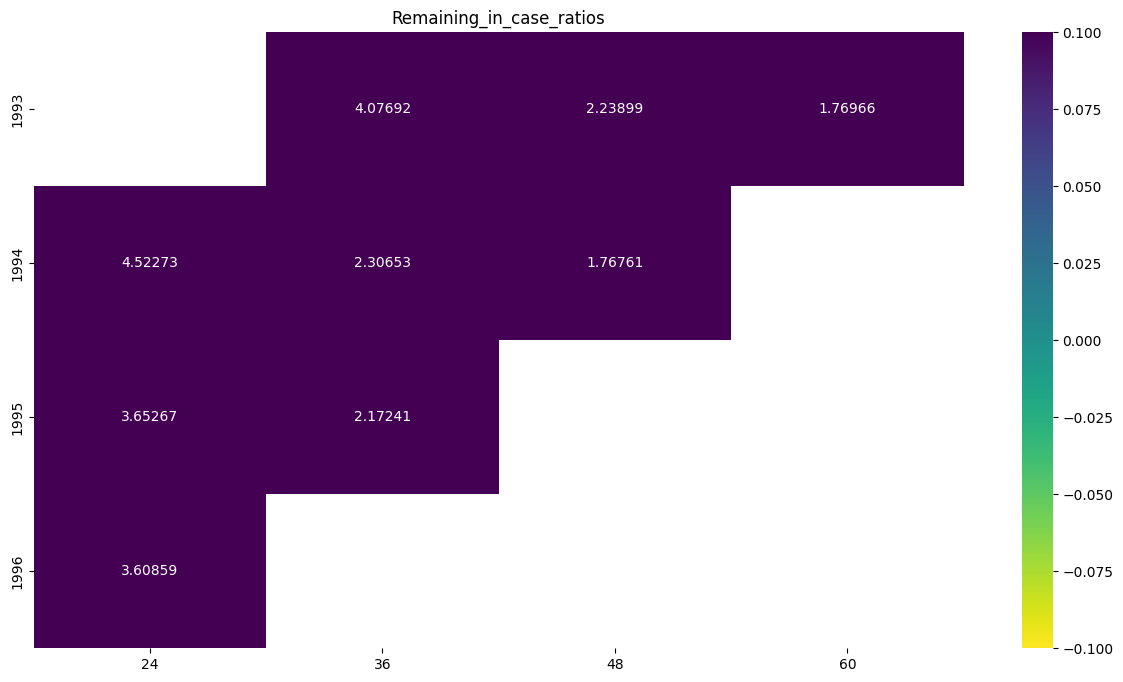



This is the case_out measures or averages Triangle
       Mean    Median  Months
0       inf  4.087700      24
1  2.851957  2.306533      36
2  2.003302  2.003302      48
3  1.769663  1.769663      60
----------------------------------------------------------------------------------------------------------------------------------------------------


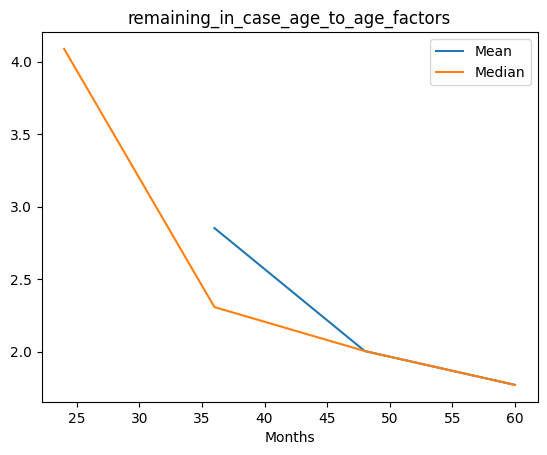



This is the paid incremental measures or averages Triangle
       Mean    Median  Months
0       inf  0.292786      24
1  0.009837 -0.001675      36
2  0.019245  0.019245      48
3  0.000000  0.000000      60
----------------------------------------------------------------------------------------------------------------------------------------------------


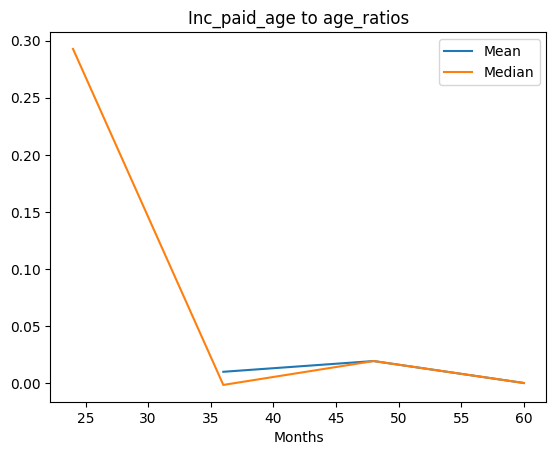



This is the filled case_outstanding Triangle
   AccidentYear   12      24        36        48         60
0          1993    0    39.0   159.000   356.000    630.000
1          1994  132   597.0  1377.000  2434.000   4307.360
2          1995  262   957.0  2079.000  4164.865   7370.407
3          1996  419  1512.0  4312.158  8638.556  15287.332
4          1997  437     inf       inf       inf        inf
----------------------------------------------------------------------------------------------------------------------------------------------------


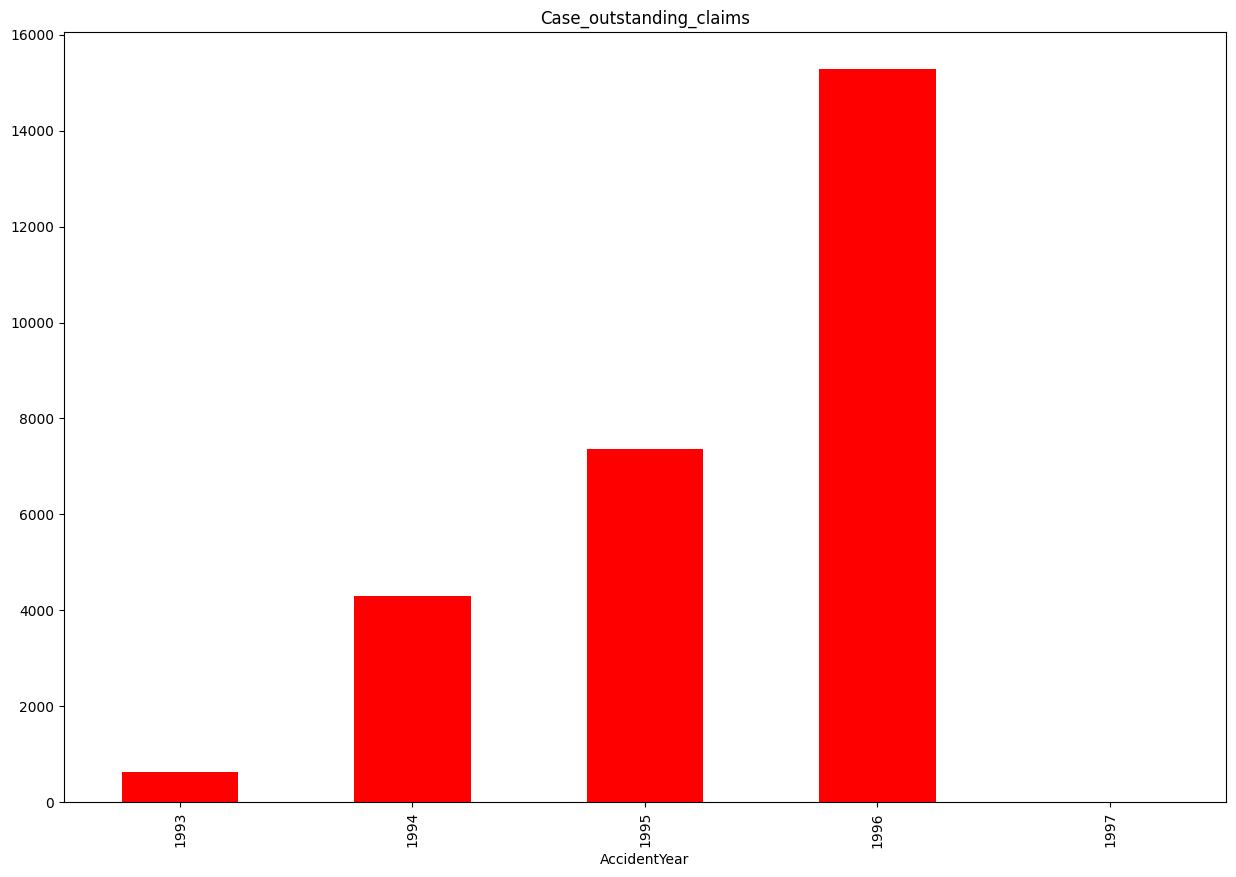

<ipython-input-6-d76b96687e75>:149: RuntimeWarning: invalid value encountered in scalar multiply
  paid_inc.loc[i,columns[j]]=(measure[method][j-2]*case_out.loc[i].at[columns[j-1]])




This is the cummulative filled incremental paid claims Triangle
   AccidentYear   12     24         36          48          60
0          1993   25   81.0   77.00000   77.000000   77.000000
1          1994  258  281.0  280.00000  333.000000  333.000000
2          1995  364  423.0  551.00000  591.009804  591.009804
3          1996  550  701.0  715.87413  798.860467  798.860467
4          1997  966    inf        inf         inf         NaN


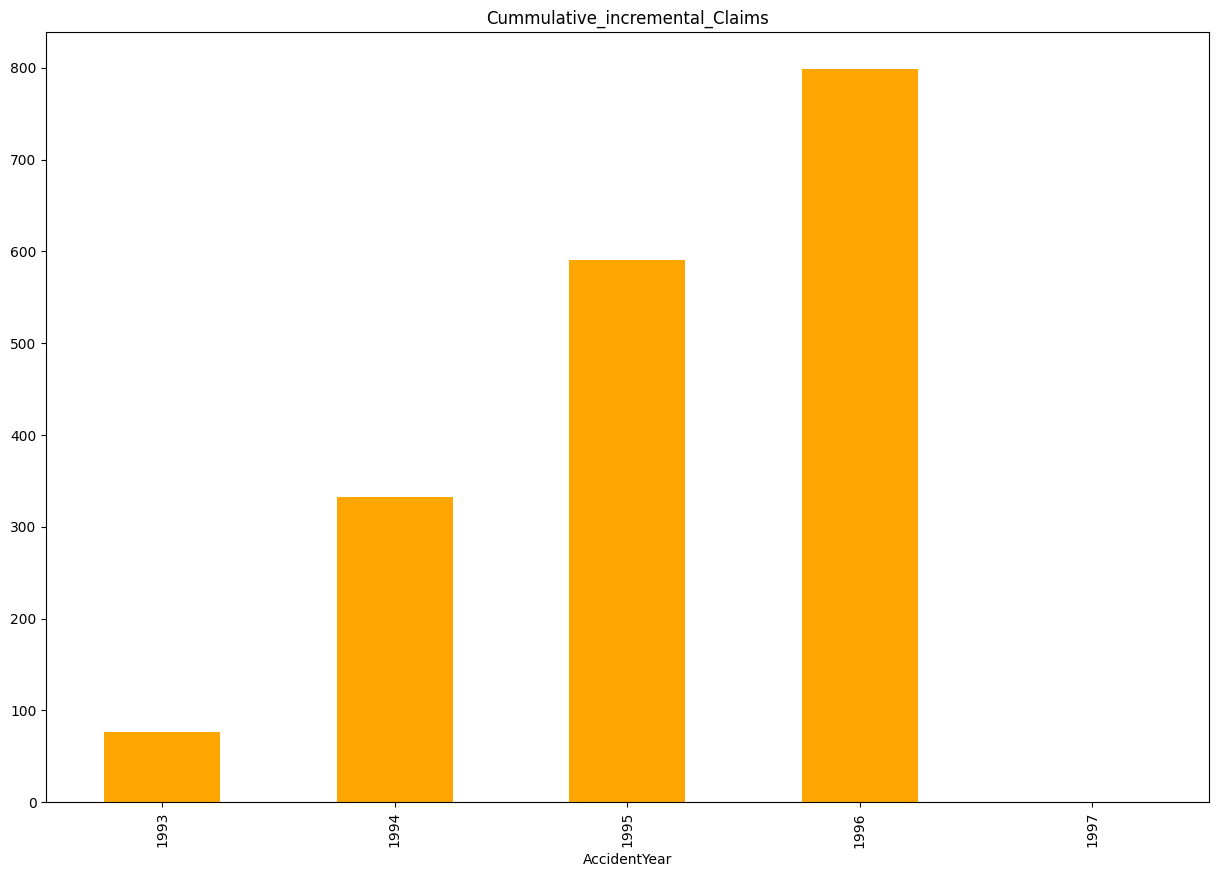

3240
1799.8702711215751
----------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------
The name of the dataset is: Contractors Bonding & Ins Co
the final dataset looks like this:
   AccidentYear   12   24   36   48   60   72   84   96  108  120
0          1995    2   10   10   10    8    8    8    8    8    8
1          1996   16   39   52   84   84   84   84   84   84   84
2          1997  103  174  264  290  290  294  294  294  296  296
----------------------------------------------------------------------------------------------------------------------------------------------------


This is the case_outstanding Triangle
   AccidentYear   12     24     36
0          1995   11   66.0  132.0
1          1996  115  376.0    NaN
2          1997  260    NaN 

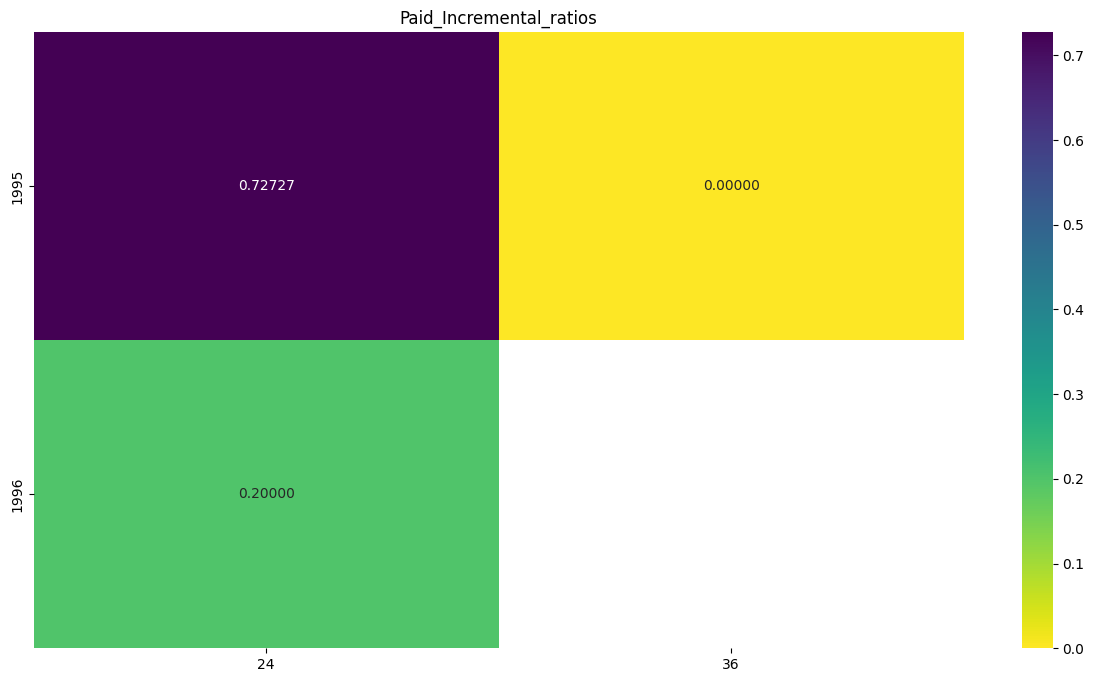



This is the case_ratio_Triangle
   AccidentYear        24   36
0          1995  6.000000  2.0
1          1996  3.269565  NaN
----------------------------------------------------------------------------------------------------------------------------------------------------


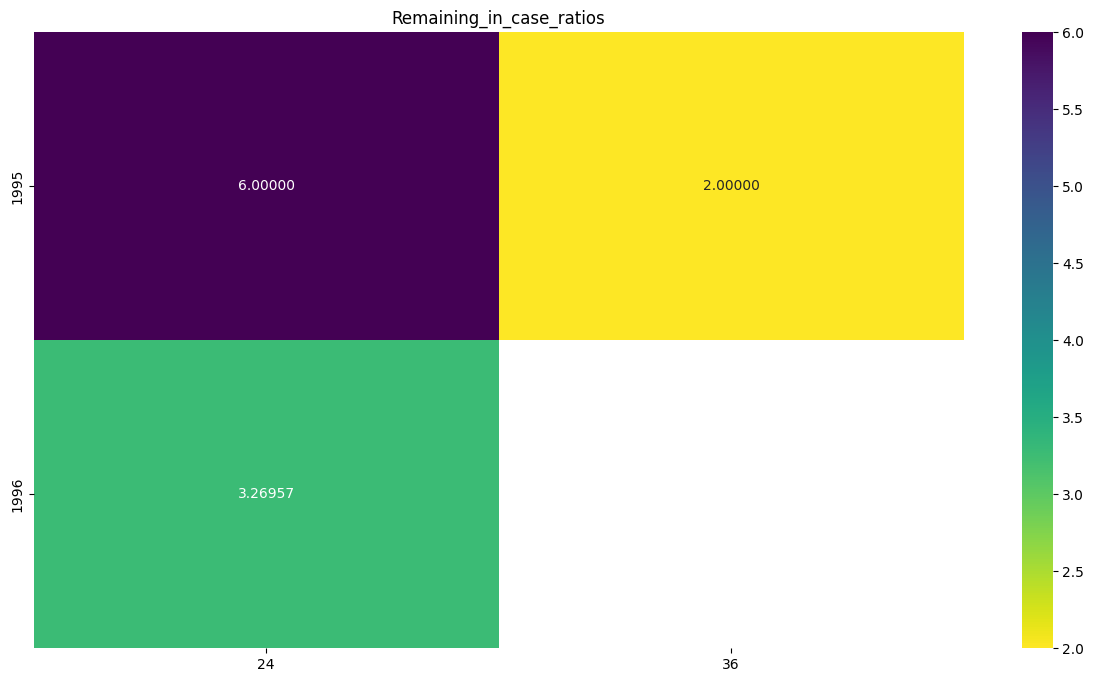



This is the case_out measures or averages Triangle
       Mean    Median  Months
0  4.634783  4.634783      24
1  2.000000  2.000000      36
----------------------------------------------------------------------------------------------------------------------------------------------------


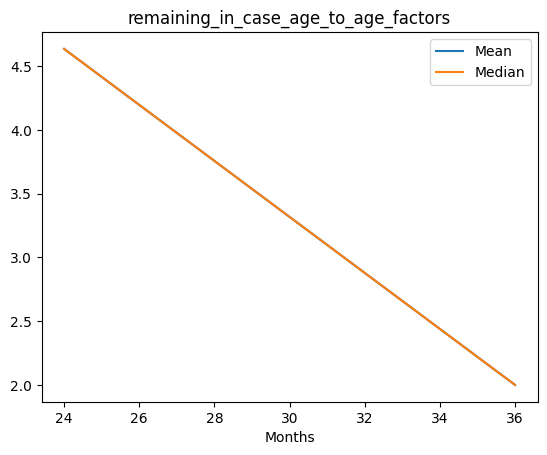



This is the paid incremental measures or averages Triangle
       Mean    Median  Months
0  0.463636  0.463636      24
1  0.000000  0.000000      36
----------------------------------------------------------------------------------------------------------------------------------------------------


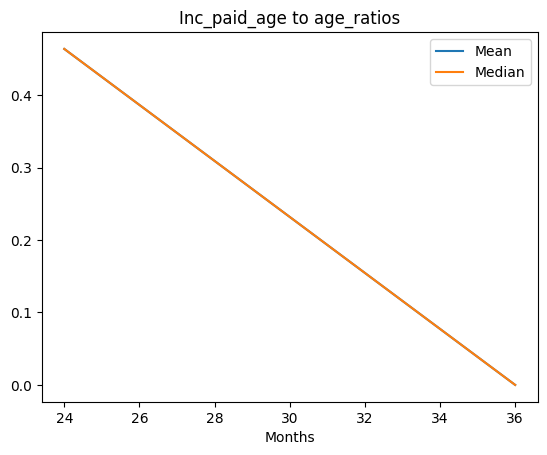



This is the filled case_outstanding Triangle
   AccidentYear   12        24        36
0          1995   11    66.000   132.000
1          1996  115   376.000   752.000
2          1997  260  1205.043  2410.086
----------------------------------------------------------------------------------------------------------------------------------------------------


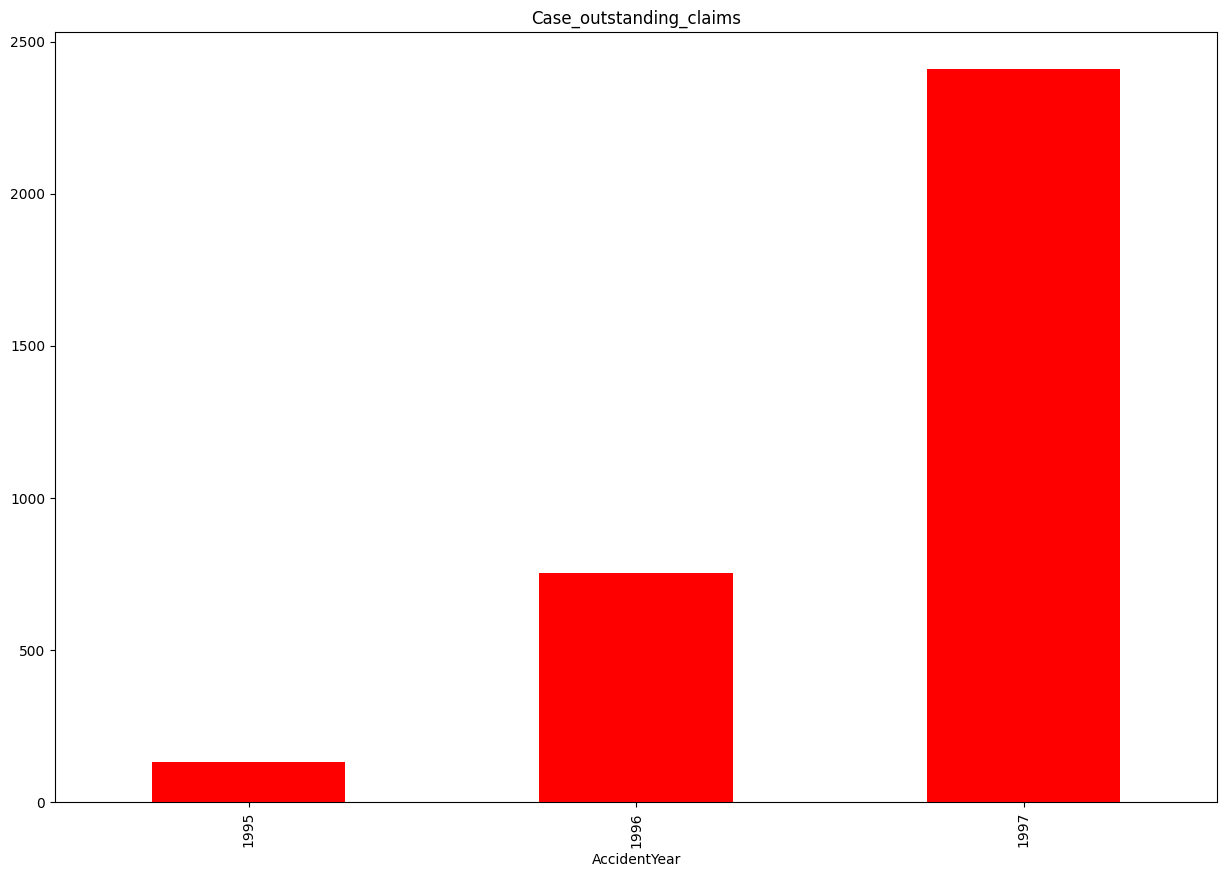



This is the cummulative filled incremental paid claims Triangle
   AccidentYear   12          24          36
0          1995    2   10.000000   10.000000
1          1996   16   39.000000   39.000000
2          1997  103  223.545455  223.545455


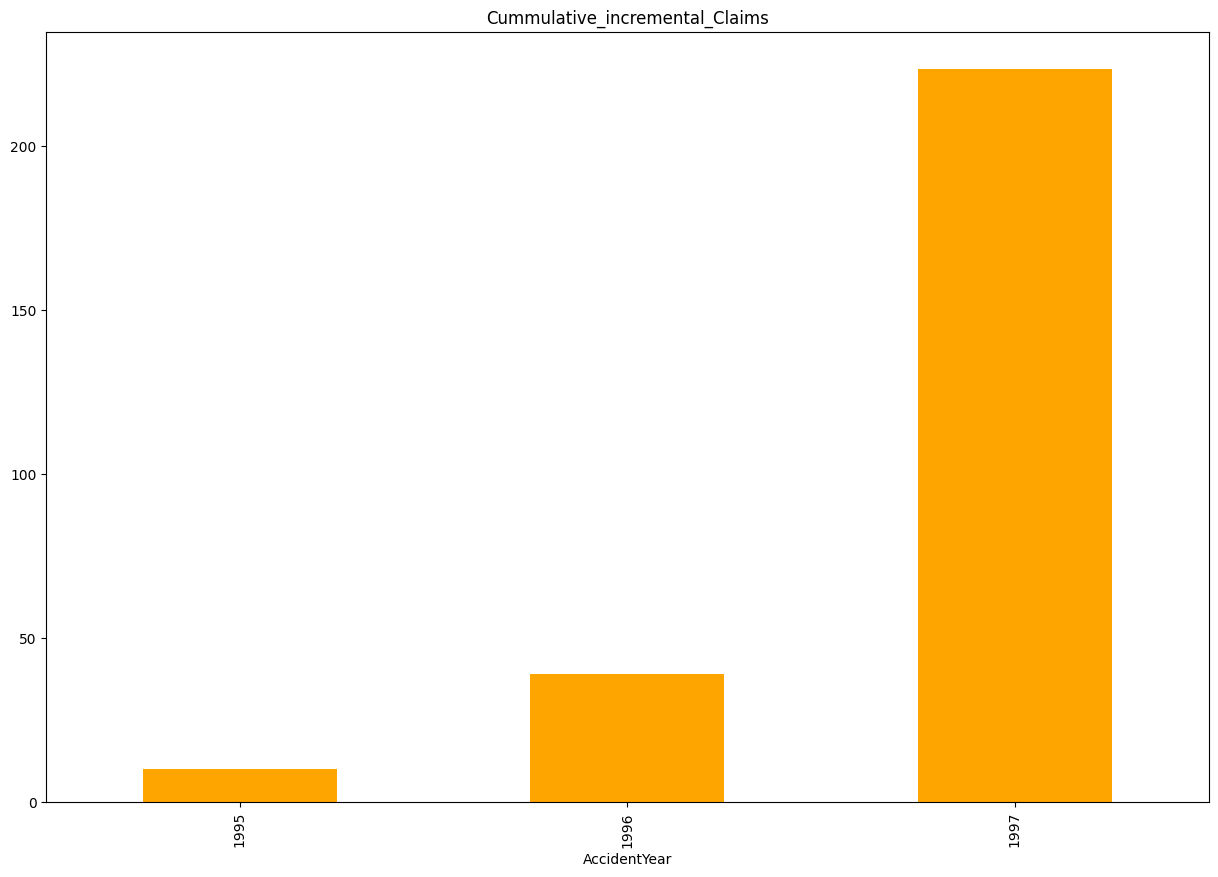

326
272.54545454545456
----------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------
The name of the dataset is: Pacific Specialty Ins Co
the final dataset looks like this:
   AccidentYear  12  24   36   48   60   72   84   96  108  120
0          1993   3  23   54   69   73   82   83   83   89   89
1          1994  14  40   61   73   76   78   79   88   88   88
2          1995   3  50   78  117  131  133  148  148  148  148
3          1996  15  63  111  135  145  160  160  160  160  162
4          1997  16  43   74  102  120  120  122  122  124  124
----------------------------------------------------------------------------------------------------------------------------------------------------


This is the case_outstanding Triangle
   AccidentYear   

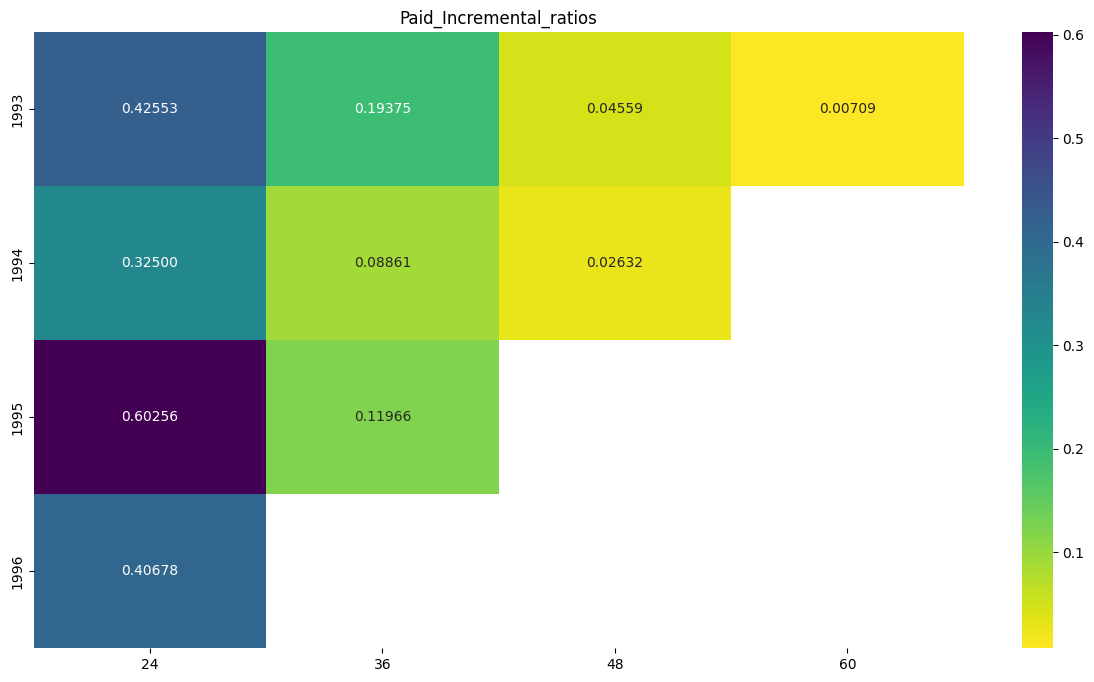



This is the case_ratio_Triangle
   AccidentYear        24        36        48        60
0          1993  3.404255  2.056250  1.714286  1.544326
1          1994  2.962500  1.924051  1.635965       NaN
2          1995  3.000000  2.059829       NaN       NaN
3          1996  2.881356       NaN       NaN       NaN
----------------------------------------------------------------------------------------------------------------------------------------------------


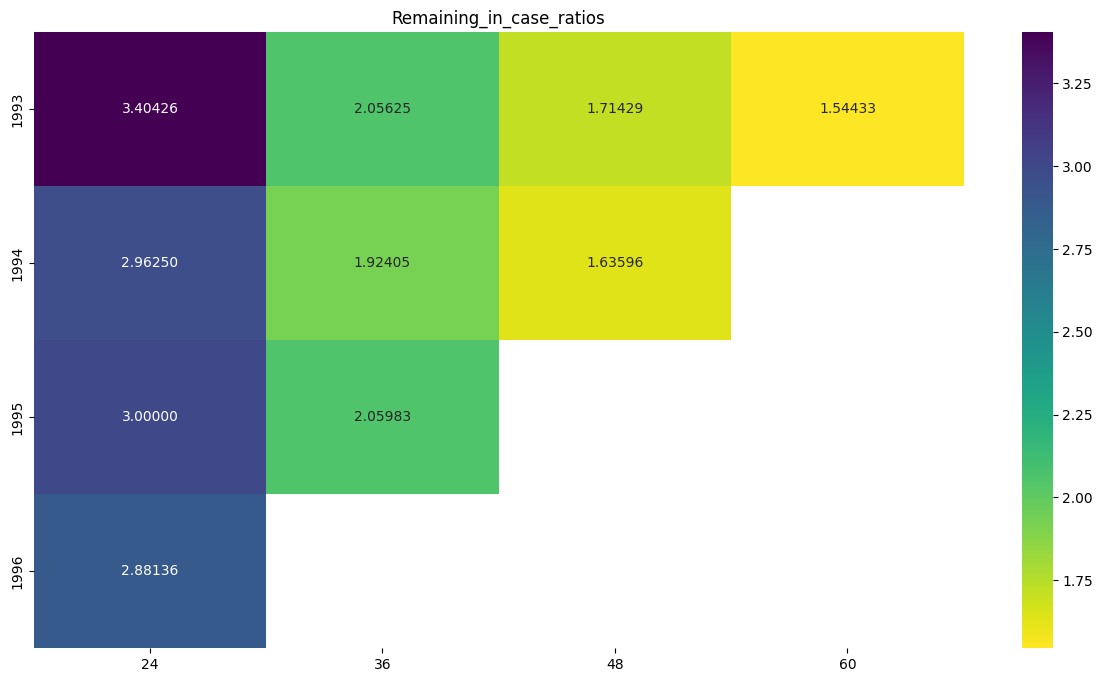



This is the case_out measures or averages Triangle
       Mean    Median  Months
0  3.062028  2.981250      24
1  2.013377  2.056250      36
2  1.675125  1.675125      48
3  1.544326  1.544326      60
----------------------------------------------------------------------------------------------------------------------------------------------------


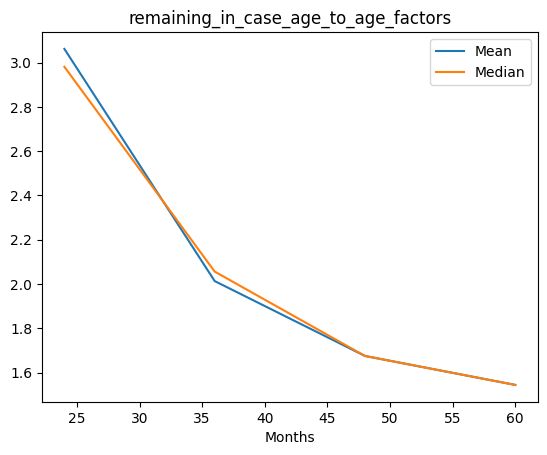



This is the paid incremental measures or averages Triangle
       Mean    Median  Months
0  0.439969  0.416156      24
1  0.134005  0.119658      36
2  0.035954  0.035954      48
3  0.007092  0.007092      60
----------------------------------------------------------------------------------------------------------------------------------------------------


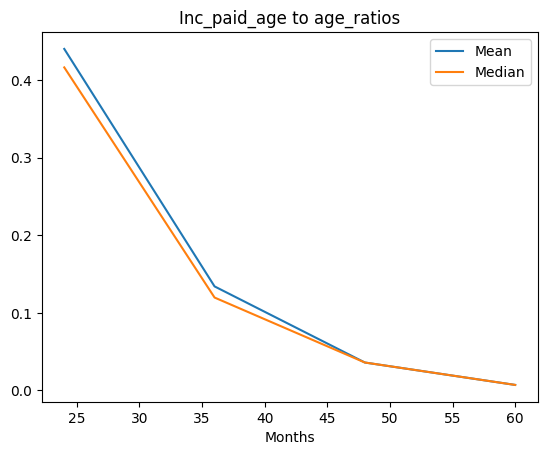



This is the filled case_outstanding Triangle
   AccidentYear   12      24       36        48        60
0          1993   47  160.00  329.000   564.000   871.000
1          1994   80  237.00  456.000   746.000  1152.067
2          1995   78  234.00  482.000   807.410  1246.904
3          1996  118  340.00  684.548  1146.704  1770.885
4          1997   69  211.28  425.386   712.575  1100.448
----------------------------------------------------------------------------------------------------------------------------------------------------


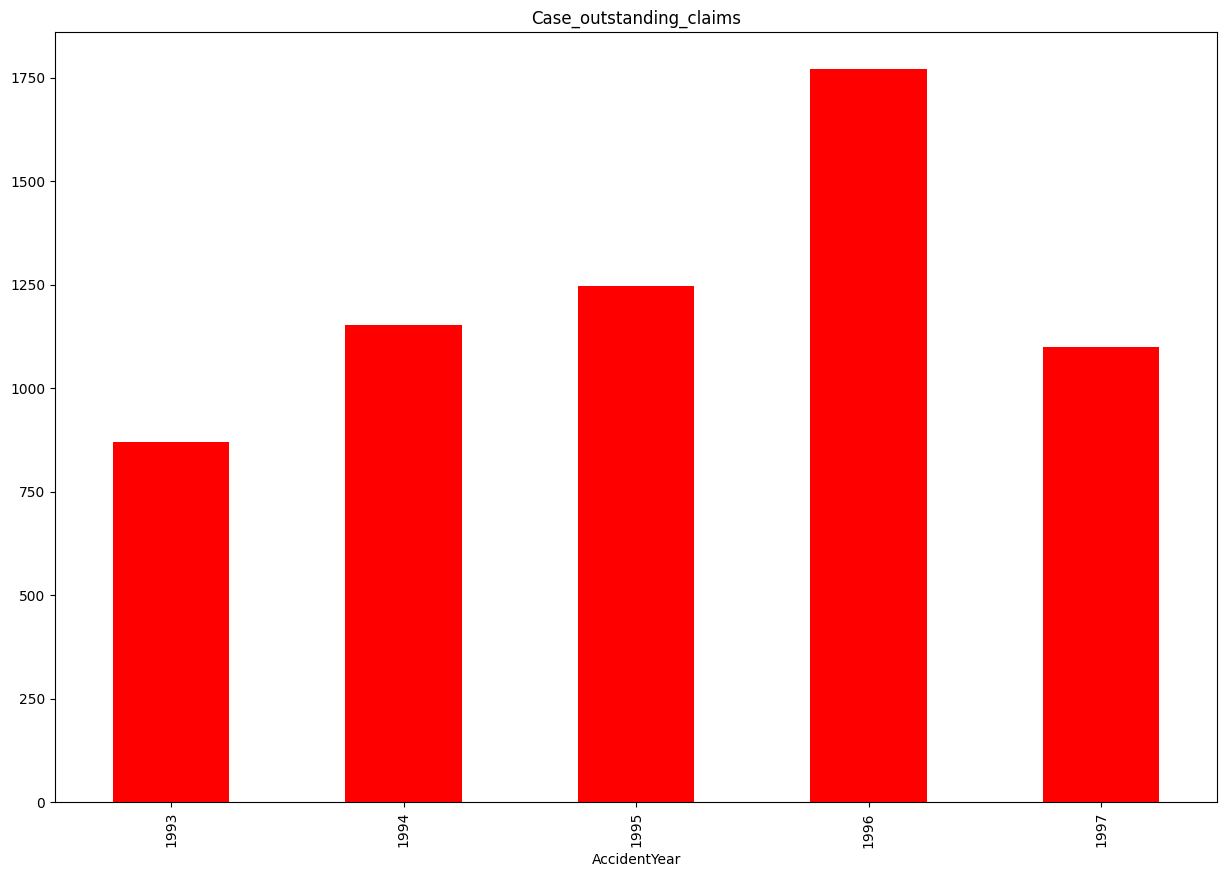



This is the cummulative filled incremental paid claims Triangle
   AccidentYear  12         24          36          48          60
0          1993   3  23.000000   54.000000   69.000000   73.000000
1          1994  14  40.000000   61.000000   73.000000   78.290780
2          1995   3  50.000000   78.000000   95.329947  101.056259
3          1996  15  63.000000  108.561781  133.174189  141.306842
4          1997  16  46.357855   74.670482   89.964916   95.018639


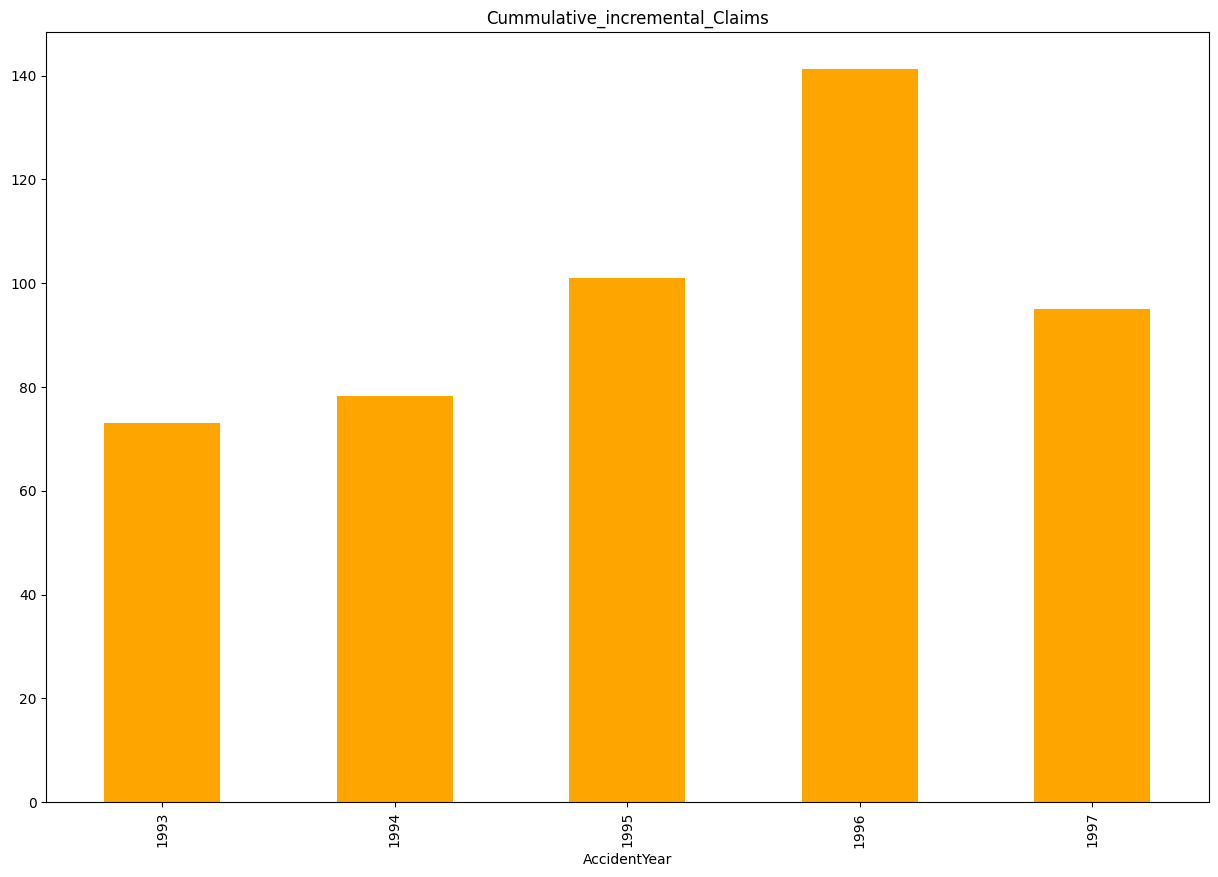

545
488.6725200065395
----------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------
The name of the dataset is: Omega Ins Co
the final dataset looks like this:
   AccidentYear  12   24   36   48     60     72     84     96    108    120
0          1988   7   24   28   30   30.0   30.0   30.0   30.0   30.0   30.0
1          1989   5   15   32   35   35.0   35.0   35.0   35.0   35.0   35.0
2          1990  65  127  128  128  128.0  142.0  142.0  142.0  142.0  142.0
3          1991   0    0    0    0    NaN    NaN    NaN    NaN    NaN    NaN
----------------------------------------------------------------------------------------------------------------------------------------------------


This is the case_outstanding Triangle
   AccidentYear  12   24   36 

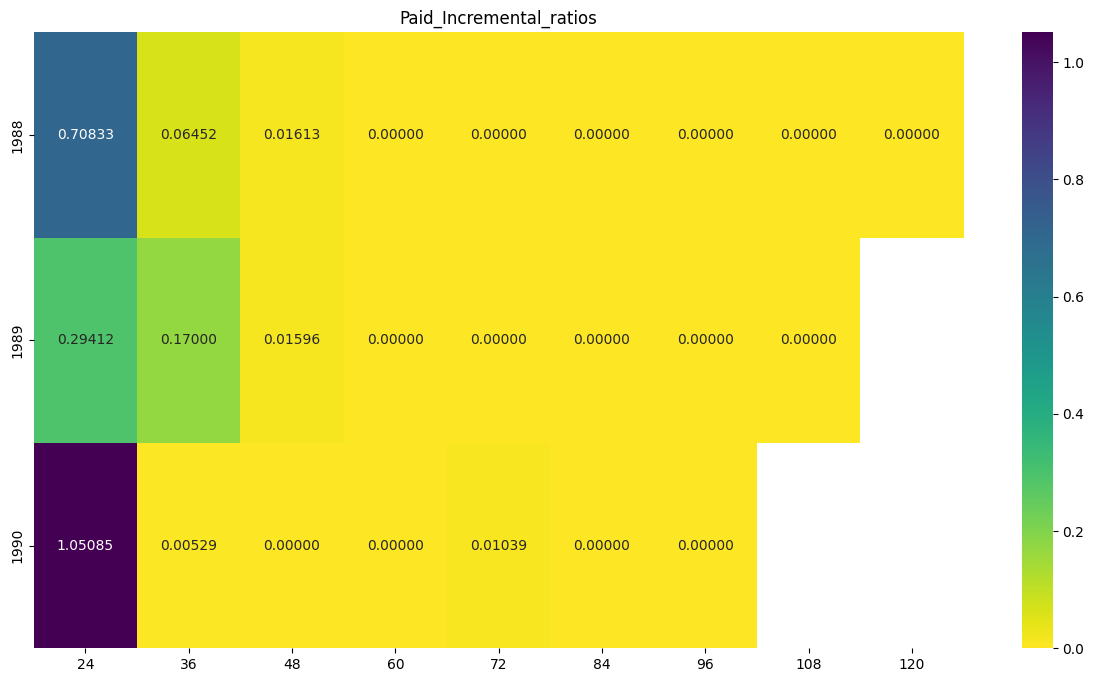



This is the case_ratio_Triangle
   AccidentYear        24        36        48        60        72        84  \
0          1988  2.583333  2.000000  1.725806  1.560748  1.449102  1.371901   
1          1989  2.941176  1.880000  1.712766  1.568323  1.463366  1.364005   
2          1990  3.203390  2.365079  1.863535  1.617047  1.476615  1.394168   

         96       108      120  
0  1.316265  1.274600  1.24237  
1  1.301587  1.258384      NaN  
2  1.333934       NaN      NaN  
----------------------------------------------------------------------------------------------------------------------------------------------------


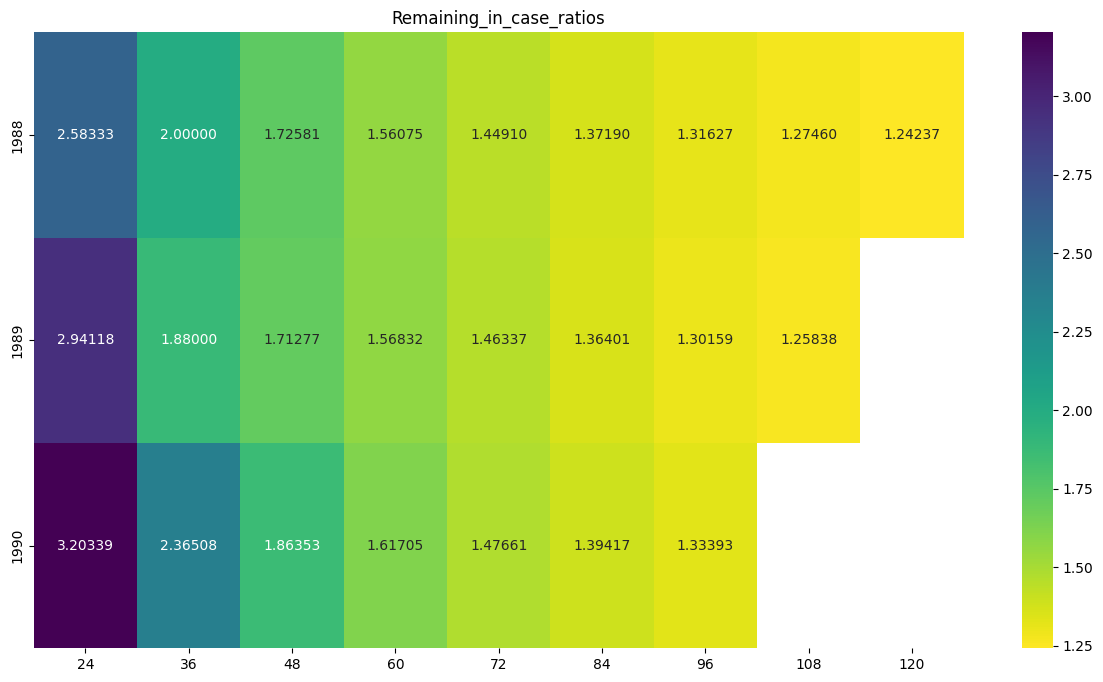



This is the case_out measures or averages Triangle
       Mean    Median  Months
0  2.909300  2.941176      24
1  2.081693  2.000000      36
2  1.767369  1.725806      48
3  1.582039  1.568323      60
4  1.463028  1.463366      72
5  1.376691  1.371901      84
6  1.317262  1.316265      96
7  1.266492  1.266492     108
8  1.242370  1.242370     120
----------------------------------------------------------------------------------------------------------------------------------------------------


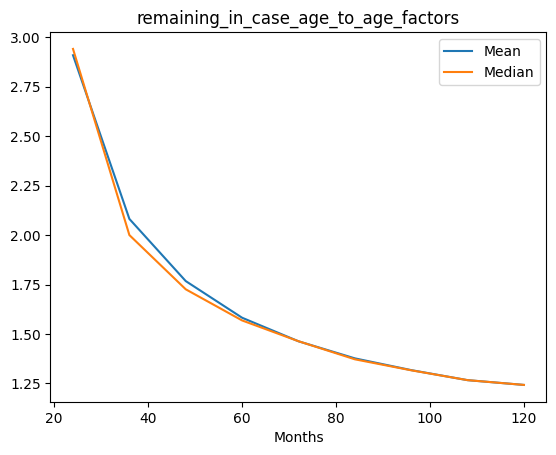



This is the paid incremental measures or averages Triangle
       Mean    Median  Months
0  0.684433  0.708333      24
1  0.079936  0.064516      36
2  0.010695  0.015957      48
3  0.000000  0.000000      60
4  0.003464  0.000000      72
5  0.000000  0.000000      84
6  0.000000  0.000000      96
7  0.000000  0.000000     108
8  0.000000  0.000000     120
----------------------------------------------------------------------------------------------------------------------------------------------------


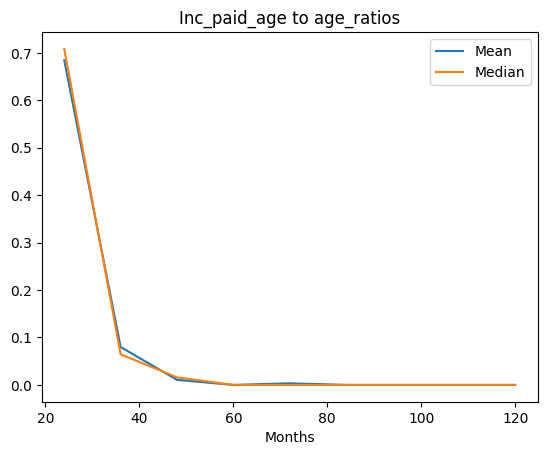



This is the filled case_outstanding Triangle
   AccidentYear  12   24   36   48        60        72        84        96  \
0          1988  24   62  124  214   334.000   484.000   664.000   874.000   
1          1989  34  100  188  322   505.000   739.000  1008.000  1312.000   
2          1990  59  189  447  833  1347.000  1989.000  2773.000  3699.000   
3          1991   5   14   27   43    68.028    99.527   137.018   180.489   

        108       120  
0  1114.000  1384.000  
1  1651.000  2051.153  
2  4684.753  5820.196  
3   228.588   283.991  
----------------------------------------------------------------------------------------------------------------------------------------------------


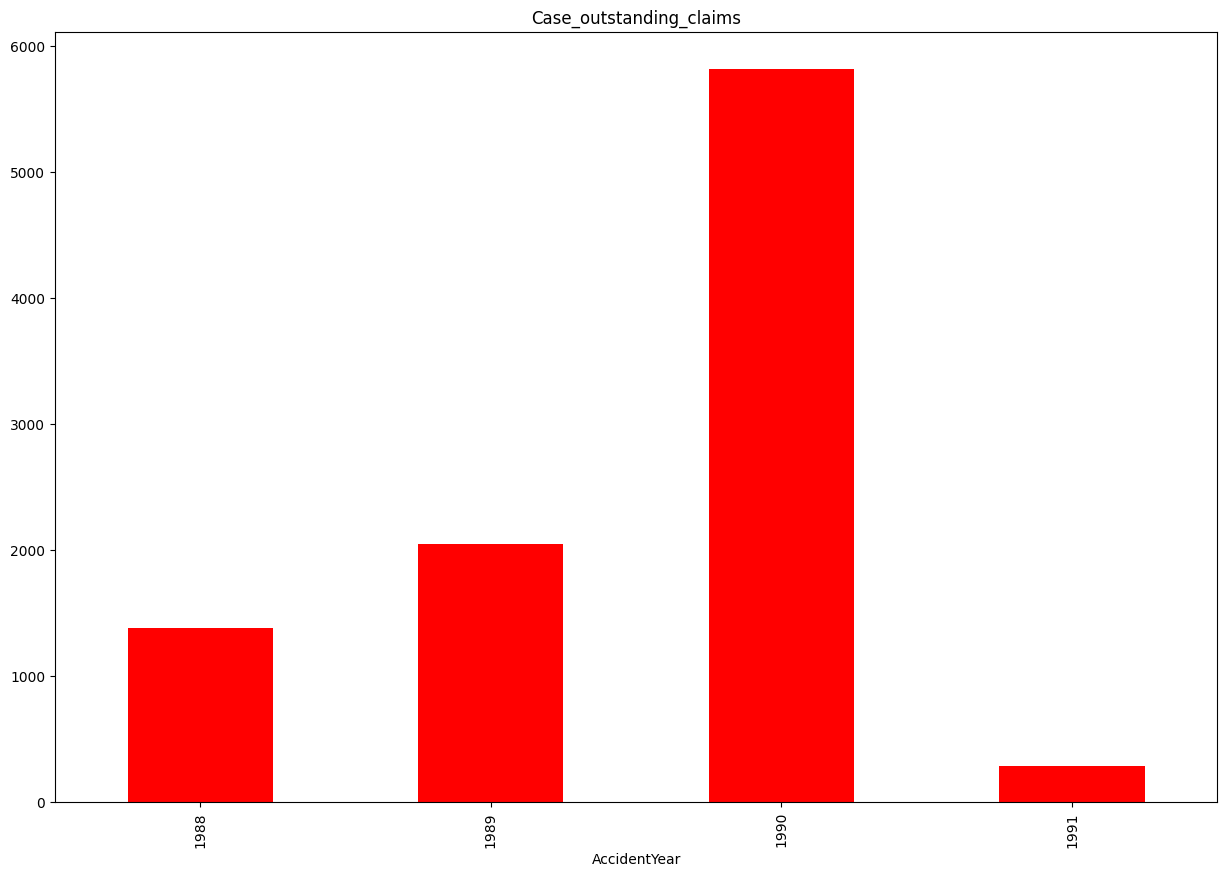



This is the cummulative filled incremental paid claims Triangle
   AccidentYear  12   24   36   48     60          72          84          96  \
0          1988   7   24   28   30   30.0   30.000000   30.000000   30.000000   
1          1989   5   15   32   35   35.0   35.000000   35.000000   35.000000   
2          1990  65  127  128  128  128.0  142.000000  142.000000  142.000000   
3          1991   0    0    0    0    0.0    0.235682    0.235682    0.235682   

          108         120  
0   30.000000   30.000000  
1   35.000000   35.000000  
2  142.000000  142.000000  
3    0.235682    0.235682  


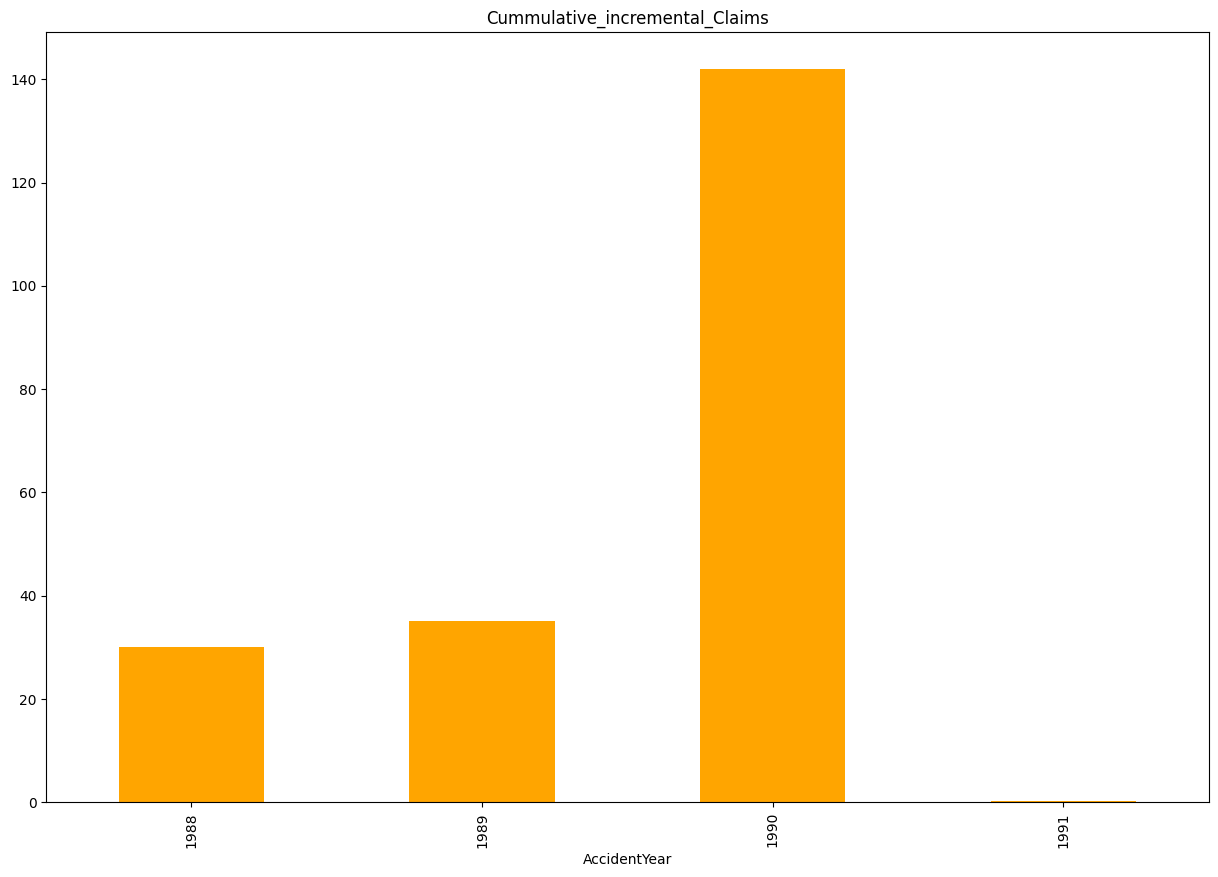

207.0
207.2356822568671
----------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------
The name of the dataset is: Southern Group Ind Inc
the final dataset looks like this:
   AccidentYear   12   24   36   48   60   72     84     96    108    120
0          1991  126  301  471  527  527  527  527.0  527.0  527.0  524.0
1          1992   69  104  120  220  249  249  249.0  249.0  248.0  248.0
2          1993   46   54   93  100  100   92   92.0   92.0   92.0   92.0
3          1994    1    1    1    1    1    1    1.0    1.0    1.0    1.0
4          1995    5    5    5    5    5    5    NaN    NaN    NaN    NaN
----------------------------------------------------------------------------------------------------------------------------------------------------

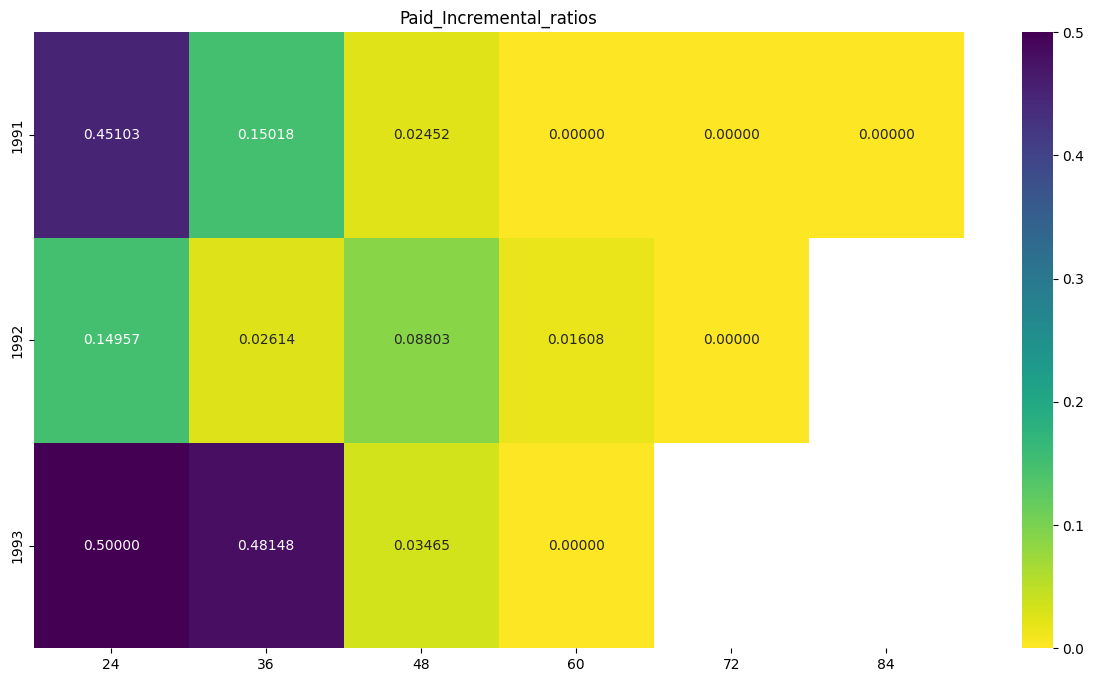



This is the case_ratio_Triangle
   AccidentYear        24        36        48        60        72        84
0          1991  2.917526  2.017668  1.741681  1.563600  1.447106  1.368848
1          1992  2.615385  1.856209  1.588028  1.495565  1.425871       NaN
2          1993  5.062500  2.493827  2.064356  1.757794       NaN       NaN
----------------------------------------------------------------------------------------------------------------------------------------------------


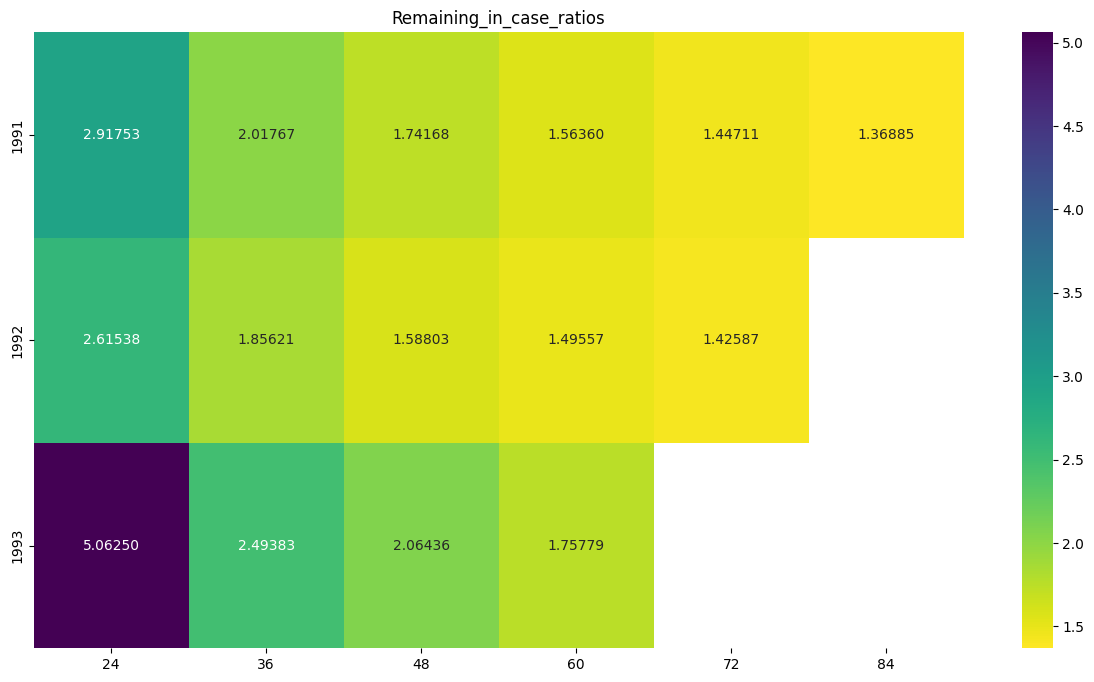



This is the case_out measures or averages Triangle
       Mean    Median  Months
0  3.531803  2.917526      24
1  2.122568  2.017668      36
2  1.798022  1.741681      48
3  1.605653  1.563600      60
4  1.436489  1.436489      72
5  1.368848  1.368848      84
----------------------------------------------------------------------------------------------------------------------------------------------------


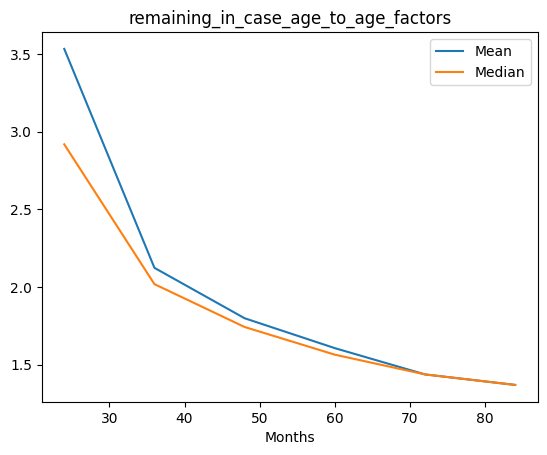



This is the paid incremental measures or averages Triangle
       Mean    Median  Months
0  0.366868  0.451031      24
1  0.219267  0.150177      36
2  0.049067  0.034653      48
3  0.005358  0.000000      60
4  0.000000  0.000000      72
5  0.000000  0.000000      84
----------------------------------------------------------------------------------------------------------------------------------------------------


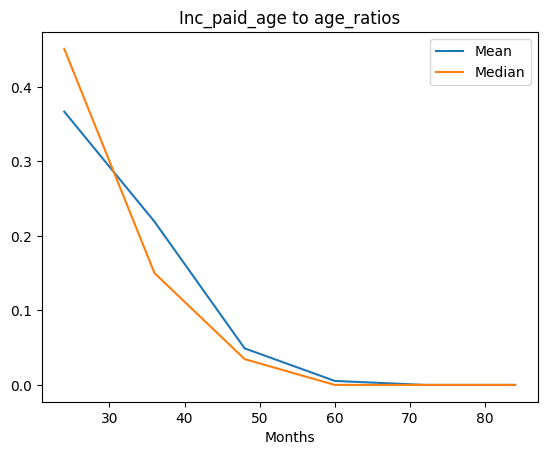



This is the filled case_outstanding Triangle
   AccidentYear   12    24    36    48        60        72         84
0          1991  388  1132  2284  3978  6220.000  9001.000  12321.000
1          1992  234   612  1136  1804  2698.000  3847.000   5265.958
2          1993   16    81   202   417   733.000  1052.946   1441.323
3          1994    0     1     3     6     9.634    13.839     18.943
----------------------------------------------------------------------------------------------------------------------------------------------------


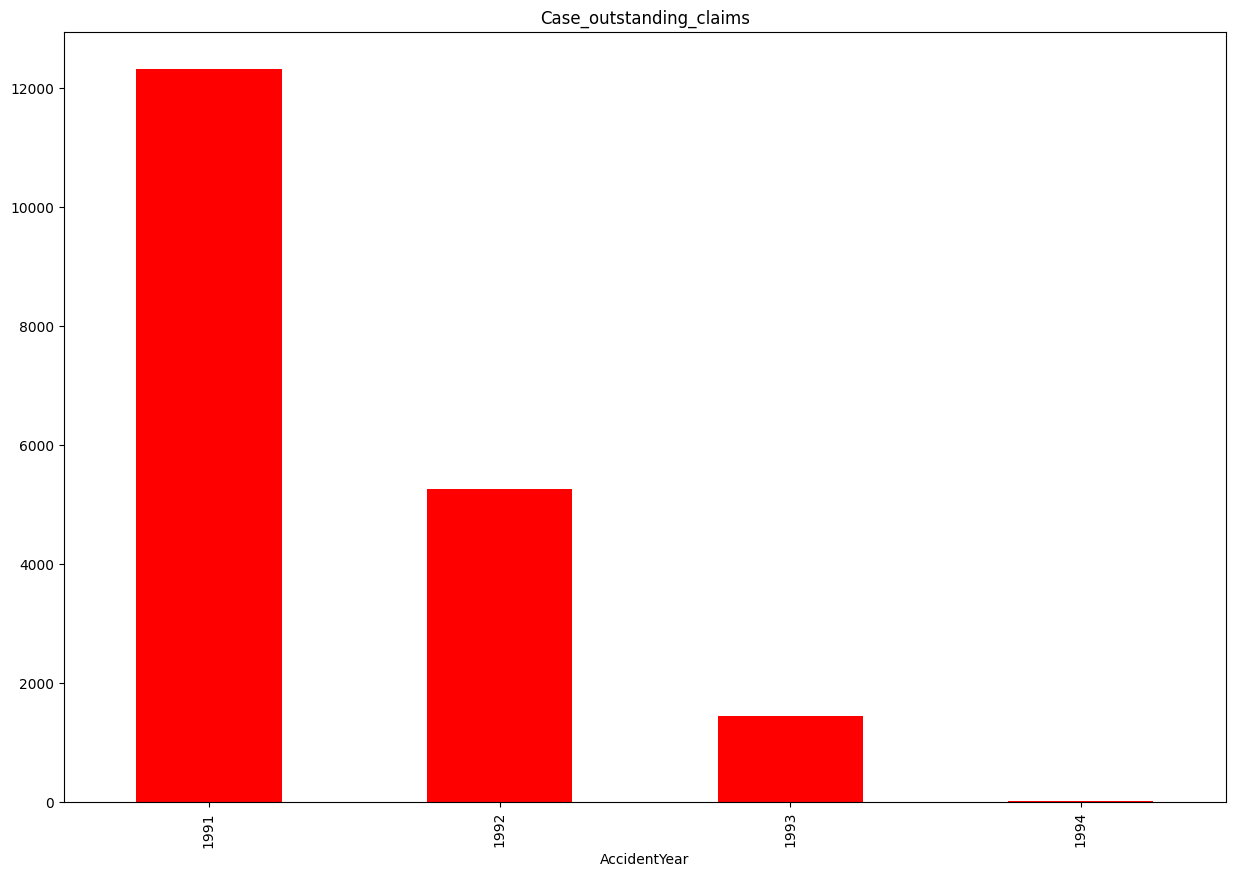



This is the cummulative filled incremental paid claims Triangle
   AccidentYear   12   24   36   48          60          72          84
0          1991  126  301  471  527  527.000000  527.000000  527.000000
1          1992   69  104  120  220  249.000000  249.000000  249.000000
2          1993   46   54   93  100  100.000000  100.000000  100.000000
3          1994    1    1    1    1    1.032151    1.032151    1.032151


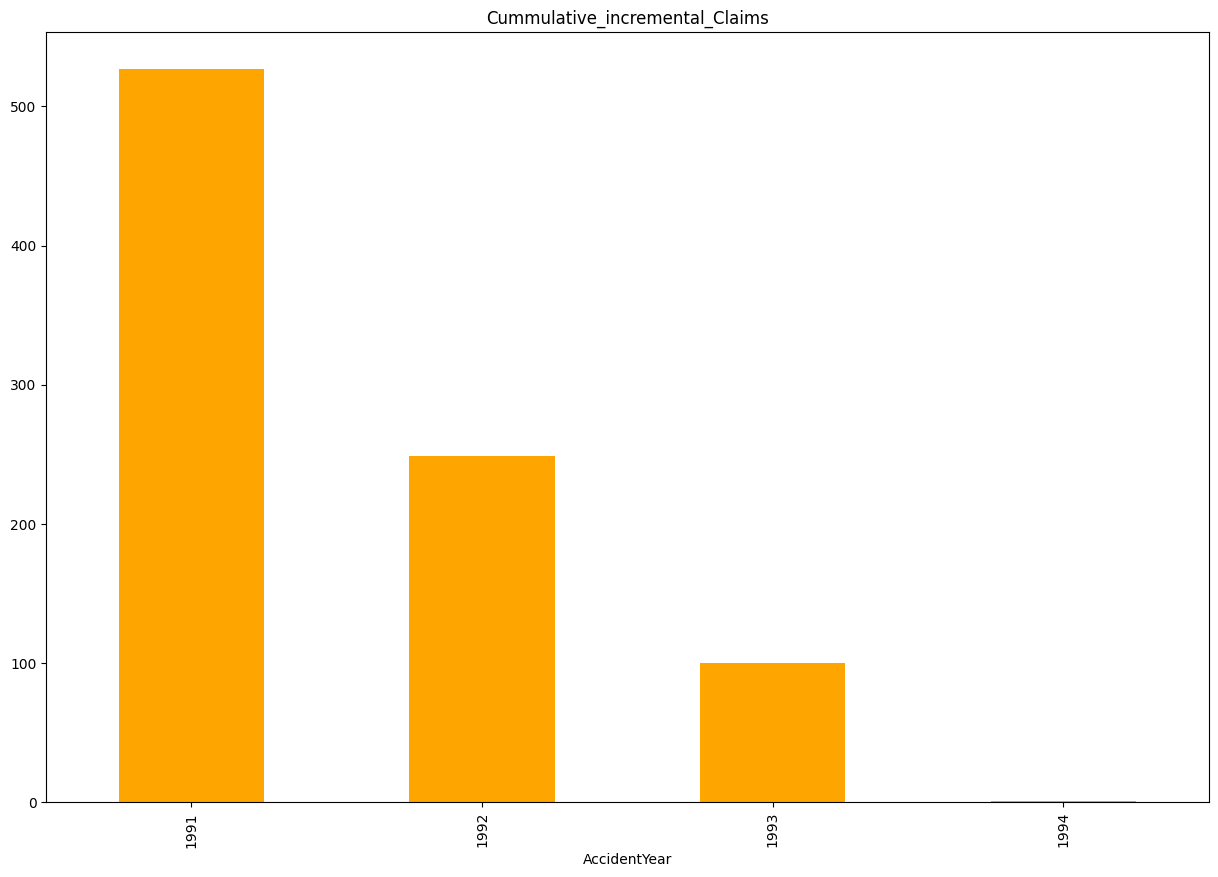

869.0
877.0321507760532
----------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------
The name of the dataset is: Nova Cas Co
the final dataset looks like this:
   AccidentYear  12  24  36  48  60  72  84    96   108   120
0          1994  26  36  79  79  79  79  80  79.0  79.0  79.0
1          1995  25  37  69  69  69  69  69  69.0  69.0  69.0
2          1996  46  40  40  40  40  40  40  40.0  40.0  40.0
3          1997   1   1   1   1   1   1   1   NaN   NaN   NaN
----------------------------------------------------------------------------------------------------------------------------------------------------


This is the case_outstanding Triangle
   AccidentYear  12   24     36     48
0          1994  70  212  423.0  719.0
1          1995  50  166  

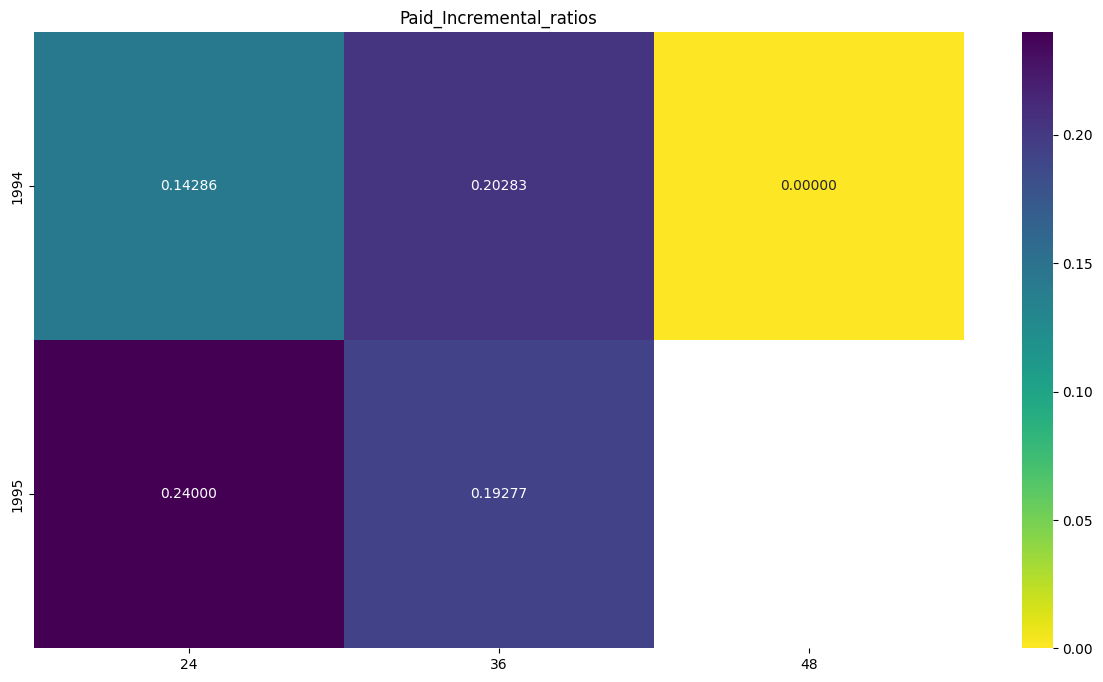



This is the case_ratio_Triangle
   AccidentYear        24        36        48
0          1994  3.028571  1.995283  1.699764
1          1995  3.320000  1.987952       NaN
----------------------------------------------------------------------------------------------------------------------------------------------------


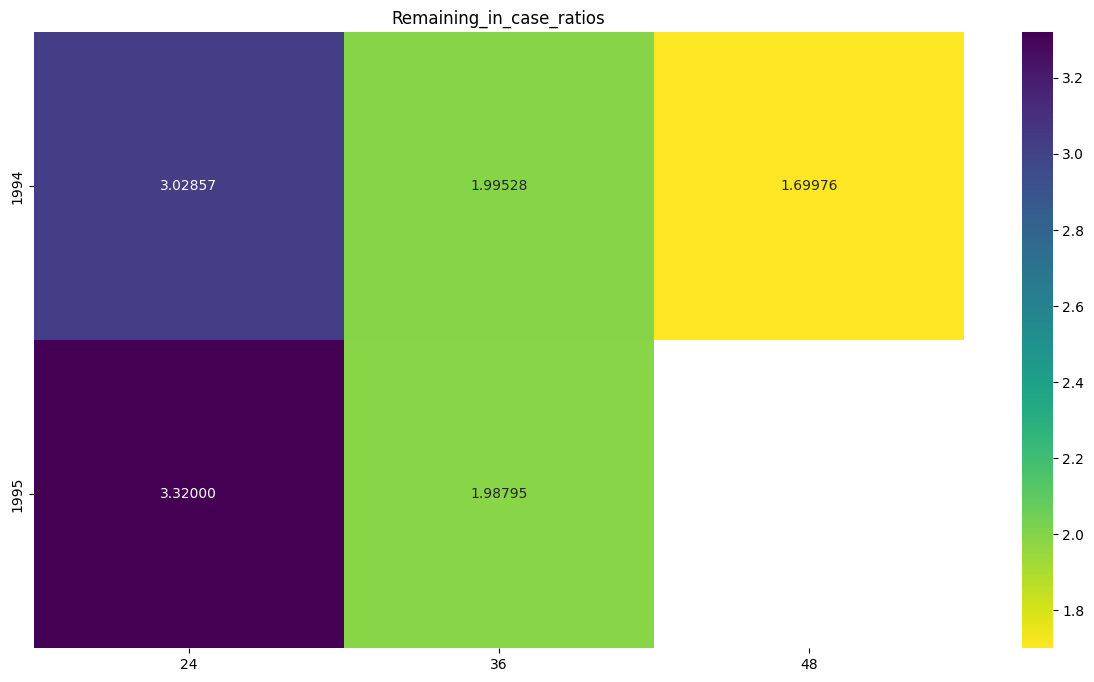



This is the case_out measures or averages Triangle
       Mean    Median  Months
0  3.174286  3.174286      24
1  1.991617  1.991617      36
2  1.699764  1.699764      48
----------------------------------------------------------------------------------------------------------------------------------------------------


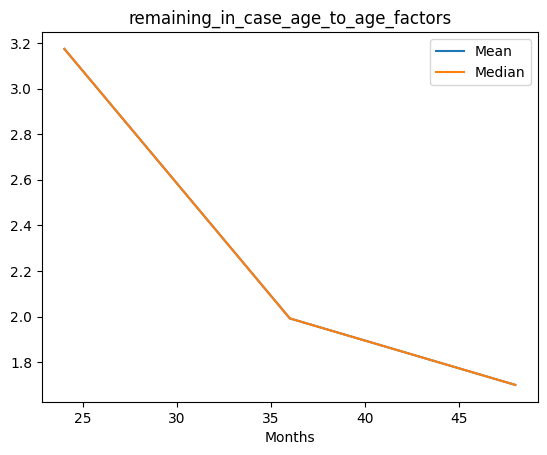



This is the paid incremental measures or averages Triangle
       Mean    Median  Months
0  0.191429  0.191429      24
1  0.197801  0.197801      36
2  0.000000  0.000000      48
----------------------------------------------------------------------------------------------------------------------------------------------------


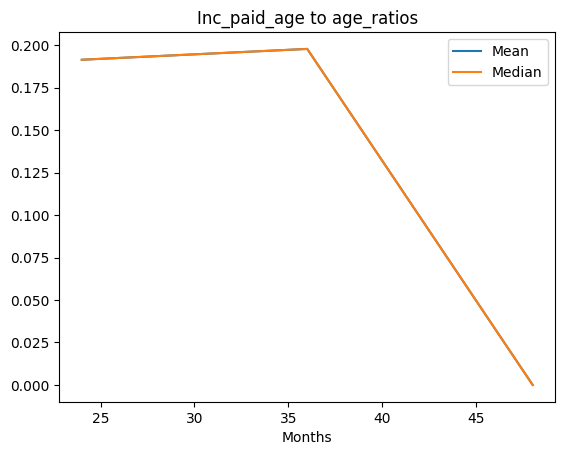



This is the filled case_outstanding Triangle
   AccidentYear  12   24       36       48
0          1994  70  212  423.000  719.000
1          1995  50  166  330.000  560.922
2          1996  48  148  294.759  501.021
----------------------------------------------------------------------------------------------------------------------------------------------------


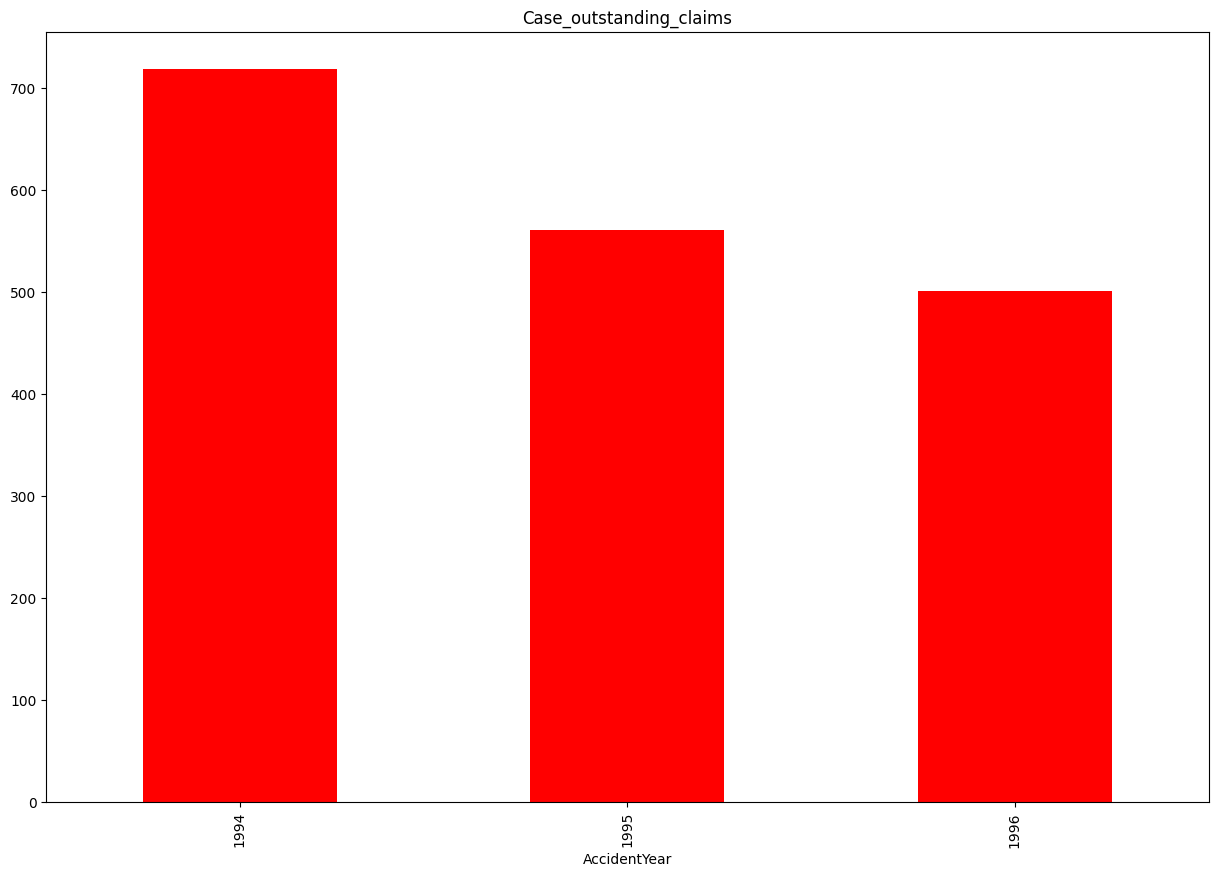



This is the cummulative filled incremental paid claims Triangle
   AccidentYear  12  24         36         48
0          1994  26  36  79.000000  79.000000
1          1995  25  37  69.000000  69.000000
2          1996  46  40  69.274494  69.274494


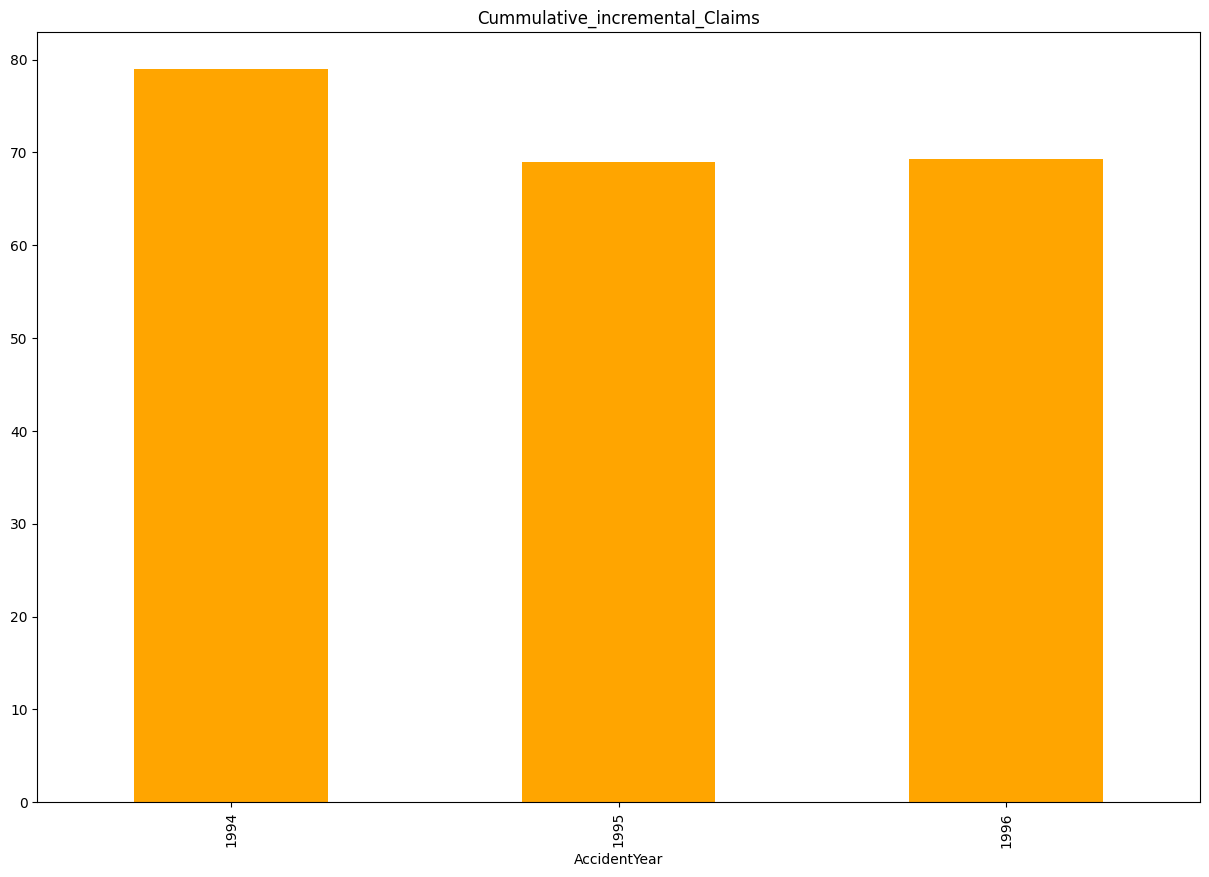

189
217.27449420322802
----------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------
The name of the dataset is: Atlantic Cas Ins Co
the final dataset looks like this:
   AccidentYear  12  24  36  48   60     72    84    96   108   120
0          1992   4   4   4   4    4    NaN   NaN   NaN   NaN   NaN
1          1993   3   3   3   3    3    3.0   NaN   NaN   NaN   NaN
2          1994  20  21  21  21   21   21.0  21.0   NaN   NaN   NaN
3          1995  48  51  53  53   53   53.0  53.0  54.0   NaN   NaN
4          1996  41  56  61  66  116  116.0  88.0  88.0  89.0  89.0
5          1997  28  37  44  44   44   44.0  44.0  44.0  44.0  44.0
------------------------------------------------------------------------------------------------------------------------

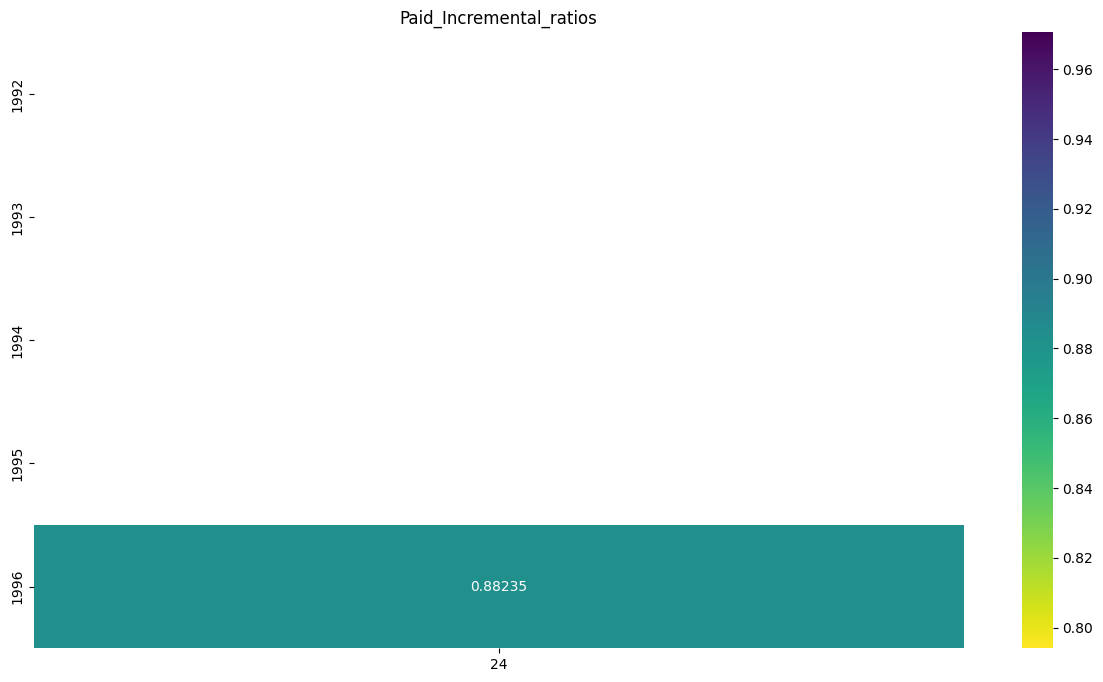



This is the case_ratio_Triangle
   AccidentYear        24
0          1992       NaN
1          1993       NaN
2          1994       NaN
3          1995       NaN
4          1996  4.411765
----------------------------------------------------------------------------------------------------------------------------------------------------


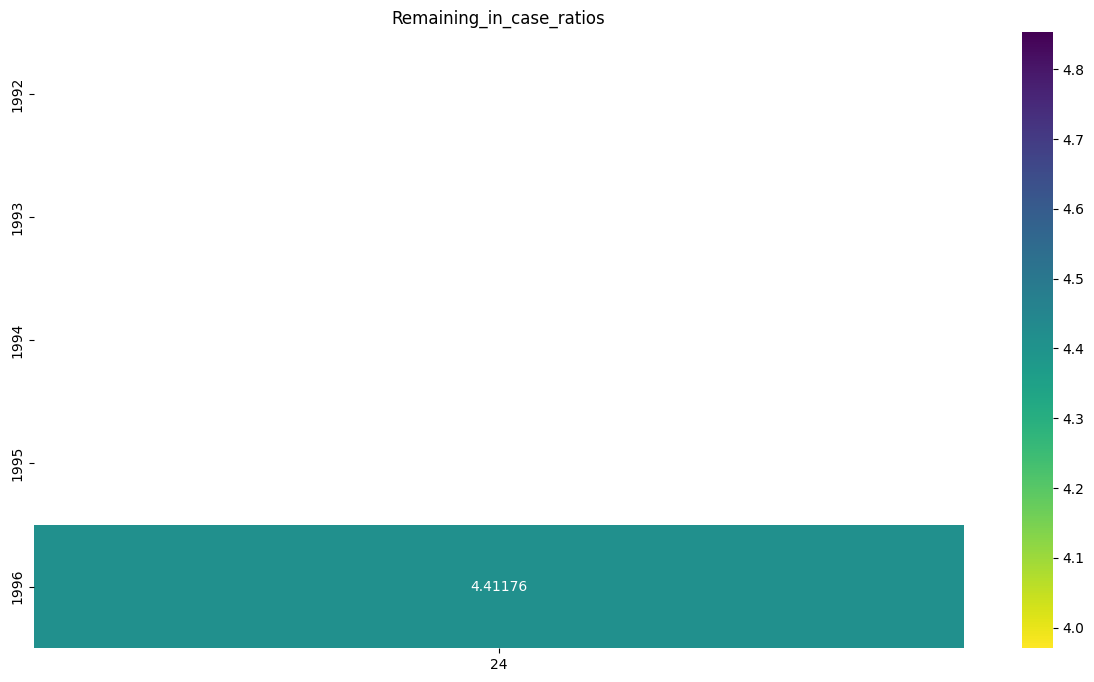



This is the case_out measures or averages Triangle
       Mean    Median  Months
0  4.411765  4.411765      24
----------------------------------------------------------------------------------------------------------------------------------------------------


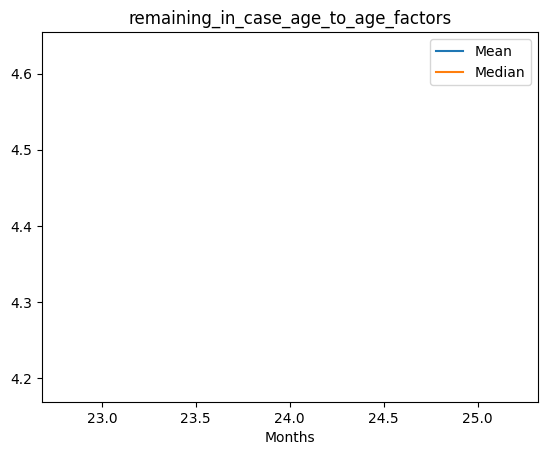



This is the paid incremental measures or averages Triangle
       Mean    Median  Months
0  0.882353  0.882353      24
----------------------------------------------------------------------------------------------------------------------------------------------------


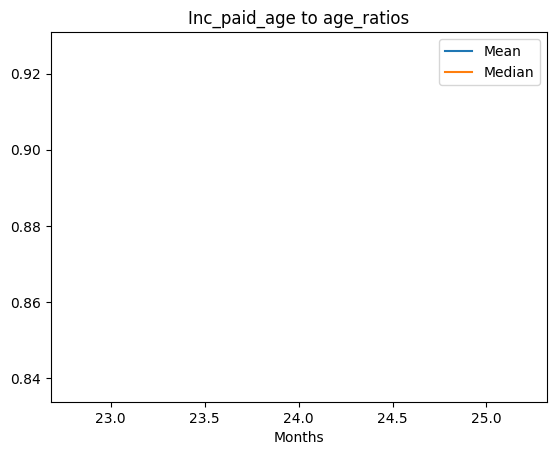



This is the filled case_outstanding Triangle
   AccidentYear  12      24
0          1992   0   0.000
1          1993  11  48.529
2          1994   0   0.000
3          1995  -1  -4.412
4          1996  17  75.000
5          1997   2   8.824
----------------------------------------------------------------------------------------------------------------------------------------------------


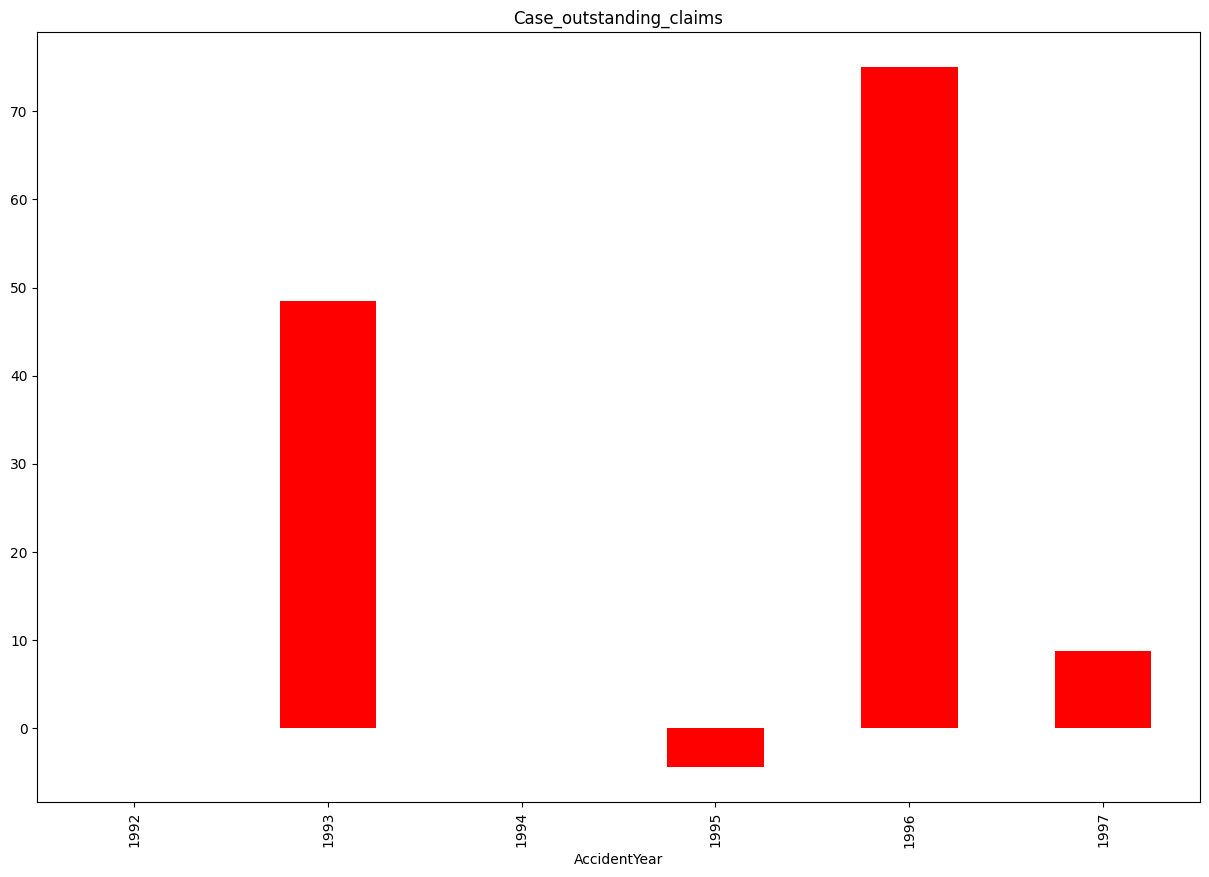



This is the cummulative filled incremental paid claims Triangle
   AccidentYear  12         24
0          1992   4   4.000000
1          1993   3  12.705882
2          1994  20  20.000000
3          1995  48  47.117647
4          1996  41  56.000000
5          1997  28  29.764706


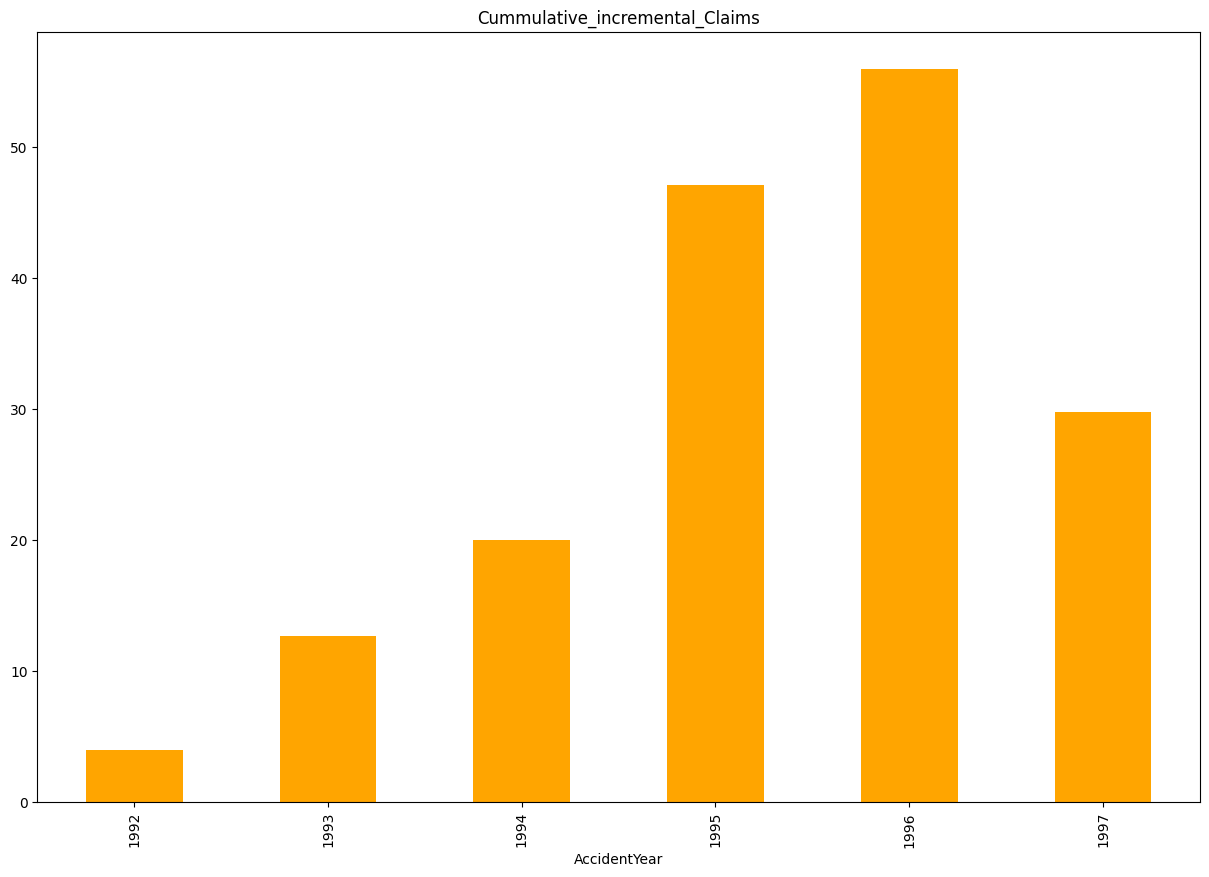

172
169.58823529411762
----------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------
The name of the dataset is: Dowa Fire & Marine Ins Co Ltd Us Br
the final dataset looks like this:
   AccidentYear  12  24  36  48  60   72   84   96  108  120
0          1991   0   0   0   0   0  0.0  NaN  NaN  NaN  NaN
1          1992   0   2   2   2   2  2.0  2.0  2.0  2.0  2.0
2          1993   0   0   0   0   0  0.0  0.0  NaN  NaN  NaN
3          1994   0   0   0   0   0  0.0  0.0  NaN  NaN  NaN
4          1995   0   5   5   5   5  5.0  5.0  5.0  5.0  5.0
5          1996   0   0   0   0   0  NaN  NaN  NaN  NaN  NaN
6          1997   0   0   0   0   0  NaN  NaN  NaN  NaN  NaN
--------------------------------------------------------------------------------------------

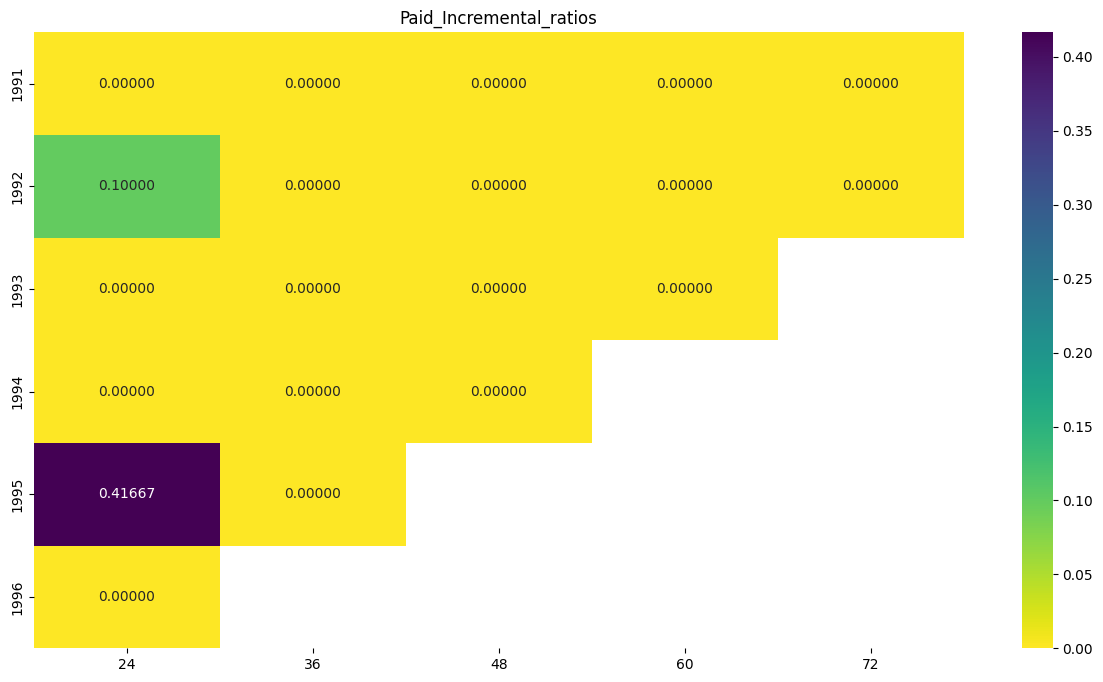



This is the case_ratio_Triangle
   AccidentYear        24        36        48        60        72
0          1991  3.000000  2.000000  1.666667  1.500000  1.400000
1          1992  2.900000  1.982759  1.660870  1.497382  1.391608
2          1993  2.947368  1.982143  1.657658  1.494565       NaN
3          1994  2.944444  1.981132  1.657143       NaN       NaN
4          1995  2.500000  1.966667       NaN       NaN       NaN
5          1996  3.000000       NaN       NaN       NaN       NaN
----------------------------------------------------------------------------------------------------------------------------------------------------


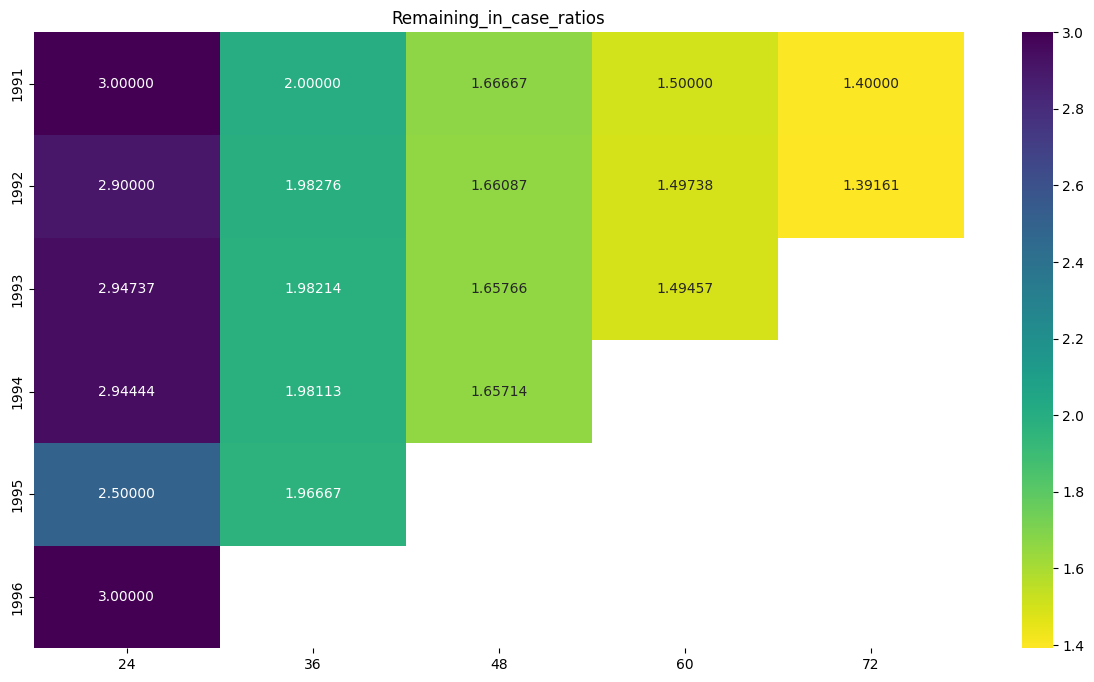



This is the case_out measures or averages Triangle
       Mean    Median  Months
0  2.881969  2.945906      24
1  1.982540  1.982143      36
2  1.660584  1.659264      48
3  1.497316  1.497382      60
4  1.395804  1.395804      72
----------------------------------------------------------------------------------------------------------------------------------------------------


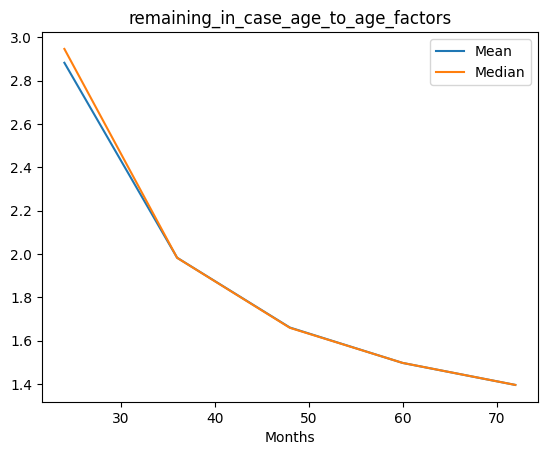



This is the paid incremental measures or averages Triangle
       Mean  Median  Months
0  0.086111     0.0      24
1  0.000000     0.0      36
2  0.000000     0.0      48
3  0.000000     0.0      60
4  0.000000     0.0      72
----------------------------------------------------------------------------------------------------------------------------------------------------


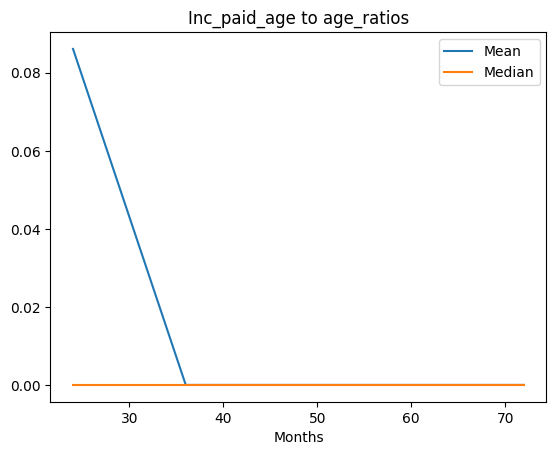



This is the filled case_outstanding Triangle
   AccidentYear  12      24       36       48       60       72
0          1991   7  21.000   42.000   70.000  105.000  147.000
1          1992  20  58.000  115.000  191.000  286.000  398.000
2          1993  19  56.000  111.000  184.000  275.000  383.846
3          1994  18  53.000  105.000  174.000  260.533  363.653
4          1995  12  30.000   59.000   97.974  146.698  204.762
5          1996   6  18.000   35.686   59.260   88.731  123.851
6          1997   3   8.646   17.141   28.464   42.620   59.489
----------------------------------------------------------------------------------------------------------------------------------------------------


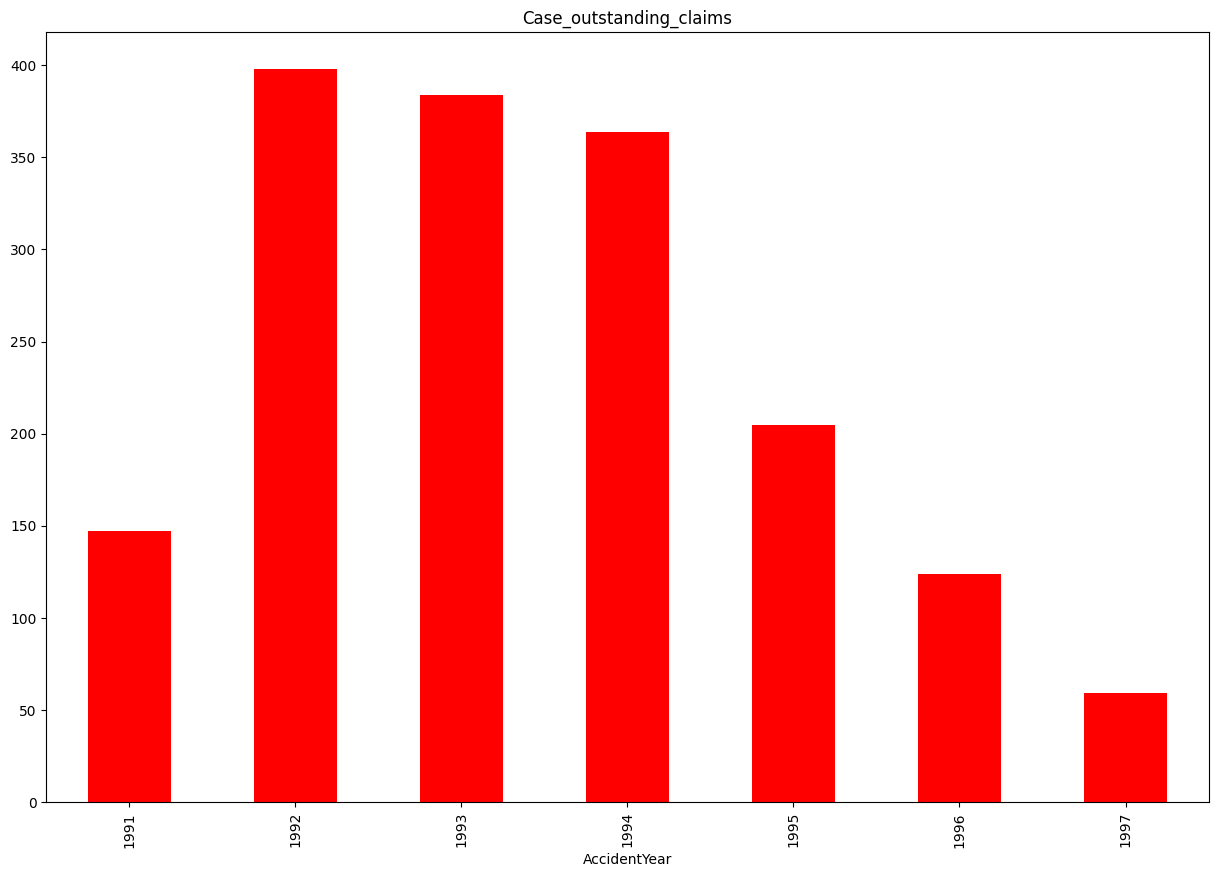



This is the cummulative filled incremental paid claims Triangle
   AccidentYear  12        24        36        48        60        72
0          1991   0  0.000000  0.000000  0.000000  0.000000  0.000000
1          1992   0  2.000000  2.000000  2.000000  2.000000  2.000000
2          1993   0  0.000000  0.000000  0.000000  0.000000  0.000000
3          1994   0  0.000000  0.000000  0.000000  0.000000  0.000000
4          1995   0  5.000000  5.000000  5.000000  5.000000  5.000000
5          1996   0  0.000000  0.000000  0.000000  0.000000  0.000000
6          1997   0  0.258333  0.258333  0.258333  0.258333  0.258333


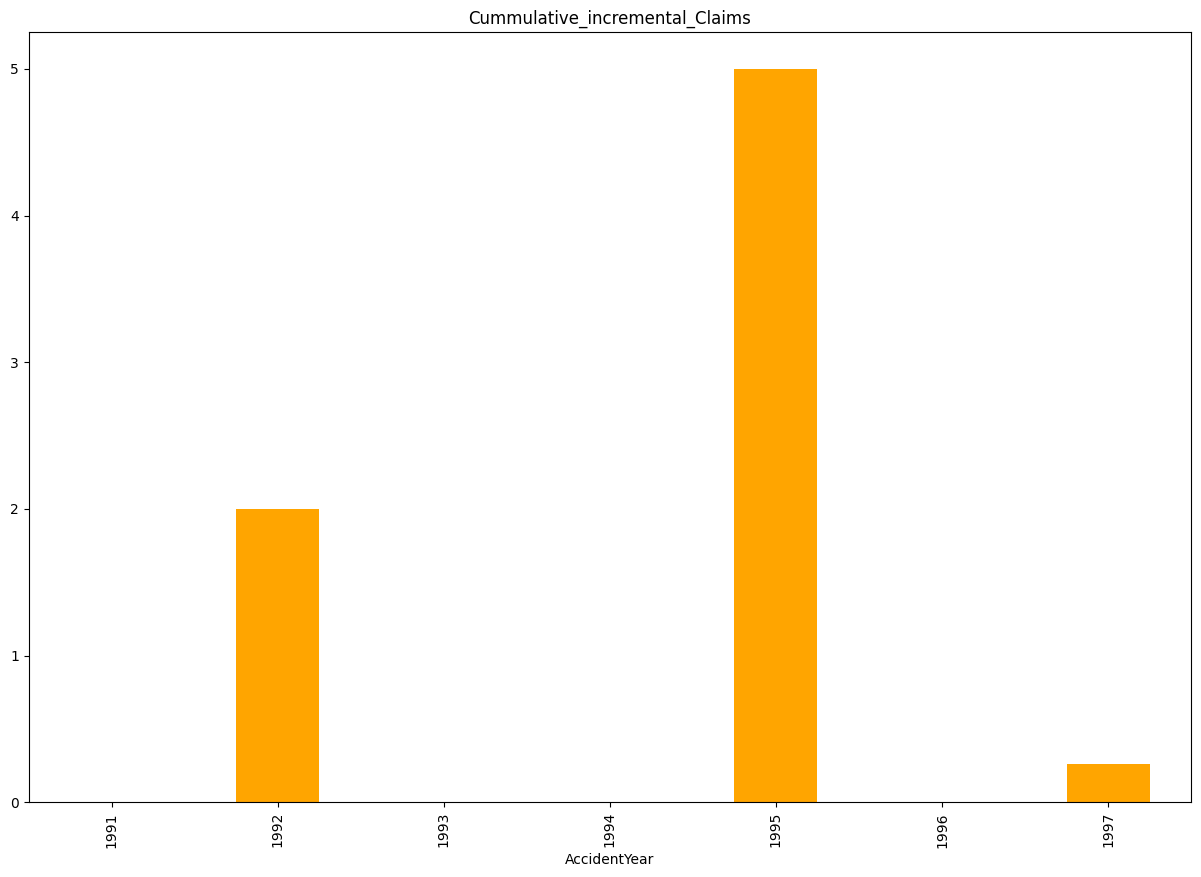

7.0
7.258333333333334
----------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------
The name of the dataset is: Yel Co Ins
the final dataset looks like this:
   AccidentYear   12   24   36   48   60   72   84   96  108  120
0          1993  108  133  133  149  153  153  152  152  153  153
1          1994   47   64   82   93   98   97  101  101  101  101
2          1995   38   38   37   42   47   54   56   56   56   56
3          1996   40   60   76   77   77   77   77   77   78   78
4          1997   25   29   32   32   38   38   40   40   40   40
----------------------------------------------------------------------------------------------------------------------------------------------------


This is the case_outstanding Triangle
   AccidentYear   12 

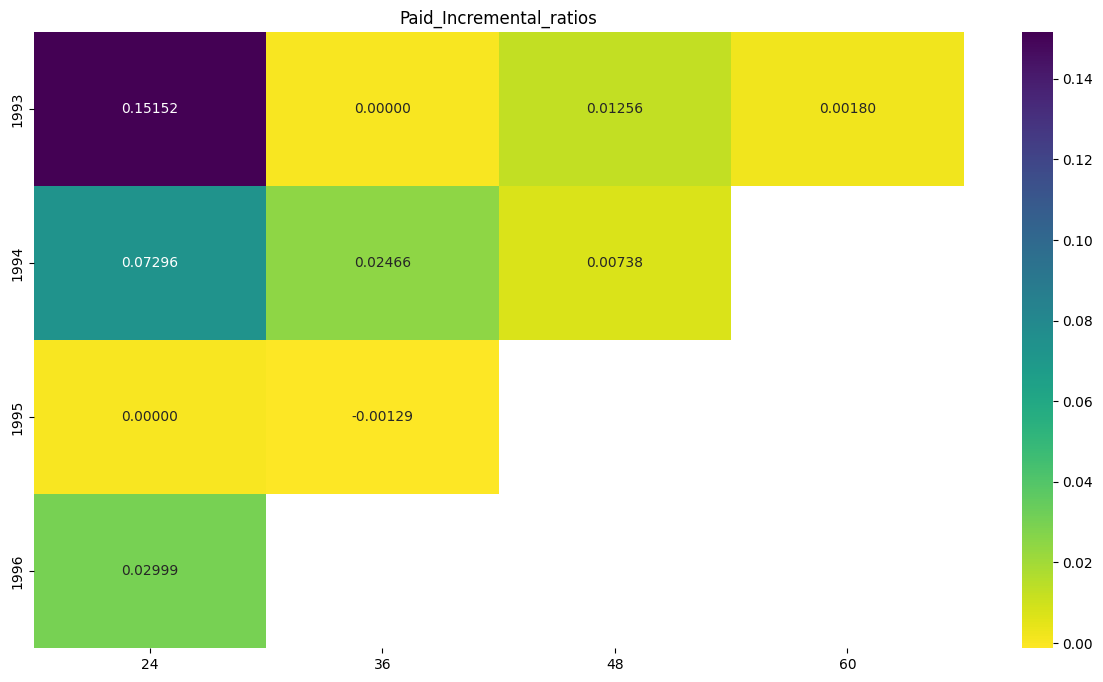



This is the case_ratio_Triangle
   AccidentYear        24        36        48        60
0          1993  3.521212  2.192771  1.747253  1.501348
1          1994  3.133047  2.042466  1.692153       NaN
2          1995  3.141700  2.046392       NaN       NaN
3          1996  3.017991       NaN       NaN       NaN
----------------------------------------------------------------------------------------------------------------------------------------------------


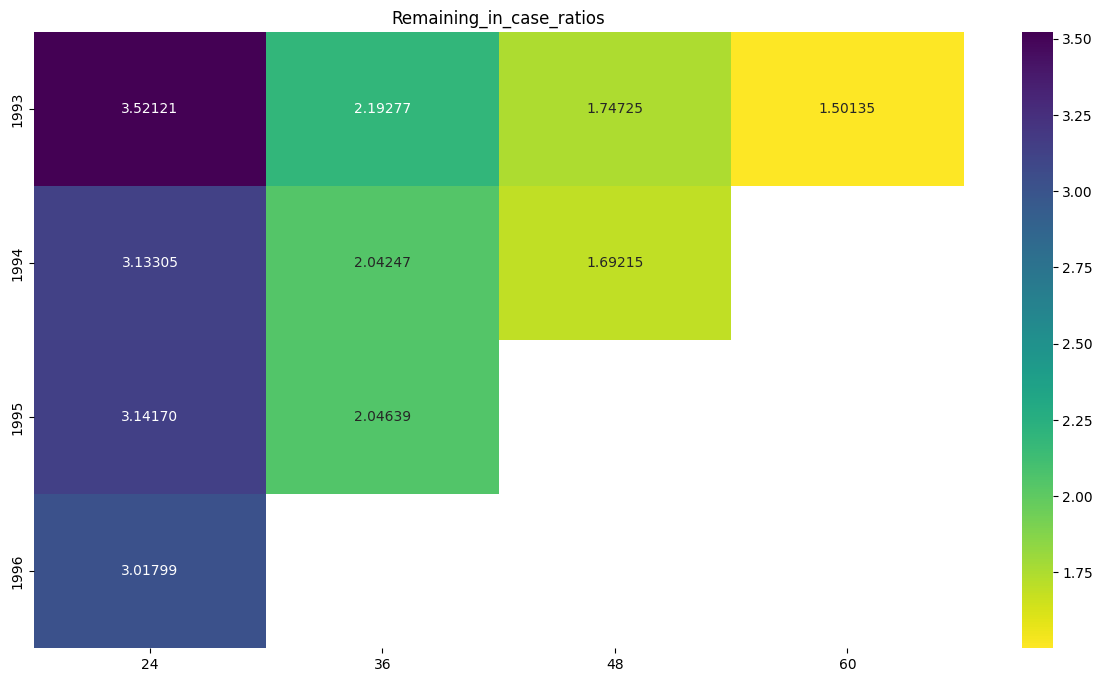



This is the case_out measures or averages Triangle
       Mean    Median  Months
0  3.203488  3.137374      24
1  2.093876  2.046392      36
2  1.719703  1.719703      48
3  1.501348  1.501348      60
----------------------------------------------------------------------------------------------------------------------------------------------------


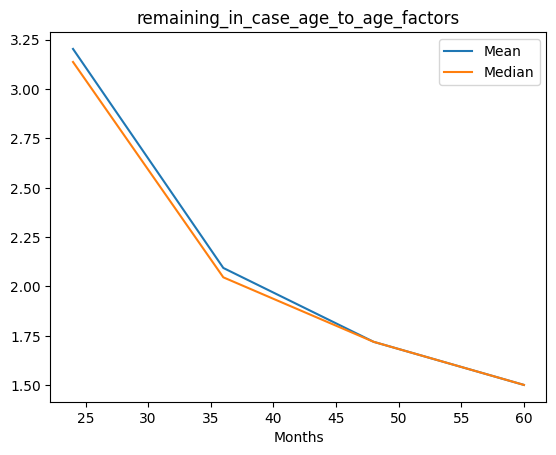



This is the paid incremental measures or averages Triangle
       Mean    Median  Months
0  0.063615  0.051473      24
1  0.007790  0.000000      36
2  0.009968  0.009968      48
3  0.001797  0.001797      60
----------------------------------------------------------------------------------------------------------------------------------------------------


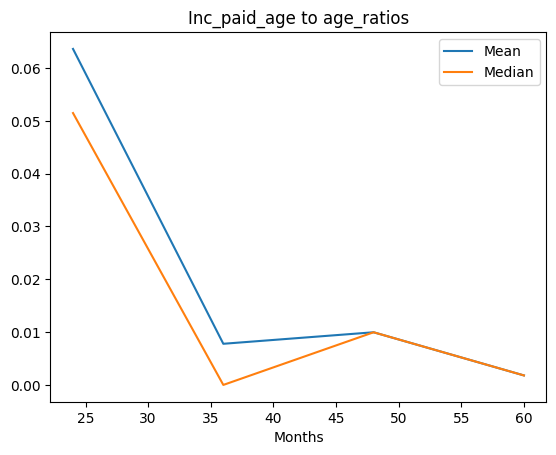



This is the filled case_outstanding Triangle
   AccidentYear   12        24        36        48         60
0          1993  165   581.000  1274.000  2226.000   3342.000
1          1994  233   730.000  1491.000  2523.000   3787.900
2          1995  247   776.000  1588.000  2730.888   4100.012
3          1996  667  2013.000  4214.973  7248.501  10882.520
4          1997  673  2155.947  4514.286  7763.230  11655.308
----------------------------------------------------------------------------------------------------------------------------------------------------


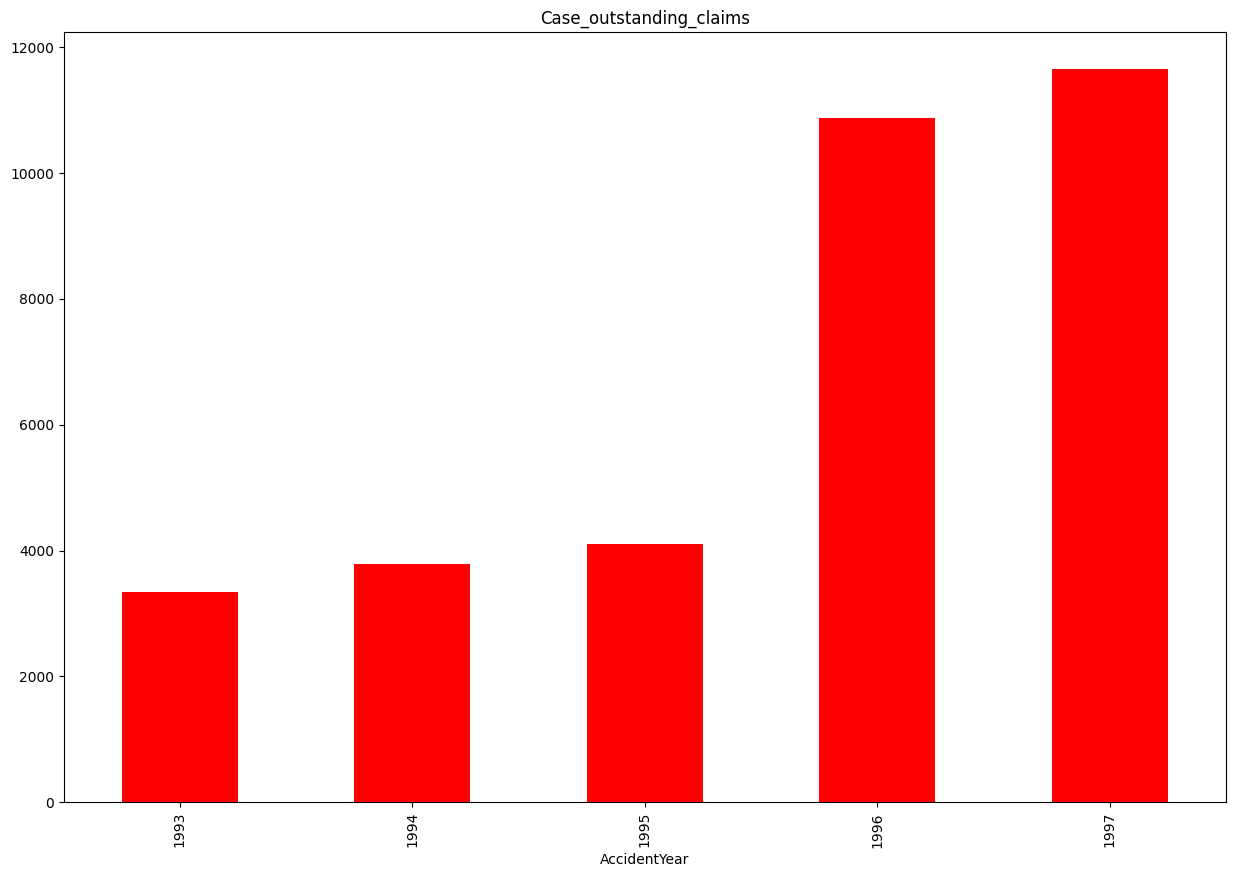



This is the cummulative filled incremental paid claims Triangle
   AccidentYear   12          24          36          48          60
0          1993  108  133.000000  133.000000  149.000000  153.000000
1          1994   47   64.000000   82.000000   93.000000   97.533693
2          1995   38   38.000000   37.000000   52.829556   57.736812
3          1996   40   60.000000   75.680515  117.696353  130.721512
4          1997   25   67.813153   84.607171  129.606632  143.556731


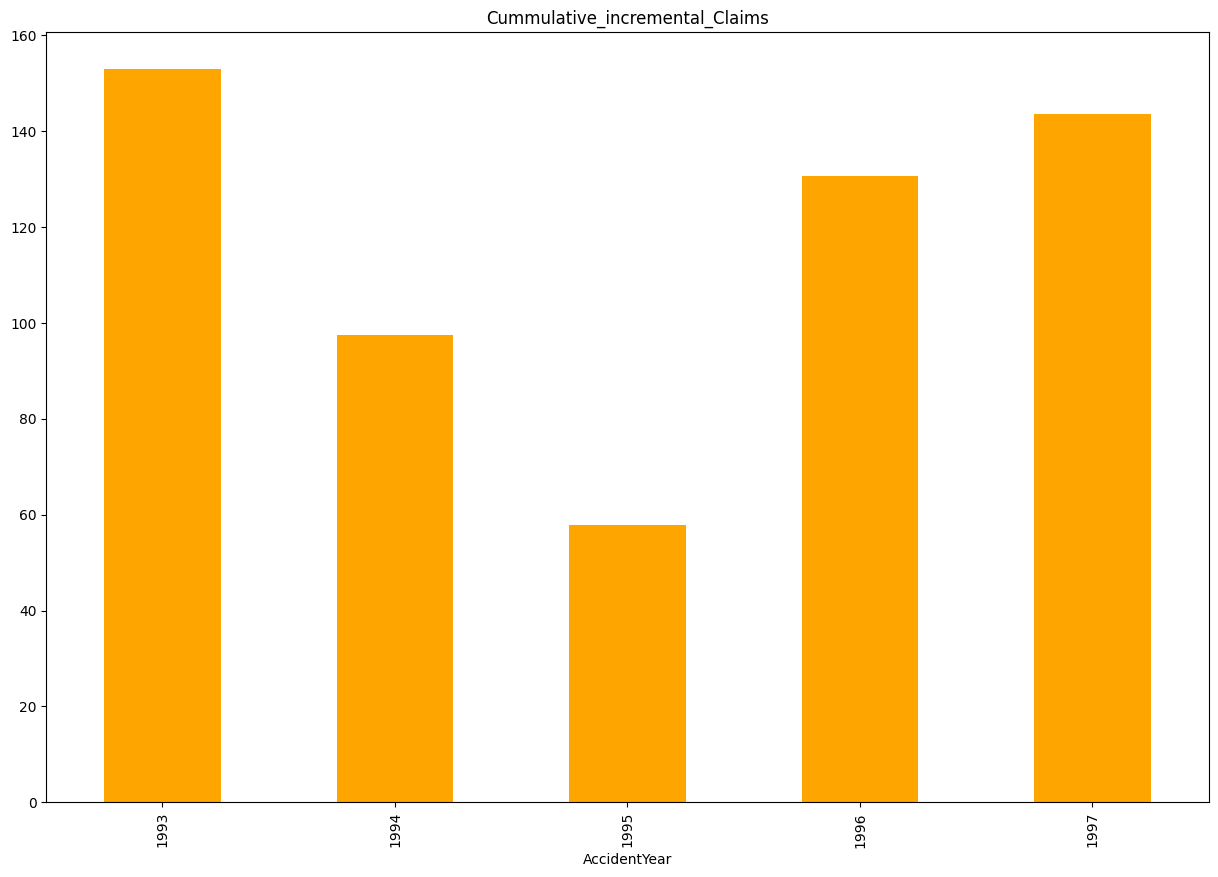

413
582.5487476831636
----------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
a=[]

for i in final_datasets:

  li=[]
  name=i
  print("The name of the dataset is:",i)
  initial=pd.read_csv('/content/drive/MyDrive/Colab resources/CsOutstandingProject/gen_for_collab/'+i+'.csv')
  writer=pd.ExcelWriter(publish+i+".xlsx",engine='xlsxwriter')
  initial.to_excel(writer,sheet_name="Raw")
  final=pd.read_csv('/content/drive/MyDrive/Colab resources/CsOutstandingProject/Gen_by_code not final/ok_data_sets/'+i+'.csv')

  obj=CaseOutstanding_Reserving(initial,"AccidentYear","DevelopmentYear","Cummulative_loss","Cummulative_paid_loss","Cummulative_case_outstanding")
  obj1=CaseOutstanding_Reserving(final,"AccidentYear","DevelopmentYear","Cummulative_loss","Cummulative_paid_loss","Cummulative_case_outstanding")



  parameter= 'Cummulative_paid_loss'
  final=obj1.d_triangle(parameter)
  final.to_excel(writer,sheet_name="final")
  print("the final dataset looks like this:")
  print(final)
  print("----------------------------------------------------------------------------------------------------------------------------------------------------")


  #trying to get the case outstanding triangle
  parameter="Cummulative_case_outstanding"
  case_out_triangle=obj.d_triangle(parameter)
  case_out_triangle.to_excel(writer,sheet_name="case_out_triangle")
  print("\n\nThis is the case_outstanding Triangle")
  print(case_out_triangle)
  print("----------------------------------------------------------------------------------------------------------------------------------------------------")

  #getting the paid triangle
  parameter="Cummulative_paid_loss"
  paid_triangle=obj.d_triangle(parameter)


  #building the incremental paid triangles from the cummulative ones above
  paid_incremental_triangle=obj.incremental_triangles()
  paid_incremental_triangle.to_excel(writer,sheet_name="paid_incremental")
  print("\n\nThis is the Incremental Paid Triangle")
  print(paid_incremental_triangle)
  print("----------------------------------------------------------------------------------------------------------------------------------------------------")

  #building the paid ratio triangle
  paid_ratio_triangle=obj.paid_tr_on_case_ratio()
  paid_ratio_triangle.to_excel(writer,sheet_name="paid_ratio_triangle")
  print("\n\nThis is the paid ratio Triangle")
  print(paid_ratio_triangle)
  print("----------------------------------------------------------------------------------------------------------------------------------------------------")

  plt.subplots(figsize=(15,8))
  dg=sns.heatmap(data=paid_ratio_triangle.drop("AccidentYear",axis=1),annot=True,cmap=sns.color_palette("viridis_r", as_cmap=True),fmt=".00005f",yticklabels=paid_ratio_triangle["AccidentYear"])
  plt.title("Paid_Incremental_ratios")
  plt.show()

  #building the case ratio triangle
  case_ratio_triangle=obj.rem_in_case_ratio()
  case_ratio_triangle.to_excel(writer,sheet_name="case_ratio_triangle")
  print("\n\nThis is the case_ratio_Triangle")
  print(case_ratio_triangle)
  print("----------------------------------------------------------------------------------------------------------------------------------------------------")

  plt.subplots(figsize=(15,8))
  some=sns.heatmap(data=case_ratio_triangle.drop("AccidentYear",axis=1),annot=True,cmap=sns.color_palette("viridis_r", as_cmap=True),fmt=".00005f",yticklabels=case_ratio_triangle["AccidentYear"])
  plt.title("Remaining_in_case_ratios")
  plt.show()

  #getting the averages for case_outstanding triangle
  measures_case_out=obj.calc_measures(case_ratio_triangle)
  measures_case_out.to_excel(writer,sheet_name="case_averages")
  print("\n\nThis is the case_out measures or averages Triangle")
  print(measures_case_out)
  print("----------------------------------------------------------------------------------------------------------------------------------------------------")

  measures_case_out.set_index("Months").plot(kind="line")
  plt.title("remaining_in_case_age_to_age_factors")
  plt.show()

  #getting the averages for incremental paid triangle
  measures_paid_tr=obj.calc_measures(paid_ratio_triangle)
  measures_paid_tr.to_excel(writer,sheet_name="paid_averages")
  print("\n\nThis is the paid incremental measures or averages Triangle")
  print(measures_paid_tr)
  print("----------------------------------------------------------------------------------------------------------------------------------------------------")

  measures_paid_tr.set_index("Months").plot(kind="line")
  plt.title("Inc_paid_age to age_ratios")
  plt.show()

  #filled the case_outstanding triangle
  nf=case_out=obj.fill_triangles_case_outstanding(measures_case_out,"Mean")
  nf.to_excel(writer,sheet_name="filled_case_reserves")
  print("\n\nThis is the filled case_outstanding Triangle")
  print(nf)
  print("----------------------------------------------------------------------------------------------------------------------------------------------------")

  nf.set_index(nf["AccidentYear"])[nf.columns[-1]].plot(kind="bar",figsize=(15,10),color="Red")
  plt.title("Case_outstanding_claims")
  plt.show()

  #filled the paid_triangles
  mf=obj.fill_triangles_paid_triangle(case_out,paid_incremental_triangle,measures_paid_tr,"Mean")

  #cummulatig the paid triangles to get the final cost
  for i in range(2,len(mf.columns)):
    mf[mf.columns[i]]=mf[mf.columns[i]]+mf[mf.columns[i-1]]

  mf.to_excel(writer,sheet_name="filled_paid_triangles")
  print("\n\nThis is the cummulative filled incremental paid claims Triangle")
  print(mf)
  mf.set_index(mf["AccidentYear"])[mf.columns[-1]].plot(kind="bar",figsize=(15,10),color="Orange")
  plt.title("Cummulative_incremental_Claims")
  plt.show()

  #comparing the results
  last=mf.columns[-1]
  print(final[last].sum())
  print(mf[last].sum())
  li.append(name)
  li.append(final[last].sum())
  li.append(mf[last].sum())
  a.append(li)
  print("----------------------------------------------------------------------------------------------------------------------------------------------------")
  print("----------------------------------------------------------------------------------------------------------------------------------------------------")

In [ ]:
results=pd.DataFrame(a,columns=["Name","original","predicted"])

In [ ]:
results

Name  original     predicted
0           American Modern Ins Grp Inc    8038.0  11027.784343
1                         Amerisafe Grp     212.0    211.083913
2         Overseas Partners Us Reins Co    2001.0   2302.116949
3      Hyundai Marine & Fire Ins Co Ltd      28.0     16.150480
4                Martingale Natl Ins Co    6122.0   6443.036435
5              Proformance Ins Co (The)    3209.0   2821.980348
6        Catholic Relief Ins Co Of Amer     787.0    787.000000
7                     First Amer Ins Co   10019.0  12310.670410
8                    Generali Us Branch   15069.0  12598.378551
9         Underwriters At Lloyds London     312.0    319.325027
10               Cooperative Mut Ins Co     314.0    446.064158
11                 Elevators Mut Ins Co     138.0    114.000000
12                 Mennonite Mut Ins Co     270.0    182.413797
13                  Co-Operative Ins Co      51.0     54.463070
14    New York Municipal Ins Reciprocal    2478.0   1626.250008
15     Housing & Redevelopment Ins Exch     188.0    113.595124
16             Middle States Ins Co Inc    3240.0   1799.870271
17         Contractors Bonding & Ins Co     326.0    272.545455
18             Pacific Specialty Ins Co     545.0    488.672520
19                         Omega Ins Co     207.0    207.235682
20               Southern Group Ind Inc     869.0    877.032151
21                          Nova Cas Co     189.0    217.274494
22                  Atlantic Cas Ins Co     172.0    169.588235
23  Dowa Fire & Marine Ins Co Ltd Us Br       7.0      7.258333
24                           Yel Co Ins     413.0    582.548748

In [ ]:
results["error"]=(results["original"]-results["predicted"])
results["error_wrt_original"]=(results["error"]/results["original"])*100

In [ ]:
writer=pd.ExcelWriter('/content/drive/MyDrive/Colab resources/CsOutstandingProject/initial_reports_for_ok_data_sets'+".xlsx",engine='xlsxwriter')
results.to_excel(writer,sheet_name="Results for good_data_sets")


In [ ]:
sk=StandardScaler()
v1=sk.fit_transform(results[["original","predicted"]])


In [ ]:
ch=pd.DataFrame(v1,columns=["original","predicted"])

In [ ]:
results[(results["error_wrt_original"] < 10) & (results["error_wrt_original"] > -10)]["error_wrt_original"].count()

9

In [ ]:
results[(results["error_wrt_original"] < 1) & (results["error_wrt_original"] > -1)]["error_wrt_original"].count()

4

In [ ]:
mae=mean_absolute_error(ch['original'],ch['predicted'])

In [ ]:
mse=mean_squared_error(ch['original'],ch['predicted'])

In [ ]:
mae

0.12462294193949244

In [ ]:
mse

0.06449797915890235